In [1]:
import librosa as lb
import numpy as np
from lab3_proto import *
from helper_functions import *
from lab1_tools import *
import os
# from pysndfile import sndio
import math
import pickle
import warnings

from scipy.signal import lfilter
from scipy.fftpack import fft
from scipy.signal import hamming
from lab1_tools import *
from scipy.fftpack.realtransforms import dct
from sklearn.preprocessing import StandardScaler

In [2]:
def path2info(path):
    """
    path2info: parses paths in the TIDIGIT format and extracts information
               about the speaker and the utterance

    Example:
    path2info('tidigits/disc_4.1.1/tidigits/train/man/ae/z9z6531a.wav')
    """
    rest, filename = os.path.split(path)
    rest, speakerID = os.path.split(rest)
    rest, gender = os.path.split(rest)
    digits = filename[:-5]
    repetition = filename[-5]
    return gender, speakerID, digits, repetition

def loadAudio(filename):
    """
    loadAudio: loads audio data from file using pysndfile

    Note that, by default pysndfile converts the samples into floating point
    numbers and rescales them in the range [-1, 1]. This is avoided by specifying
    the option dtype=np.int16 which keeps both the original data type and range
    of values.
    """
    sndobj = lb.load(filename)#, dtype=np.int16)
    samplingrate = sndobj[1]
    samples = np.array(sndobj[0])
    return samples, samplingrate

def frames2trans(sequence, outfilename=None, timestep=0.01):
    """
    Outputs a standard transcription given a frame-by-frame
    list of strings.

    Example (using functions from Lab 1 and Lab 2):
    phones = ['sil', 'sil', 'sil', 'ow', 'ow', 'ow', 'ow', 'ow', 'sil', 'sil']
    trans = frames2trans(phones, 'oa.lab')

    Then you can use, for example wavesurfer to open the wav file and the transcription
    """
    sym = sequence[0]
    start = 0
    end = 0
    trans = ''
    for t in range(len(sequence)):
        if sequence[t] != sym:
            trans = trans + str(start) + ' ' + str(end) + ' ' + sym + '\n'
            sym = sequence[t]
            start = end
        end = end + timestep
    trans = trans + str(start) + ' ' + str(end) + ' ' + sym + '\n'
    if outfilename != None:
        with open(outfilename, 'w') as f:
            f.write(trans)
    return trans

In [3]:
# Function given by the exercise ----------------------------------

def lifter(mfcc, lifter=22):
    """
    Applies liftering to improve the relative range of MFCC coefficients.
       mfcc: NxM matrix where N is the number of frames and M the number of MFCC coefficients
       lifter: lifering coefficient
    Returns:
       NxM array with lifeterd coefficients
    """
    nframes, nceps = mfcc.shape
    cepwin = 1.0 + lifter/2.0 * np.sin(np.pi * np.arange(nceps) / lifter)
    l = np.multiply(mfcc, np.tile(cepwin, nframes).reshape((nframes,nceps)))
    return l

def hz2mel(f):
    """Convert an array of frequency in Hz into mel."""
    return 1127.01048 * np.log(f/700 +1)

def trfbank(fs, nfft, lowfreq=133.33, linsc=200/3., logsc=1.0711703, nlinfilt=13, nlogfilt=27, equalareas=False):
    """Compute triangular filterbank for MFCC computation.
    Inputs:
    fs:         sampling frequency (rate)
    nfft:       length of the fft
    lowfreq:    frequency of the lowest filter
    linsc:      scale for the linear filters
    logsc:      scale for the logaritmic filters
    nlinfilt:   number of linear filters
    nlogfilt:   number of log filters
    Outputs:
    res:  array with shape [N, nfft], with filter amplitudes for each column.
            (N=nlinfilt+nlogfilt)
    From scikits.talkbox"""
    # Total number of filters
    nfilt = nlinfilt + nlogfilt

    #------------------------
    # Compute the filter bank
    #------------------------
    # Compute start/middle/end points of the triangular filters in spectral
    # domain
    freqs = np.zeros(nfilt+2)
    freqs[:nlinfilt] = lowfreq + np.arange(nlinfilt) * linsc
    freqs[nlinfilt:] = freqs[nlinfilt-1] * logsc ** np.arange(1, nlogfilt + 3)
    if equalareas:
        heights = np.ones(nfilt)
    else:
        heights = 2./(freqs[2:] - freqs[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    fbank = np.zeros((nfilt, nfft))
    # FFT bins (in Hz)
    nfreqs = np.arange(nfft) / (1. * nfft) * fs
    for i in range(nfilt):
        low = freqs[i]
        cen = freqs[i+1]
        hi = freqs[i+2]

        lid = np.arange(np.floor(low * nfft / fs) + 1,
                        np.floor(cen * nfft / fs) + 1, dtype=np.int)
        lslope = heights[i] / (cen - low)
        rid = np.arange(np.floor(cen * nfft / fs) + 1,
                        np.floor(hi * nfft / fs) + 1, dtype=np.int)
        rslope = heights[i] / (hi - cen)
        fbank[i][lid] = lslope * (nfreqs[lid] - low)
        fbank[i][rid] = rslope * (hi - nfreqs[rid])

    return fbank


def mspec(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, samplingrate=20000):
    """Computes Mel Filterbank features.
    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        samplingrate: sampling rate of the original signal

    Returns:
        N x nfilters array with mel filterbank features (see trfbank for nfilters)
    """
    frames = enframe(samples, winlen, winshift)
    preemph = preemp(frames, preempcoeff)
    windowed = windowing(preemph)
    spec = powerSpectrum(windowed, nfft)
    return logMelSpectrum(spec, samplingrate)

def mfcc(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, nceps=13, samplingrate=20000, liftercoeff=22):
    """Computes Mel Frequency Cepstrum Coefficients.

    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        nceps: number of cepstrum coefficients to compute
        samplingrate: sampling rate of the original signal
        liftercoeff: liftering coefficient used to equalise scale of MFCCs

    Returns:
        N x nceps array with lifetered MFCC coefficients
    """
    mspecs = mspec(samples, winlen, winshift, preempcoeff, nfft, samplingrate)
    ceps = cepstrum(mspecs, nceps)
    return lifter(ceps, liftercoeff)

# Functions to be implemented ----------------------------------

def enframe(samples, winlen, winshift):
    """
    Slices the input samples into overlapping windows.

    Args:
        winlen: window length in samples.
        winshift: shift of consecutive windows in samples
    Returns:
        numpy array [N x winlen], where N is the number of windows that fit
        in the input signal
    """

    # check if i+winlen > len(samples):

    result = []
    for i in range(0,len(samples),winshift):
        if(i+winlen > len(samples)): break
        result.append(samples[i:i+winlen])
    return np.array(result)
    # return np.array([samples[i:i+winlen] for i in range(0,len(samples),winshift)])
    
def preemp(input, p=0.97):
    """
    Pre-emphasis filter.

    Args:
        input: array of speech frames [N x M] where N is the number of frames and
               M the samples per frame
        p: preemhasis factor (defaults to the value specified in the exercise)

    Output:
        output: array of pre-emphasised speech samples
    Note (you can use the function lfilter from scipy.signal)
    """
    return lfilter([1, -p], [1], input)

def windowing(input):
    """
    Applies hamming window to the input frames.

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
    Output:
        array of windoed speech samples [N x M]
    Note (you can use the function hamming from scipy.signal, include the sym=0 option
    if you want to get the same results as in the example)
    """
    return input * hamming(input.shape[1], sym=0)

def powerSpectrum(input, nfft):
    """
    Calculates the power spectrum of the input signal, that is the square of the modulus of the FFT

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
        nfft: length of the FFT
    Output:
        array of power spectra [N x nfft]
    Note: you can use the function fft from scipy.fftpack
    """
    freq = fft(input, nfft)
    return freq.real**2 + freq.imag**2

def logMelSpectrum(input, samplingrate):
    """
    Calculates the log output of a Mel filterbank when the input is the power spectrum

    Args:
        input: array of power spectrum coefficients [N x nfft] where N is the number of frames and
               nfft the length of each spectrum
        samplingrate: sampling rate of the original signal (used to calculate the filterbank shapes)
    Output:
        array of Mel filterbank log outputs [N x nmelfilters] where nmelfilters is the number
        of filters in the filterbank
    Note: use the trfbank function provided in lab1_tools.py to calculate the filterbank shapes and
          nmelfilters
    """
    nfft = input.shape[1]
    tr_filter = trfbank(samplingrate, nfft)
    return np.log(np.dot(input, tr_filter.transpose()))

def cepstrum(input, nceps):
    """
    Calulates Cepstral coefficients from mel spectrum applying Discrete Cosine Transform

    Args:
        input: array of log outputs of Mel scale filterbank [N x nmelfilters] where N is the
               number of frames and nmelfilters the length of the filterbank
        nceps: number of output cepstral coefficients
    Output:
        array of Cepstral coefficients [N x nceps]
    Note: you can use the function dct from scipy.fftpack.realtransforms
    """
    return dct(input)[:,0:nceps]

def dtw(x, y, dist):
    """Dynamic Time Warping.

    Args:
        x, y: arrays of size NxD and MxD respectively, where D is the dimensionality
              and N, M are the respective lenghts of the sequences
        dist: distance function (can be used in the code as dist(x[i], y[j]))

    Outputs:
        d: global distance between the sequences (scalar) normalized to len(x)+len(y)
        LD: local distance between frames from x and y (NxM matrix)
        AD: accumulated distance between frames of x and y (NxM matrix)
        path: best path thtough AD

    Note that you only need to define the first output for this exercise.
    """

    AD = np.zeros(dist.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            AD[i,j] = dist[i,j] + min(AD[i - 1, j], AD[i, j - 1], AD[i - 1, j - 1])
    
    d = AD[-1, -1]/(x.shape[0] + y.shape[0])

    return d, dist, AD

def viterbi(log_emlik, log_startprob, log_transmat, forceFinalState=True):
    """Viterbi path.
    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j
        forceFinalState: if True, start backtracking from the final state in
                  the model, instead of the best state at the last time step
    Output:
        viterbi_loglik: log likelihood of the best path
        viterbi_path: best path
    """

    B = np.zeros(log_emlik.shape, dtype = int)
    V = np.zeros(log_emlik.shape)
    V[0] = log_startprob.flatten() + log_emlik[0]

    for n in range(1, log_emlik.shape[0]):
        for j in range(log_emlik.shape[1]):
            V[n][j] = np.max(V[n - 1,:] + log_transmat[:,j]) + log_emlik[n, j]
            B[n][j] = np.argmax(V[n - 1,:] + log_transmat[:,j])

    lastIdx = np.argmax(V[log_emlik.shape[0] - 1])

    viterbi_path = [lastIdx]
    for i in reversed(range(1, B.shape[0])):
        viterbi_path.append(B[i, viterbi_path[-1]])
    viterbi_path.reverse()
    viterbi_path = np.array(viterbi_path)

    return np.max(V[ log_emlik.shape[0] - 1]), viterbi_path

def log_multivariate_normal_density_diag(X, means, covars):
    """Compute Gaussian log-density at X for a diagonal model

    Args:
        X: array like, shape (n_observations, n_features)
        means: array like, shape (n_components, n_features)
        covars: array like, shape (n_components, n_features)

    Output:
        lpr: array like, shape (n_observations, n_components)
    From scikit-learn/sklearn/mixture/gmm.py
    """
    n_samples, n_dim = X.shape
    lpr = -0.5 * (n_dim * np.log(2 * np.pi) + np.sum(np.log(covars), 1)
                  + np.sum((means ** 2) / covars, 1)
                  - 2 * np.dot(X, (means / covars).T)
                  + np.dot(X ** 2, (1.0 / covars).T))
    return lpr

def concatTwoHMMs(hmm1, hmm2):
    """ Concatenates 2 HMM models
    Args:
       hmm1, hmm2: two dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances
    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be different for each)
    Output
       dictionary with the same keys as the input but concatenated models:
          startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances
    K is the sum of the number of emitting states from the input models
   
    Example:
       twoHMMs = concatHMMs(phoneHMMs['sil'], phoneHMMs['ow'])
    See also: the concatenating_hmms.pdf document in the lab package
    """
    
    concatedHMM = {}
    #M is the number of emitting states in each HMM model (could be different for each)
    #K is the sum of the number of emitting states from the input models
    
    M1 = hmm1['means'].shape[0]
    M2 = hmm2['means'].shape[0]
    K = M1 + M2
    
    concatedHMM['name'] = hmm1['name'] + hmm2['name']
    concatedHMM['startprob'] = np.zeros((K + 1, 1))
    concatedHMM['transmat'] = np.zeros((K + 1, K + 1))
    concatedHMM['means'] = np.vstack((hmm1['means'],hmm2['means']))
    concatedHMM['covars'] = np.vstack((hmm1['covars'],hmm2['covars']))
        
    
    start1 = hmm1['startprob'].reshape(-1,1)
    start2 = hmm2['startprob'].reshape(-1,1)
    
    concatedHMM['startprob'][:hmm1['startprob'].shape[0]-1,:] = start1[:-1,:]
    concatedHMM['startprob'][hmm1['startprob'].shape[0]-1:,:] = np.dot(start1[-1,0],start2)
    trans = concatedHMM['transmat']
    trans1 = hmm1['transmat']
    trans2 = hmm2['transmat']

    trans[:trans1.shape[0]-1,:trans1.shape[1]-1] = trans1[:-1,:-1]
    temp = trans1[:-1,-1].reshape(-1,1)
    trans[:trans1.shape[0]-1,trans1.shape[1]-1:] = \
                            np.dot(temp,start2.T)
    trans[trans1.shape[0]-1:,trans1.shape[1]-1:] = trans2
    concatedHMM['transmat'] = trans    
    
    return concatedHMM


# this is already implemented, but based on concat2HMMs() above
def concatHMMs(hmmmodels, namelist):
    """ Concatenates HMM models in a left to right manner
    Args:
       hmmmodels: dictionary of models indexed by model name. 
       hmmmodels[name] is a dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances
       namelist: list of model names that we want to concatenate
    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be
      different in each model)
    Output
       combinedhmm: dictionary with the same keys as the input but
                    combined models:
         startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances
    K is the sum of the number of emitting states from the input models
    Example:
       wordHMMs['o'] = concatHMMs(phoneHMMs, ['sil', 'ow', 'sil'])
    """
    concat = hmmmodels[namelist[0]]
    for idx in range(1,len(namelist)):
        concat = concatTwoHMMs(concat, hmmmodels[namelist[idx]])
    return concat

In [4]:
PATH = '/Users/nandakishorprabhu/Documents/Studies/DT2119/Code'
phoneHMMs = np.load('lab2_models_all.npz',allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}
# stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]
# f = open("stateList.txt","w")
# for state in stateList:
#     f.write(f"{state}\n")
stateList = open("stateList.txt", "r").readlines()
stateList = [state.strip() for state in stateList]

example_data = np.load("lab3_example.npz", allow_pickle=True)['example']
example_data = dict(enumerate(example_data.flatten(), 1))[1]
filename = example_data['filename']
wordTrans = list(path2info(filename)[2])
# print(wordTrans)

prondict = {}
prondict['o'] = ['ow']
prondict['z'] = ['z', 'iy', 'r', 'ow']
prondict['1'] = ['w', 'ah', 'n']
prondict['2'] = ['t', 'uw']
prondict['3'] = ['th', 'r', 'iy']
prondict['4'] = ['f', 'ao', 'r']
prondict['5'] = ['f', 'ay', 'v']
prondict['6'] = ['s', 'ih', 'k', 's']
prondict['7'] = ['s', 'eh', 'v', 'ah', 'n']
prondict['8'] = ['ey', 't']
prondict['9'] = ['n', 'ay', 'n']

phoneTrans = words2phones(wordTrans, prondict)
# print(phoneTrans)

utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)
# print(utteranceHMM)

# stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
# f = open("stateTrans.txt","w")
# for state in stateTrans:
#     f.write(f"{state}\n")
stateTrans = open("stateTrans.txt", "r").readlines()
stateTrans = [state.strip() for state in stateTrans]
# print(stateTrans[10])

In [5]:
run = False
if run:
    # X = example_data['lmfcc']
    # means = utteranceHMM['means']
    # covars = utteranceHMM['covars']
    # log_likelihood = log_multivariate_normal_density_diag(X,means,covars)

    # log_startprob = np.log(utteranceHMM['startprob'][:-1])
    # log_transmat = np.log(utteranceHMM['transmat'][:-1,:-1])

    # prob,viterbiStateTrans = viterbi(log_likelihood,log_startprob,log_transmat)
    # # print(viterbiStateTrans)

    # vpath = [stateTrans[i] for i in viterbiStateTrans]
    # print(vpath)
    # viterbiStateTrans = forcedAlignment(example_data['lmfcc'], utteranceHMM, phoneTrans)
    # vpath = [stateTrans[i] for i in viterbiStateTrans]
    # print(vpath)
    # frames = frames2trans(vpath, outfilename='z43a.lab')
    # print(frames)

    # filenames = ['/Users/nandakishorprabhu/Documents/Studies/DT2119/Code/traindata.npz']
    # sets = ['/Users/nandakishorprabhu/Documents/Studies/DT2119/Code/tidigits/disc_4.1.1/tidigits/train']
    filenames = ['traindata.npz']
    sets = ['/Users/nandakishorprabhu/Documents/Studies/DT2119/Code/tidigits/disc_4.1.1/tidigits/train']
    for idx, file_name in enumerate(filenames):
        i = 0
        if not os.path.isfile(file_name):
            data = []
            for root, dirs, files in os.walk(sets[idx]):
                for file in files:
                    if file.endswith('.wav'):
                        filename = os.path.join(root, file)
                        samples, samplingrate = loadAudio(filename)
                        lmfcc = mfcc(samples)
                        mspecs = mspec(samples)
                        wordTrans = list(path2info(filename)[2])
                        phoneTrans = words2phones(wordTrans, prondict)
                        targets = forcedAlignment(lmfcc, utteranceHMM, phoneTrans)
                        data.append({'filename': filename, 'lmfcc': lmfcc, 'mspec': mspecs, 'targets': targets})
    #             if file_name == 'traindata.npz':
    #                 np.savez('/Users/nandakishorprabhu/Documents/Studies/DT2119/Code/traindata.npz', traindata=data)
    #             elif file_name == 'testdata.npz':
    #                 np.savez(PATH + file_name, testdata=data)

In [6]:
def prepare_features(datapath, saveName):
    traindata = []
#     stateList = list()
#     with open(stateListPath) as f:
#         for line in f:
#             stateList.append(line.strip('\n'))

    totalfiles = 0
    for root, dirs, files in os.walk(datapath):
        for file in files:
            if file.endswith('.wav'):
                totalfiles += 1
    count = 0
    exit=False
    for root, dirs, files in os.walk(datapath):
        for file in files:
            if file.endswith('.wav'):
                filename = os.path.join(root, file)
                samples, samplingrate = loadAudio(filename)
                print(samples.shape)
                if count>10: 
                    exit = True
                    break
                count+=1
                lmfcc = mfcc(samples)
                mspecs = mspec(samples)
                wordTrans = list(path2info(filename)[2])
                phoneTrans = words2phones(wordTrans, prondict, addShortPause=False)
                targets = forcedAlignment(lmfcc, utteranceHMM, phoneTrans)

                traindata.append({'filename': filename,
                                 'lmfcc': lmfcc,
                                 'mspec': mspecs,
                                 'targets':targets})
        if exit: break
    return traindata

In [7]:
traindata = prepare_features('/media/ali/Data/datasets/tidigits/disc_4.1.1/tidigits/train', 'traindata.npz')
# np.savez('/Users/nandakishorprabhu/Documents/Studies/DT2119/Code/DT2119-Speech-and-Speaker-Recognition/lab3/traindata.npz', traindata = traindata)

(89753,)


/home/ali/Desktop/speech/lab3/dt2119_lab3_2019-04-25/lab3_proto.py:50: RuntimeWarning: divide by zero encountered in log
  log_startprob = np.log(phoneHMMs['startprob'][:-1])
/home/ali/Desktop/speech/lab3/dt2119_lab3_2019-04-25/lab3_proto.py:51: RuntimeWarning: divide by zero encountered in log
  log_transmat = np.log(phoneHMMs['transmat'][:-1,:-1])


(46570,)
(29636,)
(40361,)
(39796,)
(25402,)
(21733,)
(57295,)
(84108,)
(53344,)
(36974,)
(27096,)


In [7]:
traindata = np.load('traindata.npz', allow_pickle = True)
traindata = dict(zip(("{}".format(k) for k in traindata), (traindata[k] for k in traindata)))
# print(traindata)
male_speakers = np.unique([traindata['traindata'][i]["filename"].split('/')[6] 
                      for i in range(len(traindata['traindata']))
                      if traindata['traindata'][i]["filename"].split('/')[4] == 'man'])
female_speakers = np.unique([traindata['traindata'][i]["filename"].split('/')[6] 
                      for i in range(len(traindata['traindata'])) 
                      if traindata['traindata'][i]["filename"].split('/')[4] == 'woman'])


m_train_speakers = male_speakers[0:math.floor(len(male_speakers)*0.9)]
m_valid_speakers = male_speakers[math.floor(len(male_speakers)*0.9):]

# print(len(m_train_speakers))
# print(m_valid_speakers)

m_train_data =  [traindata['traindata'][i] for i in range(len(traindata['traindata']))
                  if traindata['traindata'][i]["filename"].split('/')[6] in m_train_speakers]

m_valid_data =  [traindata['traindata'][i] for i in range(len(traindata['traindata'])) 
                  if traindata['traindata'][i]["filename"].split('/')[6] in m_valid_speakers]

w_train_speakers = female_speakers[0:math.floor(len(female_speakers)*0.9)]
w_valid_speakers = female_speakers[math.floor(len(female_speakers)*0.9):]

w_train_data =  [traindata['traindata'][i] for i in range(len(traindata['traindata'])) 
                  if traindata['traindata'][i]["filename"].split('/')[6] in w_train_speakers]

w_valid_data =  [traindata['traindata'][i] for i in range(len(traindata['traindata'])) 
                  if traindata['traindata'][i]["filename"].split('/')[6] in w_valid_speakers]

training_data = m_train_data + w_train_data
validation_data = m_valid_data + w_valid_data

# print("Training Data : ", (len(training_data)/len(traindata['traindata']))*100)
# print("Validation Data :", (len(validation_data)/len(traindata['traindata']))*100)

In [8]:
training_data[0]

{'filename': 'tidigits/disc_4.1.1/tidigits/train/man/pd/1a.wav',
 'lmfcc': array([[  43.01650777, -141.25202819,   59.60007995, ...,  128.11223863,
          104.41445571,  135.43272141],
        [  13.35679752, -182.19497652,    2.69465077, ...,   53.47767919,
           16.39576109,   55.70580523],
        [  71.19330241, -188.39082508,  -26.02490997, ...,  -10.81831071,
          -87.38847232,   58.53901174],
        ...,
        [  76.91332334, -181.0738616 , -107.38937949, ...,  -51.51982279,
          -89.71896586,  119.36797839],
        [  38.76448285, -183.14092644,  -88.5167919 , ...,  -44.35797218,
           20.44035802,  -35.17777398],
        [  13.70040257, -182.69825164,    4.14492783, ...,  153.46294155,
          174.55826143,  115.67309518]]),
 'mspec': array([[ 0.37777352,  0.5708152 , -0.51471206, ...,  2.12386981,
          2.33704188,  2.30929536],
        [-1.36438773, -0.64997345, -1.2547276 , ...,  1.27926628,
          3.01333799,  3.22525867],
        [-1.86

In [15]:
def dynamize_features(data, feature_type):
    for sample in (data):
        # print(sample)
        dynamic_features = []
        max_idx = len(sample[feature_type]) - 1
        for idx, feature in enumerate(sample[feature_type]):
            dynamic_feature = np.zeros((7, feature.shape[0]))

            dynamic_feature[0] = sample[feature_type][np.abs(idx - 3)]
            dynamic_feature[1] = sample[feature_type][np.abs(idx - 2)]
            dynamic_feature[2] = sample[feature_type][np.abs(idx - 1)]
            dynamic_feature[3] = sample[feature_type][idx]
            dynamic_feature[4] = sample[feature_type][max_idx - np.abs(max_idx - (idx + 1))]
            dynamic_feature[5] = sample[feature_type][max_idx - np.abs(max_idx - (idx + 2))]
            dynamic_feature[6] = sample[feature_type][max_idx - np.abs(max_idx - (idx + 3))]
            dynamic_features.append(dynamic_feature)
        sample['dynamic_'+feature_type] = np.array(dynamic_features)
    return data

In [ ]:
training_data_lmfcc = dynamize_features(training_data[:], 'lmfcc')
training_data_mspec = dynamize_features(training_data[:], 'mspec')

validation_data_lmfcc = dynamize_features(validation_data[:], 'lmfcc')
validation_data_mspec = dynamize_features(validation_data[:], 'mspec')

print("Original Features ", training_data_lmfcc[0]["lmfcc"].shape)
print("Dynamic Features ", training_data_lmfcc[0]['dynamic_lmfcc'].shape)

print("Total number of data points is", len(training_data_lmfcc))

In [12]:
scaler = StandardScaler()

In [13]:
for i in range(len(training_data_lmfcc)):
    training_data_lmfcc[i]['lmfcc'] = scaler.fit_transform(training_data_lmfcc[i]['lmfcc'])
for i in range(len(validation_data_lmfcc)):
    validation_data_lmfcc[i]['lmfcc'] = scaler.fit_transform(validation_data_lmfcc[i]['lmfcc'])
    
for i in range(len(training_data_mspec)):
    training_data_mspec[i]['mspec'] = scaler.fit_transform(training_data_mspec[i]['mspec'])
for i in range(len(validation_data_lmfcc)):
    validation_data_mspec[i]['mspec'] = scaler.fit_transform(validation_data_mspec[i]['mspec'])

## LMFCC

In [45]:
lmfcc_train_x = []
lmfcc_train_y = []

lmfcc_val_x = []
lmfcc_val_y = []

for train in training_data_lmfcc:
    lmfcc_train_x.extend(train['lmfcc'])
    lmfcc_train_y.extend(train['targets'])

for val in validation_data_lmfcc:
    lmfcc_val_x.extend(val['lmfcc'])
    lmfcc_val_y.extend(val['targets'])
    
lmfcc_train_x = np.array(lmfcc_train_x)
lmfcc_train_y = np.array(lmfcc_train_y)
lmfcc_val_x = np.array(lmfcc_val_x)
lmfcc_val_y = np.array(lmfcc_val_y)

In [46]:
lmfcc_train_x.shape

(1778403, 13)

In [47]:
lmfcc_train_x[100]

array([-1.77351498, -1.01644087,  0.70793816, -0.38173287, -0.04858718,
       -0.42100821, -0.34396103,  0.38942081,  0.76869813,  0.30281535,
       -0.44287324, -0.23022873,  1.03346689])

In [48]:
print(lmfcc_train_x.shape, lmfcc_val_x.shape)

(1778403, 13) (208453, 13)


In [49]:
one_hot_encoding = True
if one_hot_encoding:
    from keras.utils import to_categorical
    lmfcc_train_y = to_categorical(lmfcc_train_y, num_classes=39)
    lmfcc_val_y = to_categorical(lmfcc_val_y, num_classes=39)

In [50]:
print(lmfcc_train_y.shape, lmfcc_val_y.shape)

(1778403, 39) (208453, 39)


In [51]:
train_X = lmfcc_train_x
train_y = lmfcc_train_y

val_X = lmfcc_val_x
val_y = lmfcc_val_y

In [52]:
train_X = train_X.astype('float32')
val_X = val_X.astype('float32')

In [53]:
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)

(1778403, 13) (1778403, 39)
(208453, 13) (208453, 39)


In [54]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(256, input_shape=(1,train_X.shape[1])))
model.add(Dense(256))
model.add(Dense(256))
model.add(Dense(train_y.shape[1], activation="softmax"))
# model.add(Dense(1, activation="softmax"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1, 256)            3584      
_________________________________________________________________
dense_12 (Dense)             (None, 1, 256)            65792     
_________________________________________________________________
dense_13 (Dense)             (None, 1, 256)            65792     
_________________________________________________________________
dense_14 (Dense)             (None, 1, 39)             10023     
Total params: 145,191
Trainable params: 145,191
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [56]:
history = model.fit(
    train_X, 
    train_y, 
    validation_data=(val_X, val_y), 
    epochs=10
)

Epoch 1/10
55576/55576 [==============================] - 78s 1ms/step - loss: 2.5243 - accuracy: 0.2638 - val_loss: 2.3882 - val_accuracy: 0.3007
Epoch 2/10
55576/55576 [==============================] - 79s 1ms/step - loss: 2.4863 - accuracy: 0.2736 - val_loss: 2.3766 - val_accuracy: 0.2931
Epoch 3/10
55576/55576 [==============================] - 79s 1ms/step - loss: 2.4792 - accuracy: 0.2756 - val_loss: 2.3802 - val_accuracy: 0.2902
Epoch 4/10
55576/55576 [==============================] - 77s 1ms/step - loss: 2.4785 - accuracy: 0.2761 - val_loss: 2.3612 - val_accuracy: 0.3039
Epoch 5/10
55576/55576 [==============================] - 77s 1ms/step - loss: 2.4765 - accuracy: 0.2770 - val_loss: 2.3664 - val_accuracy: 0.3021
Epoch 6/10
55576/55576 [==============================] - 78s 1ms/step - loss: 2.4762 - accuracy: 0.2768 - val_loss: 2.3719 - val_accuracy: 0.3009
Epoch 7/10
55576/55576 [==============================] - 78s 1ms/step - loss: 2.4762 - accuracy: 0.2762 - val_loss: 2

Text(0, 0.5, 'accuracy')

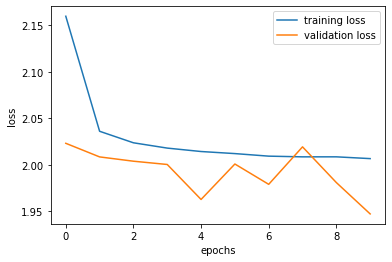

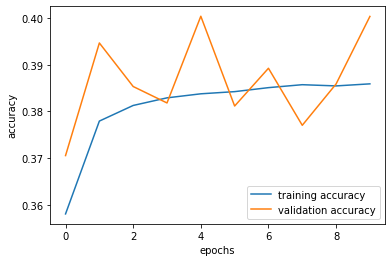

In [27]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.figure()
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')

## MSPECS

In [58]:
mspec_train_x = []
mspec_train_y = []

mspec_val_x = []
mspec_val_y = []

for train in training_data_mspec:
    mspec_train_x.extend(train['mspec'])
    mspec_train_y.extend(train['targets'])

for val in validation_data_mspec:
    mspec_val_x.extend(val['mspec'])
    mspec_val_y.extend(val['targets'])
    
mspec_train_x = np.array(mspec_train_x)
mspec_train_y = np.array(mspec_train_y)
mspec_val_x = np.array(mspec_val_x)
mspec_val_y = np.array(mspec_val_y)

In [59]:
mspec_train_x.shape

(1778403, 40)

In [60]:
mspec_train_x[100]

array([-1.76607087, -1.70403258, -1.64408661, -1.59518212, -1.84445561,
       -1.57111241, -1.41104751, -1.43150182, -1.37646212, -1.45427389,
       -1.43994499, -1.54446313, -1.68965317, -1.5008792 , -1.56586032,
       -1.66616256, -1.71821258, -1.64426662, -1.59469598, -1.54841113,
       -1.51498154, -1.42905199, -1.74246584, -2.01793904, -1.97144323,
       -1.50225825, -1.56551362, -1.70293884, -1.36209593, -1.63023658,
       -1.73177543, -1.47290484, -1.27532227, -1.3472705 , -1.35031647,
       -1.3044627 , -1.3698609 , -1.28316179, -1.15013966, -1.22816578])

In [61]:
print(mspec_train_x.shape, mspec_val_x.shape)
print(mspec_train_y.shape, mspec_val_y.shape)

(1778403, 40) (208453, 40)
(1778403,) (208453,)


In [62]:
from keras.utils import to_categorical
mspec_train_y = to_categorical(mspec_train_y, num_classes=40)
mspec_val_y = to_categorical(mspec_val_y, num_classes=40)

In [63]:
print(mspec_train_y.shape, mspec_val_y.shape)

(1778403, 40) (208453, 40)


In [64]:
train_X = mspec_train_x
train_y = mspec_train_y

val_X = mspec_val_x
val_y = mspec_val_y

In [65]:
train_X = train_X.astype('float32')
val_X = val_X.astype('float32')

In [69]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(256, input_shape=(1,train_X.shape[1])))
model.add(Dense(256))
model.add(Dense(256))
model.add(Dense(train_y.shape[1], activation="softmax"))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 1, 256)            10496     
_________________________________________________________________
dense_20 (Dense)             (None, 1, 256)            65792     
_________________________________________________________________
dense_21 (Dense)             (None, 1, 256)            65792     
_________________________________________________________________
dense_22 (Dense)             (None, 1, 40)             10280     
Total params: 152,360
Trainable params: 152,360
Non-trainable params: 0
_________________________________________________________________


In [70]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [71]:
history = model.fit(
    train_X, 
    train_y, 
    validation_data=(val_X, val_y), 
    epochs=10
)

Epoch 1/10
55576/55576 [==============================] - 78s 1ms/step - loss: 2.5510 - accuracy: 0.2542 - val_loss: 2.4262 - val_accuracy: 0.2656
Epoch 2/10
55576/55576 [==============================] - 80s 1ms/step - loss: 2.5028 - accuracy: 0.2673 - val_loss: 2.4175 - val_accuracy: 0.2704
Epoch 3/10
55576/55576 [==============================] - 78s 1ms/step - loss: 2.4975 - accuracy: 0.2688 - val_loss: 2.4013 - val_accuracy: 0.2833
Epoch 4/10
55576/55576 [==============================] - 81s 1ms/step - loss: 2.4933 - accuracy: 0.2695 - val_loss: 2.3904 - val_accuracy: 0.2902
Epoch 5/10
55576/55576 [==============================] - 79s 1ms/step - loss: 2.4928 - accuracy: 0.2708 - val_loss: 2.4169 - val_accuracy: 0.2799
Epoch 6/10
55576/55576 [==============================] - 79s 1ms/step - loss: 2.4924 - accuracy: 0.2707 - val_loss: 2.3974 - val_accuracy: 0.2905
Epoch 7/10
55576/55576 [==============================] - 79s 1ms/step - loss: 2.4923 - accuracy: 0.2708 - val_loss: 2

Text(0, 0.5, 'accuracy')

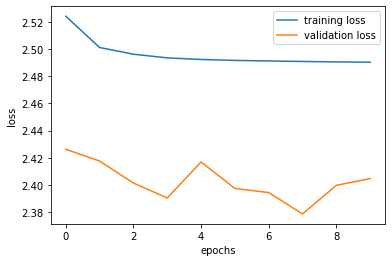

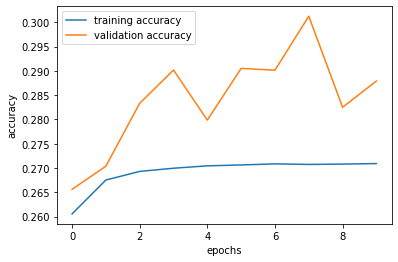

In [72]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.figure()
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')

## DYNAMIC LMFCC

In [ ]:
lmfcc_train_x = []
lmfcc_train_y = []

lmfcc_val_x = []
lmfcc_val_y = []

for train in training_data_lmfcc:
    lmfcc_train_x.extend(train['dynamic_lmfcc'])
    lmfcc_train_y.extend(train['targets'])

for val in validation_data_lmfcc:
    lmfcc_val_x.extend(val['dynamic_lmfcc'])
    lmfcc_val_y.extend(val['targets'])
    
lmfcc_train_x = np.array(lmfcc_train_x)
lmfcc_train_y = np.array(lmfcc_train_y)
lmfcc_train_y = np.reshape(lmfcc_train_y,(lmfcc_train_y.shape[0],1))
lmfcc_val_x = np.array(lmfcc_val_x)
lmfcc_val_y = np.array(lmfcc_val_y)
lmfcc_val_y = np.reshape(lmfcc_val_y,(lmfcc_val_y.shape[0],1))

In [ ]:
training_data_lmfcc[0]

In [ ]:
training_data_lmfcc[0]['dynamic_lmfcc'].shape

In [ ]:
print(lmfcc_train_x.shape, lmfcc_val_x.shape)

In [15]:
lmfcc_train_x.shape

(1778403, 7, 13)

In [16]:
lmfcc_train_y.shape

(1778403, 1)

In [17]:
from keras.utils import to_categorical
lmfcc_train_y = to_categorical(lmfcc_train_y, num_classes=len(stateList))
lmfcc_val_y = to_categorical(lmfcc_val_y, num_classes=len(stateList))

In [18]:
print(lmfcc_train_y.shape, lmfcc_val_y.shape)

(1778403, 61) (208453, 61)


In [19]:
train_X = lmfcc_train_x
train_y = lmfcc_train_y

val_X = lmfcc_val_x
val_y = lmfcc_val_y

In [20]:
np.argmax(train_y,axis=0)

array([   0,    1,   18,   19,   20,   21,   22,   23,   24,   25,   26,
         27,   28,   29,   30, 1049,   31,   32,   33,   34,   35,   36,
         44,   45,   46,  517,   47,   48,   49,   51,   52,   53,   54,
         55,   56, 9683,   59,   74,   88,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [21]:
train_X = train_X.astype('float32')
val_X = val_X.astype('float32')

In [22]:
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)

(1778403, 7, 13) (1778403, 61)
(208453, 7, 13) (208453, 61)


In [23]:
train_X = np.reshape(train_X,(train_X.shape[0], train_X.shape[1]*train_X.shape[2]))
val_X = np.reshape(val_X,(val_X.shape[0], val_X.shape[1]*val_X.shape[2]))
    
print(train_X.shape)
print(val_X.shape)

(1778403, 91)
(208453, 91)


In [24]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(1,train_X.shape[1])))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(train_y.shape[1], activation="softmax"))
# model.add(Dense(1, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 256)            23552     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 256)            65792     
_________________________________________________________________
dense_2 (Dense)              (None, 1, 256)            65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1, 61)             15677     
Total params: 170,813
Trainable params: 170,813
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [26]:
history = model.fit(
    train_X, 
    train_y, 
    validation_data=(val_X, val_y),
    epochs=10
)

Epoch 1/10
55576/55576 [==============================] - 85s 2ms/step - loss: 2.5677 - accuracy: 0.3316 - val_loss: 2.0231 - val_accuracy: 0.3705
Epoch 2/10
55576/55576 [==============================] - 83s 1ms/step - loss: 2.0371 - accuracy: 0.3776 - val_loss: 2.0085 - val_accuracy: 0.3946
Epoch 3/10
55576/55576 [==============================] - 83s 1ms/step - loss: 2.0245 - accuracy: 0.3808 - val_loss: 2.0039 - val_accuracy: 0.3853
Epoch 4/10
55576/55576 [==============================] - 87s 2ms/step - loss: 2.0186 - accuracy: 0.3830 - val_loss: 2.0003 - val_accuracy: 0.3818
Epoch 5/10
55576/55576 [==============================] - 83s 1ms/step - loss: 2.0120 - accuracy: 0.3848 - val_loss: 1.9628 - val_accuracy: 0.4004
Epoch 6/10
55576/55576 [==============================] - 85s 2ms/step - loss: 2.0119 - accuracy: 0.3844 - val_loss: 2.0008 - val_accuracy: 0.3812
Epoch 7/10
55576/55576 [==============================] - 86s 2ms/step - loss: 2.0087 - accuracy: 0.3853 - val_loss: 1

Text(0, 0.5, 'accuracy')

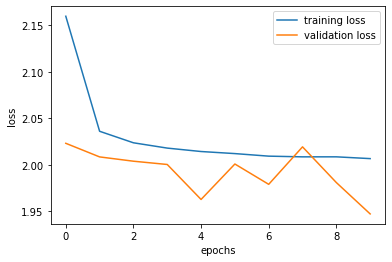

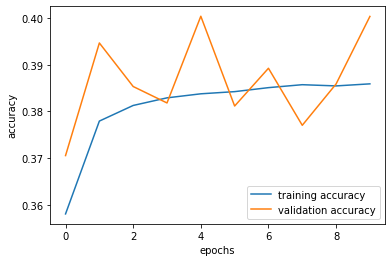

In [29]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.figure()
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')

In [30]:
model.save("my_model.pth")

INFO:tensorflow:Assets written to: my_model.pth/assets


## DYNAMIC MSPEC

In [11]:
mspec_train_x = []
mspec_train_y = []

mspec_val_x = []
mspec_val_y = []

for train in training_data_mspec:
    mspec_train_x.extend(train['dynamic_mspec'])
    mspec_train_y.extend(train['targets'])

for val in validation_data_mspec:
    mspec_val_x.extend(val['dynamic_mspec'])
    mspec_val_y.extend(val['targets'])
    
mspec_train_x = np.array(mspec_train_x)
mspec_train_y = np.array(mspec_train_y)
mspec_val_x = np.array(mspec_val_x)
mspec_val_y = np.array(mspec_val_y)

In [12]:
from keras.utils import to_categorical
mspec_train_y = to_categorical(mspec_train_y, num_classes=40)
mspec_val_y = to_categorical(mspec_val_y, num_classes=40)

In [13]:
train_X = mspec_train_x
train_y = mspec_train_y

val_X = mspec_val_x
val_y = mspec_val_y

In [14]:
train_X = train_X.astype('float32')
val_X = val_X.astype('float32')

In [15]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(256, input_shape=(1,train_X.shape[1])))
model.add(Dense(256))
model.add(Dense(256))
model.add(Dense(train_y.shape[1], activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 256)            2048      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 256)            65792     
_________________________________________________________________
dense_2 (Dense)              (None, 1, 256)            65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1, 40)             10280     
Total params: 143,912
Trainable params: 143,912
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [17]:
print(train_X.shape,train_y.shape)
print(val_X.shape,val_y.shape)

(1778403, 7, 40) (1778403, 40)
(208453, 7, 40) (208453, 40)


In [ ]:
history = model.fit(
    train_X, 
    train_y, 
    validation_data=(val_X, val_y), 
    epochs=10
)

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.figure()
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')

## EVALUATION

In [7]:
import keras
model = keras.models.load_model("my_model.pth")

In [8]:
testdata = np.load('testdata.npz', allow_pickle = True)
testdata = dict(zip(("{}".format(k) for k in testdata), (testdata[k] for k in testdata)))
# print(testdata)

In [9]:
testdata.keys()

dict_keys(['traindata'])

In [10]:
testing_data = [testdata['traindata'][i] for i in range(len(testdata['traindata']))]
testing_data[0]

{'filename': '/Users/nandakishorprabhu/Documents/Studies/DT2119/Code/DT2119-Speech-and-Speaker-Recognition/lab3/dt2119_lab3_2019-04-25/tidigits/disc_4.2.1/tidigits/test/man/pc/526883za.wav',
 'lmfcc': array([[  40.78833408, -113.42245743,   71.73723462, ..., -135.87046548,
           22.26148876,  193.06086707],
        [  38.43040144, -132.18093191,   59.52165261, ...,    6.98740784,
          -18.58998441,  -41.2040456 ],
        [  39.88472061, -128.44374882,   34.92649835, ...,   63.27948379,
           18.47432127,   71.39020211],
        ...,
        [ 135.48473782,  -21.72467126,   35.63692633, ...,  -64.96419378,
         -202.18652421, -149.15256732],
        [ 139.19355228,  -20.34755162,   26.17040143, ...,  174.58960626,
         -145.62428453,  -79.50119436],
        [ 162.0671351 ,  -11.66610685,  -29.09777682, ...,   15.77610568,
          -49.03791227,  -59.13381716]]),
 'mspec': array([[-1.717828  , -0.08248902, -0.21035894, ...,  1.79567459,
          2.32439584,  2.0

In [11]:
lmfcc_test_x = []
lmfcc_test_y = []

for test in testing_data:
    lmfcc_test_x.extend(test['lmfcc'])
    lmfcc_test_y.extend(test['targets'])
    
lmfcc_train_x = np.array(lmfcc_test_x)
lmfcc_train_y = np.array(lmfcc_test_y)

print(lmfcc_train_x.shape, lmfcc_train_y.shape)

(1527014, 13) (1527014,)


In [12]:
testdata['traindata'][3298]['filename'].split("/")

['',
 'Users',
 'nandakishorprabhu',
 'Documents',
 'Studies',
 'DT2119',
 'Code',
 'DT2119-Speech-and-Speaker-Recognition',
 'lab3',
 'dt2119_lab3_2019-04-25',
 'tidigits',
 'disc_4.2.1',
 'tidigits',
 'test',
 'man',
 'fg',
 '7z7z8a.wav']

In [13]:
test_wav_files = [testdata['traindata'][i] for i in range(len(testdata['traindata']))]

In [16]:
testing_data_lmfcc = dynamize_features(test_wav_files, 'lmfcc')

print("Original Features ", testing_data_lmfcc[0]["lmfcc"].shape)
print("Dynamic Features ", testing_data_lmfcc[0]['dynamic_lmfcc'].shape)

print("Total number of data points is", len(testing_data_lmfcc))

Original Features  (270, 13)
Dynamic Features  (270, 7, 13)
Total number of data points is 8700


In [17]:
lmfcc_test_x = []
lmfcc_test_y = []

for test in testing_data_lmfcc:
    lmfcc_test_x.extend(test['dynamic_lmfcc'])
    lmfcc_test_y.extend(test['targets'])
    
lmfcc_test_x = np.array(lmfcc_test_x)
lmfcc_test_y = np.array(lmfcc_test_y)

In [18]:
print(lmfcc_train_x.shape,lmfcc_train_y.shape)

(1527014, 13) (1527014,)


In [19]:
from keras.utils import to_categorical
lmfcc_test_y = to_categorical(lmfcc_test_y, num_classes=61)

In [20]:
lmfcc_test_x[0]

array([[  38.25255188, -128.72682916,   18.35936882,   20.93549206,
         141.09709603,  -49.69161421,  -76.29643605, -128.65418714,
        -125.14654836,   23.56944303,  -59.84469754, -106.53253432,
         -72.90222196],
       [  39.88472061, -128.44374882,   34.92649835,   71.15518782,
          36.51768482,   -6.7890172 , -142.77338888, -161.30123619,
        -161.5204932 , -119.24315937,   63.27948379,   18.47432127,
          71.39020211],
       [  38.43040144, -132.18093191,   59.52165261,   43.28159919,
          34.62256279,   19.64056884, -143.35207223, -103.59890037,
        -145.94786606,  -78.33421454,    6.98740784,  -18.58998441,
         -41.2040456 ],
       [  40.78833408, -113.42245743,   71.73723462,  -54.3395144 ,
         -15.85027844,   95.90848785,  -41.9289243 , -169.42494439,
        -104.86596929,  -59.52791152, -135.87046548,   22.26148876,
         193.06086707],
       [  38.43040144, -132.18093191,   59.52165261,   43.28159919,
          34.6225627

In [25]:
test_X = lmfcc_test_x
test_y = lmfcc_test_y

In [26]:
print(test_X.shape,test_y.shape)

(1527014, 7, 13) (1527014, 61)


In [27]:
test_X = np.reshape(test_X,(test_X.shape[0], test_X.shape[1]*test_X.shape[2]))
    
print(test_X.shape)

(1527014, 91)


In [28]:
preds = model.predict(test_X)

[[ 19508   1776   5995 ...   5206    460      0]
 [  1763 116254   7059 ...    271   3211      0]
 [  4058  18034  52187 ...   2674    529     69]
 ...
 [  3812    340   3876 ...  53690    448    120]
 [  2600  25457   1152 ...   1121   9347      1]
 [  1119   3650   2109 ...   4301   1110   1099]]


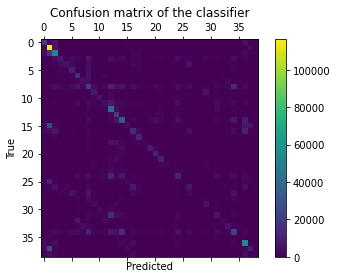

In [102]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# labels = ['business', 'health']
cm = confusion_matrix(truth, args)#, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## EVAL 1

In [34]:
args = np.argmax(preds,axis=1)
truth = np.argmax(test_y,axis=1)
correct = sum(args==truth)
print(f"The total number of corrects is {correct} out of {len(args)}")
print("The accuracy is",correct/len(args))

The total number of corrects is 554772 out of 1527014
The accuracy is 0.3633051170454233


## EVAL 2

In [41]:
indexes = {i:[] for i in range(61)}
for index,value in enumerate(truth):
    indexes[value].append(index)

In [43]:
counts = {i:0 for i in range(61)}
accuracies = {i:0 for i in range(61)}

for key,val in indexes.items():
    count = sum(args[val]==truth[val])
    try:acc = count/len(val)
    except: acc = 0
    counts[key] = count
    accuracies[key] = acc

In [44]:
counts

{0: 19508,
 1: 116254,
 2: 52187,
 3: 7537,
 4: 5664,
 5: 9082,
 6: 16332,
 7: 5286,
 8: 20306,
 9: 7697,
 10: 6132,
 11: 4476,
 12: 39536,
 13: 20089,
 14: 32672,
 15: 3895,
 16: 13679,
 17: 11618,
 18: 1842,
 19: 8067,
 20: 10878,
 21: 10264,
 22: 2112,
 23: 913,
 24: 12145,
 25: 4,
 26: 6751,
 27: 7,
 28: 1220,
 29: 5647,
 30: 639,
 31: 6481,
 32: 2699,
 33: 6014,
 34: 22906,
 35: 97,
 36: 53690,
 37: 9347,
 38: 1099,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0}

In [45]:
accuracies

{0: 0.5647944412275623,
 1: 0.8986858379715522,
 2: 0.6200042769567077,
 3: 0.1283199400708254,
 4: 0.21132751287217372,
 5: 0.42514745810317384,
 6: 0.5276727730929534,
 7: 0.2849134910796098,
 8: 0.17284497067610932,
 9: 0.31421456564337036,
 10: 0.35680204817875016,
 11: 0.09752058913242408,
 12: 0.6938574938574938,
 13: 0.6328240667821704,
 14: 0.38925358908679336,
 15: 0.07829145728643216,
 16: 0.246038455312337,
 17: 0.6269156054392402,
 18: 0.08455747337495409,
 19: 0.4633810098225056,
 20: 0.5559928443649373,
 21: 0.5118946685950826,
 22: 0.1870847727876694,
 23: 0.08147421024451187,
 24: 0.19746362084383384,
 25: 0.00023226106143305075,
 26: 0.16698822598199267,
 27: 0.0002278126728935464,
 28: 0.07001836547291093,
 29: 0.3077719642467844,
 30: 0.05259692155732982,
 31: 0.14650300646503006,
 32: 0.15974195075757575,
 33: 0.374727397345629,
 34: 0.22138673573927667,
 35: 0.02967268277760783,
 36: 0.7121728634150871,
 37: 0.21603568622012667,
 38: 0.05706719285491744,
 39: 0,
 4

## EVAL 3

In [88]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            print(i2,i1)
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [89]:
truth

array([ 0,  1,  1, ..., 37, 37, 37])

In [90]:
removed_duplicates_pr = [v for i, v in enumerate(args) if i == 0 or v != args[i-1]]
removed_duplicates_gt = [v for i, v in enumerate(truth) if i == 0 or v != truth[i-1]]

In [91]:
levenshteinDistance(removed_duplicates_gt,removed_duplicates_pr)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


0 1681
0 1682
0 1683
0 1684
0 1685
0 1686
0 1687
0 1688
0 1689
0 1690
0 1691
0 1692
0 1693
0 1694
0 1695
0 1696
0 1697
0 1698
0 1699
0 1700
0 1701
0 1702
0 1703
0 1704
0 1705
0 1706
0 1707
0 1708
0 1709
0 1710
0 1711
0 1712
0 1713
0 1714
0 1715
0 1716
0 1717
0 1718
0 1719
0 1720
0 1721
0 1722
0 1723
0 1724
0 1725
0 1726
0 1727
0 1728
0 1729
0 1730
0 1731
0 1732
0 1733
0 1734
0 1735
0 1736
0 1737
0 1738
0 1739
0 1740
0 1741
0 1742
0 1743
0 1744
0 1745
0 1746
0 1747
0 1748
0 1749
0 1750
0 1751
0 1752
0 1753
0 1754
0 1755
0 1756
0 1757
0 1758
0 1759
0 1760
0 1761
0 1762
0 1763
0 1764
0 1765
0 1766
0 1767
0 1768
0 1769
0 1770
0 1771
0 1772
0 1773
0 1774
0 1775
0 1776
0 1777
0 1778
0 1779
0 1780
0 1781
0 1782
0 1783
0 1784
0 1785
0 1786
0 1787
0 1788
0 1789
0 1790
0 1791
0 1792
0 1793
0 1794
0 1795
0 1796
0 1797
0 1798
0 1799
0 1800
0 1801
0 1802
0 1803
0 1804
0 1805
0 1806
0 1807
0 1808
0 1809
0 1810
0 1811
0 1812
0 1813
0 1814
0 1815
0 1816
0 1817
0 1818
0 1819
0 1820
0 1821
0 1822
0 1823

0 3043
0 3044
0 3045
0 3046
0 3047
0 3048
0 3049
0 3050
0 3051
0 3052
0 3053
0 3054
0 3055
0 3056
0 3057
0 3058
0 3059
0 3060
0 3061
0 3062
0 3063
0 3064
0 3065
0 3066
0 3067
0 3068
0 3069
0 3070
0 3071
0 3072
0 3073
0 3074
0 3075
0 3076
0 3077
0 3078
0 3079
0 3080
0 3081
0 3082
0 3083
0 3084
0 3085
0 3086
0 3087
0 3088
0 3089
0 3090
0 3091
0 3092
0 3093
0 3094
0 3095
0 3096
0 3097
0 3098
0 3099
0 3100
0 3101
0 3102
0 3103
0 3104
0 3105
0 3106
0 3107
0 3108
0 3109
0 3110
0 3111
0 3112
0 3113
0 3114
0 3115
0 3116
0 3117
0 3118
0 3119
0 3120
0 3121
0 3122
0 3123
0 3124
0 3125
0 3126
0 3127
0 3128
0 3129
0 3130
0 3131
0 3132
0 3133
0 3134
0 3135
0 3136
0 3137
0 3138
0 3139
0 3140
0 3141
0 3142
0 3143
0 3144
0 3145
0 3146
0 3147
0 3148
0 3149
0 3150
0 3151
0 3152
0 3153
0 3154
0 3155
0 3156
0 3157
0 3158
0 3159
0 3160
0 3161
0 3162
0 3163
0 3164
0 3165
0 3166
0 3167
0 3168
0 3169
0 3170
0 3171
0 3172
0 3173
0 3174
0 3175
0 3176
0 3177
0 3178
0 3179
0 3180
0 3181
0 3182
0 3183
0 3184
0 3185

0 4565
0 4566
0 4567
0 4568
0 4569
0 4570
0 4571
0 4572
0 4573
0 4574
0 4575
0 4576
0 4577
0 4578
0 4579
0 4580
0 4581
0 4582
0 4583
0 4584
0 4585
0 4586
0 4587
0 4588
0 4589
0 4590
0 4591
0 4592
0 4593
0 4594
0 4595
0 4596
0 4597
0 4598
0 4599
0 4600
0 4601
0 4602
0 4603
0 4604
0 4605
0 4606
0 4607
0 4608
0 4609
0 4610
0 4611
0 4612
0 4613
0 4614
0 4615
0 4616
0 4617
0 4618
0 4619
0 4620
0 4621
0 4622
0 4623
0 4624
0 4625
0 4626
0 4627
0 4628
0 4629
0 4630
0 4631
0 4632
0 4633
0 4634
0 4635
0 4636
0 4637
0 4638
0 4639
0 4640
0 4641
0 4642
0 4643
0 4644
0 4645
0 4646
0 4647
0 4648
0 4649
0 4650
0 4651
0 4652
0 4653
0 4654
0 4655
0 4656
0 4657
0 4658
0 4659
0 4660
0 4661
0 4662
0 4663
0 4664
0 4665
0 4666
0 4667
0 4668
0 4669
0 4670
0 4671
0 4672
0 4673
0 4674
0 4675
0 4676
0 4677
0 4678
0 4679
0 4680
0 4681
0 4682
0 4683
0 4684
0 4685
0 4686
0 4687
0 4688
0 4689
0 4690
0 4691
0 4692
0 4693
0 4694
0 4695
0 4696
0 4697
0 4698
0 4699
0 4700
0 4701
0 4702
0 4703
0 4704
0 4705
0 4706
0 4707

0 5998
0 5999
0 6000
0 6001
0 6002
0 6003
0 6004
0 6005
0 6006
0 6007
0 6008
0 6009
0 6010
0 6011
0 6012
0 6013
0 6014
0 6015
0 6016
0 6017
0 6018
0 6019
0 6020
0 6021
0 6022
0 6023
0 6024
0 6025
0 6026
0 6027
0 6028
0 6029
0 6030
0 6031
0 6032
0 6033
0 6034
0 6035
0 6036
0 6037
0 6038
0 6039
0 6040
0 6041
0 6042
0 6043
0 6044
0 6045
0 6046
0 6047
0 6048
0 6049
0 6050
0 6051
0 6052
0 6053
0 6054
0 6055
0 6056
0 6057
0 6058
0 6059
0 6060
0 6061
0 6062
0 6063
0 6064
0 6065
0 6066
0 6067
0 6068
0 6069
0 6070
0 6071
0 6072
0 6073
0 6074
0 6075
0 6076
0 6077
0 6078
0 6079
0 6080
0 6081
0 6082
0 6083
0 6084
0 6085
0 6086
0 6087
0 6088
0 6089
0 6090
0 6091
0 6092
0 6093
0 6094
0 6095
0 6096
0 6097
0 6098
0 6099
0 6100
0 6101
0 6102
0 6103
0 6104
0 6105
0 6106
0 6107
0 6108
0 6109
0 6110
0 6111
0 6112
0 6113
0 6114
0 6115
0 6116
0 6117
0 6118
0 6119
0 6120
0 6121
0 6122
0 6123
0 6124
0 6125
0 6126
0 6127
0 6128
0 6129
0 6130
0 6131
0 6132
0 6133
0 6134
0 6135
0 6136
0 6137
0 6138
0 6139
0 6140

0 7614
0 7615
0 7616
0 7617
0 7618
0 7619
0 7620
0 7621
0 7622
0 7623
0 7624
0 7625
0 7626
0 7627
0 7628
0 7629
0 7630
0 7631
0 7632
0 7633
0 7634
0 7635
0 7636
0 7637
0 7638
0 7639
0 7640
0 7641
0 7642
0 7643
0 7644
0 7645
0 7646
0 7647
0 7648
0 7649
0 7650
0 7651
0 7652
0 7653
0 7654
0 7655
0 7656
0 7657
0 7658
0 7659
0 7660
0 7661
0 7662
0 7663
0 7664
0 7665
0 7666
0 7667
0 7668
0 7669
0 7670
0 7671
0 7672
0 7673
0 7674
0 7675
0 7676
0 7677
0 7678
0 7679
0 7680
0 7681
0 7682
0 7683
0 7684
0 7685
0 7686
0 7687
0 7688
0 7689
0 7690
0 7691
0 7692
0 7693
0 7694
0 7695
0 7696
0 7697
0 7698
0 7699
0 7700
0 7701
0 7702
0 7703
0 7704
0 7705
0 7706
0 7707
0 7708
0 7709
0 7710
0 7711
0 7712
0 7713
0 7714
0 7715
0 7716
0 7717
0 7718
0 7719
0 7720
0 7721
0 7722
0 7723
0 7724
0 7725
0 7726
0 7727
0 7728
0 7729
0 7730
0 7731
0 7732
0 7733
0 7734
0 7735
0 7736
0 7737
0 7738
0 7739
0 7740
0 7741
0 7742
0 7743
0 7744
0 7745
0 7746
0 7747
0 7748
0 7749
0 7750
0 7751
0 7752
0 7753
0 7754
0 7755
0 7756

0 9248
0 9249
0 9250
0 9251
0 9252
0 9253
0 9254
0 9255
0 9256
0 9257
0 9258
0 9259
0 9260
0 9261
0 9262
0 9263
0 9264
0 9265
0 9266
0 9267
0 9268
0 9269
0 9270
0 9271
0 9272
0 9273
0 9274
0 9275
0 9276
0 9277
0 9278
0 9279
0 9280
0 9281
0 9282
0 9283
0 9284
0 9285
0 9286
0 9287
0 9288
0 9289
0 9290
0 9291
0 9292
0 9293
0 9294
0 9295
0 9296
0 9297
0 9298
0 9299
0 9300
0 9301
0 9302
0 9303
0 9304
0 9305
0 9306
0 9307
0 9308
0 9309
0 9310
0 9311
0 9312
0 9313
0 9314
0 9315
0 9316
0 9317
0 9318
0 9319
0 9320
0 9321
0 9322
0 9323
0 9324
0 9325
0 9326
0 9327
0 9328
0 9329
0 9330
0 9331
0 9332
0 9333
0 9334
0 9335
0 9336
0 9337
0 9338
0 9339
0 9340
0 9341
0 9342
0 9343
0 9344
0 9345
0 9346
0 9347
0 9348
0 9349
0 9350
0 9351
0 9352
0 9353
0 9354
0 9355
0 9356
0 9357
0 9358
0 9359
0 9360
0 9361
0 9362
0 9363
0 9364
0 9365
0 9366
0 9367
0 9368
0 9369
0 9370
0 9371
0 9372
0 9373
0 9374
0 9375
0 9376
0 9377
0 9378
0 9379
0 9380
0 9381
0 9382
0 9383
0 9384
0 9385
0 9386
0 9387
0 9388
0 9389
0 9390

0 10528
0 10529
0 10530
0 10531
0 10532
0 10533
0 10534
0 10535
0 10536
0 10537
0 10538
0 10539
0 10540
0 10541
0 10542
0 10543
0 10544
0 10545
0 10546
0 10547
0 10548
0 10549
0 10550
0 10551
0 10552
0 10553
0 10554
0 10555
0 10556
0 10557
0 10558
0 10559
0 10560
0 10561
0 10562
0 10563
0 10564
0 10565
0 10566
0 10567
0 10568
0 10569
0 10570
0 10571
0 10572
0 10573
0 10574
0 10575
0 10576
0 10577
0 10578
0 10579
0 10580
0 10581
0 10582
0 10583
0 10584
0 10585
0 10586
0 10587
0 10588
0 10589
0 10590
0 10591
0 10592
0 10593
0 10594
0 10595
0 10596
0 10597
0 10598
0 10599
0 10600
0 10601
0 10602
0 10603
0 10604
0 10605
0 10606
0 10607
0 10608
0 10609
0 10610
0 10611
0 10612
0 10613
0 10614
0 10615
0 10616
0 10617
0 10618
0 10619
0 10620
0 10621
0 10622
0 10623
0 10624
0 10625
0 10626
0 10627
0 10628
0 10629
0 10630
0 10631
0 10632
0 10633
0 10634
0 10635
0 10636
0 10637
0 10638
0 10639
0 10640
0 10641
0 10642
0 10643
0 10644
0 10645
0 10646
0 10647
0 10648
0 10649
0 10650
0 10651
0 10652


0 12084
0 12085
0 12086
0 12087
0 12088
0 12089
0 12090
0 12091
0 12092
0 12093
0 12094
0 12095
0 12096
0 12097
0 12098
0 12099
0 12100
0 12101
0 12102
0 12103
0 12104
0 12105
0 12106
0 12107
0 12108
0 12109
0 12110
0 12111
0 12112
0 12113
0 12114
0 12115
0 12116
0 12117
0 12118
0 12119
0 12120
0 12121
0 12122
0 12123
0 12124
0 12125
0 12126
0 12127
0 12128
0 12129
0 12130
0 12131
0 12132
0 12133
0 12134
0 12135
0 12136
0 12137
0 12138
0 12139
0 12140
0 12141
0 12142
0 12143
0 12144
0 12145
0 12146
0 12147
0 12148
0 12149
0 12150
0 12151
0 12152
0 12153
0 12154
0 12155
0 12156
0 12157
0 12158
0 12159
0 12160
0 12161
0 12162
0 12163
0 12164
0 12165
0 12166
0 12167
0 12168
0 12169
0 12170
0 12171
0 12172
0 12173
0 12174
0 12175
0 12176
0 12177
0 12178
0 12179
0 12180
0 12181
0 12182
0 12183
0 12184
0 12185
0 12186
0 12187
0 12188
0 12189
0 12190
0 12191
0 12192
0 12193
0 12194
0 12195
0 12196
0 12197
0 12198
0 12199
0 12200
0 12201
0 12202
0 12203
0 12204
0 12205
0 12206
0 12207
0 12208


0 13803
0 13804
0 13805
0 13806
0 13807
0 13808
0 13809
0 13810
0 13811
0 13812
0 13813
0 13814
0 13815
0 13816
0 13817
0 13818
0 13819
0 13820
0 13821
0 13822
0 13823
0 13824
0 13825
0 13826
0 13827
0 13828
0 13829
0 13830
0 13831
0 13832
0 13833
0 13834
0 13835
0 13836
0 13837
0 13838
0 13839
0 13840
0 13841
0 13842
0 13843
0 13844
0 13845
0 13846
0 13847
0 13848
0 13849
0 13850
0 13851
0 13852
0 13853
0 13854
0 13855
0 13856
0 13857
0 13858
0 13859
0 13860
0 13861
0 13862
0 13863
0 13864
0 13865
0 13866
0 13867
0 13868
0 13869
0 13870
0 13871
0 13872
0 13873
0 13874
0 13875
0 13876
0 13877
0 13878
0 13879
0 13880
0 13881
0 13882
0 13883
0 13884
0 13885
0 13886
0 13887
0 13888
0 13889
0 13890
0 13891
0 13892
0 13893
0 13894
0 13895
0 13896
0 13897
0 13898
0 13899
0 13900
0 13901
0 13902
0 13903
0 13904
0 13905
0 13906
0 13907
0 13908
0 13909
0 13910
0 13911
0 13912
0 13913
0 13914
0 13915
0 13916
0 13917
0 13918
0 13919
0 13920
0 13921
0 13922
0 13923
0 13924
0 13925
0 13926
0 13927


0 15544
0 15545
0 15546
0 15547
0 15548
0 15549
0 15550
0 15551
0 15552
0 15553
0 15554
0 15555
0 15556
0 15557
0 15558
0 15559
0 15560
0 15561
0 15562
0 15563
0 15564
0 15565
0 15566
0 15567
0 15568
0 15569
0 15570
0 15571
0 15572
0 15573
0 15574
0 15575
0 15576
0 15577
0 15578
0 15579
0 15580
0 15581
0 15582
0 15583
0 15584
0 15585
0 15586
0 15587
0 15588
0 15589
0 15590
0 15591
0 15592
0 15593
0 15594
0 15595
0 15596
0 15597
0 15598
0 15599
0 15600
0 15601
0 15602
0 15603
0 15604
0 15605
0 15606
0 15607
0 15608
0 15609
0 15610
0 15611
0 15612
0 15613
0 15614
0 15615
0 15616
0 15617
0 15618
0 15619
0 15620
0 15621
0 15622
0 15623
0 15624
0 15625
0 15626
0 15627
0 15628
0 15629
0 15630
0 15631
0 15632
0 15633
0 15634
0 15635
0 15636
0 15637
0 15638
0 15639
0 15640
0 15641
0 15642
0 15643
0 15644
0 15645
0 15646
0 15647
0 15648
0 15649
0 15650
0 15651
0 15652
0 15653
0 15654
0 15655
0 15656
0 15657
0 15658
0 15659
0 15660
0 15661
0 15662
0 15663
0 15664
0 15665
0 15666
0 15667
0 15668


0 17147
0 17148
0 17149
0 17150
0 17151
0 17152
0 17153
0 17154
0 17155
0 17156
0 17157
0 17158
0 17159
0 17160
0 17161
0 17162
0 17163
0 17164
0 17165
0 17166
0 17167
0 17168
0 17169
0 17170
0 17171
0 17172
0 17173
0 17174
0 17175
0 17176
0 17177
0 17178
0 17179
0 17180
0 17181
0 17182
0 17183
0 17184
0 17185
0 17186
0 17187
0 17188
0 17189
0 17190
0 17191
0 17192
0 17193
0 17194
0 17195
0 17196
0 17197
0 17198
0 17199
0 17200
0 17201
0 17202
0 17203
0 17204
0 17205
0 17206
0 17207
0 17208
0 17209
0 17210
0 17211
0 17212
0 17213
0 17214
0 17215
0 17216
0 17217
0 17218
0 17219
0 17220
0 17221
0 17222
0 17223
0 17224
0 17225
0 17226
0 17227
0 17228
0 17229
0 17230
0 17231
0 17232
0 17233
0 17234
0 17235
0 17236
0 17237
0 17238
0 17239
0 17240
0 17241
0 17242
0 17243
0 17244
0 17245
0 17246
0 17247
0 17248
0 17249
0 17250
0 17251
0 17252
0 17253
0 17254
0 17255
0 17256
0 17257
0 17258
0 17259
0 17260
0 17261
0 17262
0 17263
0 17264
0 17265
0 17266
0 17267
0 17268
0 17269
0 17270
0 17271


0 18765
0 18766
0 18767
0 18768
0 18769
0 18770
0 18771
0 18772
0 18773
0 18774
0 18775
0 18776
0 18777
0 18778
0 18779
0 18780
0 18781
0 18782
0 18783
0 18784
0 18785
0 18786
0 18787
0 18788
0 18789
0 18790
0 18791
0 18792
0 18793
0 18794
0 18795
0 18796
0 18797
0 18798
0 18799
0 18800
0 18801
0 18802
0 18803
0 18804
0 18805
0 18806
0 18807
0 18808
0 18809
0 18810
0 18811
0 18812
0 18813
0 18814
0 18815
0 18816
0 18817
0 18818
0 18819
0 18820
0 18821
0 18822
0 18823
0 18824
0 18825
0 18826
0 18827
0 18828
0 18829
0 18830
0 18831
0 18832
0 18833
0 18834
0 18835
0 18836
0 18837
0 18838
0 18839
0 18840
0 18841
0 18842
0 18843
0 18844
0 18845
0 18846
0 18847
0 18848
0 18849
0 18850
0 18851
0 18852
0 18853
0 18854
0 18855
0 18856
0 18857
0 18858
0 18859
0 18860
0 18861
0 18862
0 18863
0 18864
0 18865
0 18866
0 18867
0 18868
0 18869
0 18870
0 18871
0 18872
0 18873
0 18874
0 18875
0 18876
0 18877
0 18878
0 18879
0 18880
0 18881
0 18882
0 18883
0 18884
0 18885
0 18886
0 18887
0 18888
0 18889


0 20236
0 20237
0 20238
0 20239
0 20240
0 20241
0 20242
0 20243
0 20244
0 20245
0 20246
0 20247
0 20248
0 20249
0 20250
0 20251
0 20252
0 20253
0 20254
0 20255
0 20256
0 20257
0 20258
0 20259
0 20260
0 20261
0 20262
0 20263
0 20264
0 20265
0 20266
0 20267
0 20268
0 20269
0 20270
0 20271
0 20272
0 20273
0 20274
0 20275
0 20276
0 20277
0 20278
0 20279
0 20280
0 20281
0 20282
0 20283
0 20284
0 20285
0 20286
0 20287
0 20288
0 20289
0 20290
0 20291
0 20292
0 20293
0 20294
0 20295
0 20296
0 20297
0 20298
0 20299
0 20300
0 20301
0 20302
0 20303
0 20304
0 20305
0 20306
0 20307
0 20308
0 20309
0 20310
0 20311
0 20312
0 20313
0 20314
0 20315
0 20316
0 20317
0 20318
0 20319
0 20320
0 20321
0 20322
0 20323
0 20324
0 20325
0 20326
0 20327
0 20328
0 20329
0 20330
0 20331
0 20332
0 20333
0 20334
0 20335
0 20336
0 20337
0 20338
0 20339
0 20340
0 20341
0 20342
0 20343
0 20344
0 20345
0 20346
0 20347
0 20348
0 20349
0 20350
0 20351
0 20352
0 20353
0 20354
0 20355
0 20356
0 20357
0 20358
0 20359
0 20360


0 21863
0 21864
0 21865
0 21866
0 21867
0 21868
0 21869
0 21870
0 21871
0 21872
0 21873
0 21874
0 21875
0 21876
0 21877
0 21878
0 21879
0 21880
0 21881
0 21882
0 21883
0 21884
0 21885
0 21886
0 21887
0 21888
0 21889
0 21890
0 21891
0 21892
0 21893
0 21894
0 21895
0 21896
0 21897
0 21898
0 21899
0 21900
0 21901
0 21902
0 21903
0 21904
0 21905
0 21906
0 21907
0 21908
0 21909
0 21910
0 21911
0 21912
0 21913
0 21914
0 21915
0 21916
0 21917
0 21918
0 21919
0 21920
0 21921
0 21922
0 21923
0 21924
0 21925
0 21926
0 21927
0 21928
0 21929
0 21930
0 21931
0 21932
0 21933
0 21934
0 21935
0 21936
0 21937
0 21938
0 21939
0 21940
0 21941
0 21942
0 21943
0 21944
0 21945
0 21946
0 21947
0 21948
0 21949
0 21950
0 21951
0 21952
0 21953
0 21954
0 21955
0 21956
0 21957
0 21958
0 21959
0 21960
0 21961
0 21962
0 21963
0 21964
0 21965
0 21966
0 21967
0 21968
0 21969
0 21970
0 21971
0 21972
0 21973
0 21974
0 21975
0 21976
0 21977
0 21978
0 21979
0 21980
0 21981
0 21982
0 21983
0 21984
0 21985
0 21986
0 21987


0 23518
0 23519
0 23520
0 23521
0 23522
0 23523
0 23524
0 23525
0 23526
0 23527
0 23528
0 23529
0 23530
0 23531
0 23532
0 23533
0 23534
0 23535
0 23536
0 23537
0 23538
0 23539
0 23540
0 23541
0 23542
0 23543
0 23544
0 23545
0 23546
0 23547
0 23548
0 23549
0 23550
0 23551
0 23552
0 23553
0 23554
0 23555
0 23556
0 23557
0 23558
0 23559
0 23560
0 23561
0 23562
0 23563
0 23564
0 23565
0 23566
0 23567
0 23568
0 23569
0 23570
0 23571
0 23572
0 23573
0 23574
0 23575
0 23576
0 23577
0 23578
0 23579
0 23580
0 23581
0 23582
0 23583
0 23584
0 23585
0 23586
0 23587
0 23588
0 23589
0 23590
0 23591
0 23592
0 23593
0 23594
0 23595
0 23596
0 23597
0 23598
0 23599
0 23600
0 23601
0 23602
0 23603
0 23604
0 23605
0 23606
0 23607
0 23608
0 23609
0 23610
0 23611
0 23612
0 23613
0 23614
0 23615
0 23616
0 23617
0 23618
0 23619
0 23620
0 23621
0 23622
0 23623
0 23624
0 23625
0 23626
0 23627
0 23628
0 23629
0 23630
0 23631
0 23632
0 23633
0 23634
0 23635
0 23636
0 23637
0 23638
0 23639
0 23640
0 23641
0 23642


0 25132
0 25133
0 25134
0 25135
0 25136
0 25137
0 25138
0 25139
0 25140
0 25141
0 25142
0 25143
0 25144
0 25145
0 25146
0 25147
0 25148
0 25149
0 25150
0 25151
0 25152
0 25153
0 25154
0 25155
0 25156
0 25157
0 25158
0 25159
0 25160
0 25161
0 25162
0 25163
0 25164
0 25165
0 25166
0 25167
0 25168
0 25169
0 25170
0 25171
0 25172
0 25173
0 25174
0 25175
0 25176
0 25177
0 25178
0 25179
0 25180
0 25181
0 25182
0 25183
0 25184
0 25185
0 25186
0 25187
0 25188
0 25189
0 25190
0 25191
0 25192
0 25193
0 25194
0 25195
0 25196
0 25197
0 25198
0 25199
0 25200
0 25201
0 25202
0 25203
0 25204
0 25205
0 25206
0 25207
0 25208
0 25209
0 25210
0 25211
0 25212
0 25213
0 25214
0 25215
0 25216
0 25217
0 25218
0 25219
0 25220
0 25221
0 25222
0 25223
0 25224
0 25225
0 25226
0 25227
0 25228
0 25229
0 25230
0 25231
0 25232
0 25233
0 25234
0 25235
0 25236
0 25237
0 25238
0 25239
0 25240
0 25241
0 25242
0 25243
0 25244
0 25245
0 25246
0 25247
0 25248
0 25249
0 25250
0 25251
0 25252
0 25253
0 25254
0 25255
0 25256


0 26490
0 26491
0 26492
0 26493
0 26494
0 26495
0 26496
0 26497
0 26498
0 26499
0 26500
0 26501
0 26502
0 26503
0 26504
0 26505
0 26506
0 26507
0 26508
0 26509
0 26510
0 26511
0 26512
0 26513
0 26514
0 26515
0 26516
0 26517
0 26518
0 26519
0 26520
0 26521
0 26522
0 26523
0 26524
0 26525
0 26526
0 26527
0 26528
0 26529
0 26530
0 26531
0 26532
0 26533
0 26534
0 26535
0 26536
0 26537
0 26538
0 26539
0 26540
0 26541
0 26542
0 26543
0 26544
0 26545
0 26546
0 26547
0 26548
0 26549
0 26550
0 26551
0 26552
0 26553
0 26554
0 26555
0 26556
0 26557
0 26558
0 26559
0 26560
0 26561
0 26562
0 26563
0 26564
0 26565
0 26566
0 26567
0 26568
0 26569
0 26570
0 26571
0 26572
0 26573
0 26574
0 26575
0 26576
0 26577
0 26578
0 26579
0 26580
0 26581
0 26582
0 26583
0 26584
0 26585
0 26586
0 26587
0 26588
0 26589
0 26590
0 26591
0 26592
0 26593
0 26594
0 26595
0 26596
0 26597
0 26598
0 26599
0 26600
0 26601
0 26602
0 26603
0 26604
0 26605
0 26606
0 26607
0 26608
0 26609
0 26610
0 26611
0 26612
0 26613
0 26614


0 28034
0 28035
0 28036
0 28037
0 28038
0 28039
0 28040
0 28041
0 28042
0 28043
0 28044
0 28045
0 28046
0 28047
0 28048
0 28049
0 28050
0 28051
0 28052
0 28053
0 28054
0 28055
0 28056
0 28057
0 28058
0 28059
0 28060
0 28061
0 28062
0 28063
0 28064
0 28065
0 28066
0 28067
0 28068
0 28069
0 28070
0 28071
0 28072
0 28073
0 28074
0 28075
0 28076
0 28077
0 28078
0 28079
0 28080
0 28081
0 28082
0 28083
0 28084
0 28085
0 28086
0 28087
0 28088
0 28089
0 28090
0 28091
0 28092
0 28093
0 28094
0 28095
0 28096
0 28097
0 28098
0 28099
0 28100
0 28101
0 28102
0 28103
0 28104
0 28105
0 28106
0 28107
0 28108
0 28109
0 28110
0 28111
0 28112
0 28113
0 28114
0 28115
0 28116
0 28117
0 28118
0 28119
0 28120
0 28121
0 28122
0 28123
0 28124
0 28125
0 28126
0 28127
0 28128
0 28129
0 28130
0 28131
0 28132
0 28133
0 28134
0 28135
0 28136
0 28137
0 28138
0 28139
0 28140
0 28141
0 28142
0 28143
0 28144
0 28145
0 28146
0 28147
0 28148
0 28149
0 28150
0 28151
0 28152
0 28153
0 28154
0 28155
0 28156
0 28157
0 28158


0 29617
0 29618
0 29619
0 29620
0 29621
0 29622
0 29623
0 29624
0 29625
0 29626
0 29627
0 29628
0 29629
0 29630
0 29631
0 29632
0 29633
0 29634
0 29635
0 29636
0 29637
0 29638
0 29639
0 29640
0 29641
0 29642
0 29643
0 29644
0 29645
0 29646
0 29647
0 29648
0 29649
0 29650
0 29651
0 29652
0 29653
0 29654
0 29655
0 29656
0 29657
0 29658
0 29659
0 29660
0 29661
0 29662
0 29663
0 29664
0 29665
0 29666
0 29667
0 29668
0 29669
0 29670
0 29671
0 29672
0 29673
0 29674
0 29675
0 29676
0 29677
0 29678
0 29679
0 29680
0 29681
0 29682
0 29683
0 29684
0 29685
0 29686
0 29687
0 29688
0 29689
0 29690
0 29691
0 29692
0 29693
0 29694
0 29695
0 29696
0 29697
0 29698
0 29699
0 29700
0 29701
0 29702
0 29703
0 29704
0 29705
0 29706
0 29707
0 29708
0 29709
0 29710
0 29711
0 29712
0 29713
0 29714
0 29715
0 29716
0 29717
0 29718
0 29719
0 29720
0 29721
0 29722
0 29723
0 29724
0 29725
0 29726
0 29727
0 29728
0 29729
0 29730
0 29731
0 29732
0 29733
0 29734
0 29735
0 29736
0 29737
0 29738
0 29739
0 29740
0 29741


0 31177
0 31178
0 31179
0 31180
0 31181
0 31182
0 31183
0 31184
0 31185
0 31186
0 31187
0 31188
0 31189
0 31190
0 31191
0 31192
0 31193
0 31194
0 31195
0 31196
0 31197
0 31198
0 31199
0 31200
0 31201
0 31202
0 31203
0 31204
0 31205
0 31206
0 31207
0 31208
0 31209
0 31210
0 31211
0 31212
0 31213
0 31214
0 31215
0 31216
0 31217
0 31218
0 31219
0 31220
0 31221
0 31222
0 31223
0 31224
0 31225
0 31226
0 31227
0 31228
0 31229
0 31230
0 31231
0 31232
0 31233
0 31234
0 31235
0 31236
0 31237
0 31238
0 31239
0 31240
0 31241
0 31242
0 31243
0 31244
0 31245
0 31246
0 31247
0 31248
0 31249
0 31250
0 31251
0 31252
0 31253
0 31254
0 31255
0 31256
0 31257
0 31258
0 31259
0 31260
0 31261
0 31262
0 31263
0 31264
0 31265
0 31266
0 31267
0 31268
0 31269
0 31270
0 31271
0 31272
0 31273
0 31274
0 31275
0 31276
0 31277
0 31278
0 31279
0 31280
0 31281
0 31282
0 31283
0 31284
0 31285
0 31286
0 31287
0 31288
0 31289
0 31290
0 31291
0 31292
0 31293
0 31294
0 31295
0 31296
0 31297
0 31298
0 31299
0 31300
0 31301


0 32635
0 32636
0 32637
0 32638
0 32639
0 32640
0 32641
0 32642
0 32643
0 32644
0 32645
0 32646
0 32647
0 32648
0 32649
0 32650
0 32651
0 32652
0 32653
0 32654
0 32655
0 32656
0 32657
0 32658
0 32659
0 32660
0 32661
0 32662
0 32663
0 32664
0 32665
0 32666
0 32667
0 32668
0 32669
0 32670
0 32671
0 32672
0 32673
0 32674
0 32675
0 32676
0 32677
0 32678
0 32679
0 32680
0 32681
0 32682
0 32683
0 32684
0 32685
0 32686
0 32687
0 32688
0 32689
0 32690
0 32691
0 32692
0 32693
0 32694
0 32695
0 32696
0 32697
0 32698
0 32699
0 32700
0 32701
0 32702
0 32703
0 32704
0 32705
0 32706
0 32707
0 32708
0 32709
0 32710
0 32711
0 32712
0 32713
0 32714
0 32715
0 32716
0 32717
0 32718
0 32719
0 32720
0 32721
0 32722
0 32723
0 32724
0 32725
0 32726
0 32727
0 32728
0 32729
0 32730
0 32731
0 32732
0 32733
0 32734
0 32735
0 32736
0 32737
0 32738
0 32739
0 32740
0 32741
0 32742
0 32743
0 32744
0 32745
0 32746
0 32747
0 32748
0 32749
0 32750
0 32751
0 32752
0 32753
0 32754
0 32755
0 32756
0 32757
0 32758
0 32759


0 34120
0 34121
0 34122
0 34123
0 34124
0 34125
0 34126
0 34127
0 34128
0 34129
0 34130
0 34131
0 34132
0 34133
0 34134
0 34135
0 34136
0 34137
0 34138
0 34139
0 34140
0 34141
0 34142
0 34143
0 34144
0 34145
0 34146
0 34147
0 34148
0 34149
0 34150
0 34151
0 34152
0 34153
0 34154
0 34155
0 34156
0 34157
0 34158
0 34159
0 34160
0 34161
0 34162
0 34163
0 34164
0 34165
0 34166
0 34167
0 34168
0 34169
0 34170
0 34171
0 34172
0 34173
0 34174
0 34175
0 34176
0 34177
0 34178
0 34179
0 34180
0 34181
0 34182
0 34183
0 34184
0 34185
0 34186
0 34187
0 34188
0 34189
0 34190
0 34191
0 34192
0 34193
0 34194
0 34195
0 34196
0 34197
0 34198
0 34199
0 34200
0 34201
0 34202
0 34203
0 34204
0 34205
0 34206
0 34207
0 34208
0 34209
0 34210
0 34211
0 34212
0 34213
0 34214
0 34215
0 34216
0 34217
0 34218
0 34219
0 34220
0 34221
0 34222
0 34223
0 34224
0 34225
0 34226
0 34227
0 34228
0 34229
0 34230
0 34231
0 34232
0 34233
0 34234
0 34235
0 34236
0 34237
0 34238
0 34239
0 34240
0 34241
0 34242
0 34243
0 34244


0 35559
0 35560
0 35561
0 35562
0 35563
0 35564
0 35565
0 35566
0 35567
0 35568
0 35569
0 35570
0 35571
0 35572
0 35573
0 35574
0 35575
0 35576
0 35577
0 35578
0 35579
0 35580
0 35581
0 35582
0 35583
0 35584
0 35585
0 35586
0 35587
0 35588
0 35589
0 35590
0 35591
0 35592
0 35593
0 35594
0 35595
0 35596
0 35597
0 35598
0 35599
0 35600
0 35601
0 35602
0 35603
0 35604
0 35605
0 35606
0 35607
0 35608
0 35609
0 35610
0 35611
0 35612
0 35613
0 35614
0 35615
0 35616
0 35617
0 35618
0 35619
0 35620
0 35621
0 35622
0 35623
0 35624
0 35625
0 35626
0 35627
0 35628
0 35629
0 35630
0 35631
0 35632
0 35633
0 35634
0 35635
0 35636
0 35637
0 35638
0 35639
0 35640
0 35641
0 35642
0 35643
0 35644
0 35645
0 35646
0 35647
0 35648
0 35649
0 35650
0 35651
0 35652
0 35653
0 35654
0 35655
0 35656
0 35657
0 35658
0 35659
0 35660
0 35661
0 35662
0 35663
0 35664
0 35665
0 35666
0 35667
0 35668
0 35669
0 35670
0 35671
0 35672
0 35673
0 35674
0 35675
0 35676
0 35677
0 35678
0 35679
0 35680
0 35681
0 35682
0 35683


0 37017
0 37018
0 37019
0 37020
0 37021
0 37022
0 37023
0 37024
0 37025
0 37026
0 37027
0 37028
0 37029
0 37030
0 37031
0 37032
0 37033
0 37034
0 37035
0 37036
0 37037
0 37038
0 37039
0 37040
0 37041
0 37042
0 37043
0 37044
0 37045
0 37046
0 37047
0 37048
0 37049
0 37050
0 37051
0 37052
0 37053
0 37054
0 37055
0 37056
0 37057
0 37058
0 37059
0 37060
0 37061
0 37062
0 37063
0 37064
0 37065
0 37066
0 37067
0 37068
0 37069
0 37070
0 37071
0 37072
0 37073
0 37074
0 37075
0 37076
0 37077
0 37078
0 37079
0 37080
0 37081
0 37082
0 37083
0 37084
0 37085
0 37086
0 37087
0 37088
0 37089
0 37090
0 37091
0 37092
0 37093
0 37094
0 37095
0 37096
0 37097
0 37098
0 37099
0 37100
0 37101
0 37102
0 37103
0 37104
0 37105
0 37106
0 37107
0 37108
0 37109
0 37110
0 37111
0 37112
0 37113
0 37114
0 37115
0 37116
0 37117
0 37118
0 37119
0 37120
0 37121
0 37122
0 37123
0 37124
0 37125
0 37126
0 37127
0 37128
0 37129
0 37130
0 37131
0 37132
0 37133
0 37134
0 37135
0 37136
0 37137
0 37138
0 37139
0 37140
0 37141


0 38435
0 38436
0 38437
0 38438
0 38439
0 38440
0 38441
0 38442
0 38443
0 38444
0 38445
0 38446
0 38447
0 38448
0 38449
0 38450
0 38451
0 38452
0 38453
0 38454
0 38455
0 38456
0 38457
0 38458
0 38459
0 38460
0 38461
0 38462
0 38463
0 38464
0 38465
0 38466
0 38467
0 38468
0 38469
0 38470
0 38471
0 38472
0 38473
0 38474
0 38475
0 38476
0 38477
0 38478
0 38479
0 38480
0 38481
0 38482
0 38483
0 38484
0 38485
0 38486
0 38487
0 38488
0 38489
0 38490
0 38491
0 38492
0 38493
0 38494
0 38495
0 38496
0 38497
0 38498
0 38499
0 38500
0 38501
0 38502
0 38503
0 38504
0 38505
0 38506
0 38507
0 38508
0 38509
0 38510
0 38511
0 38512
0 38513
0 38514
0 38515
0 38516
0 38517
0 38518
0 38519
0 38520
0 38521
0 38522
0 38523
0 38524
0 38525
0 38526
0 38527
0 38528
0 38529
0 38530
0 38531
0 38532
0 38533
0 38534
0 38535
0 38536
0 38537
0 38538
0 38539
0 38540
0 38541
0 38542
0 38543
0 38544
0 38545
0 38546
0 38547
0 38548
0 38549
0 38550
0 38551
0 38552
0 38553
0 38554
0 38555
0 38556
0 38557
0 38558
0 38559


0 39905
0 39906
0 39907
0 39908
0 39909
0 39910
0 39911
0 39912
0 39913
0 39914
0 39915
0 39916
0 39917
0 39918
0 39919
0 39920
0 39921
0 39922
0 39923
0 39924
0 39925
0 39926
0 39927
0 39928
0 39929
0 39930
0 39931
0 39932
0 39933
0 39934
0 39935
0 39936
0 39937
0 39938
0 39939
0 39940
0 39941
0 39942
0 39943
0 39944
0 39945
0 39946
0 39947
0 39948
0 39949
0 39950
0 39951
0 39952
0 39953
0 39954
0 39955
0 39956
0 39957
0 39958
0 39959
0 39960
0 39961
0 39962
0 39963
0 39964
0 39965
0 39966
0 39967
0 39968
0 39969
0 39970
0 39971
0 39972
0 39973
0 39974
0 39975
0 39976
0 39977
0 39978
0 39979
0 39980
0 39981
0 39982
0 39983
0 39984
0 39985
0 39986
0 39987
0 39988
0 39989
0 39990
0 39991
0 39992
0 39993
0 39994
0 39995
0 39996
0 39997
0 39998
0 39999
0 40000
0 40001
0 40002
0 40003
0 40004
0 40005
0 40006
0 40007
0 40008
0 40009
0 40010
0 40011
0 40012
0 40013
0 40014
0 40015
0 40016
0 40017
0 40018
0 40019
0 40020
0 40021
0 40022
0 40023
0 40024
0 40025
0 40026
0 40027
0 40028
0 40029


0 41230
0 41231
0 41232
0 41233
0 41234
0 41235
0 41236
0 41237
0 41238
0 41239
0 41240
0 41241
0 41242
0 41243
0 41244
0 41245
0 41246
0 41247
0 41248
0 41249
0 41250
0 41251
0 41252
0 41253
0 41254
0 41255
0 41256
0 41257
0 41258
0 41259
0 41260
0 41261
0 41262
0 41263
0 41264
0 41265
0 41266
0 41267
0 41268
0 41269
0 41270
0 41271
0 41272
0 41273
0 41274
0 41275
0 41276
0 41277
0 41278
0 41279
0 41280
0 41281
0 41282
0 41283
0 41284
0 41285
0 41286
0 41287
0 41288
0 41289
0 41290
0 41291
0 41292
0 41293
0 41294
0 41295
0 41296
0 41297
0 41298
0 41299
0 41300
0 41301
0 41302
0 41303
0 41304
0 41305
0 41306
0 41307
0 41308
0 41309
0 41310
0 41311
0 41312
0 41313
0 41314
0 41315
0 41316
0 41317
0 41318
0 41319
0 41320
0 41321
0 41322
0 41323
0 41324
0 41325
0 41326
0 41327
0 41328
0 41329
0 41330
0 41331
0 41332
0 41333
0 41334
0 41335
0 41336
0 41337
0 41338
0 41339
0 41340
0 41341
0 41342
0 41343
0 41344
0 41345
0 41346
0 41347
0 41348
0 41349
0 41350
0 41351
0 41352
0 41353
0 41354


0 42846
0 42847
0 42848
0 42849
0 42850
0 42851
0 42852
0 42853
0 42854
0 42855
0 42856
0 42857
0 42858
0 42859
0 42860
0 42861
0 42862
0 42863
0 42864
0 42865
0 42866
0 42867
0 42868
0 42869
0 42870
0 42871
0 42872
0 42873
0 42874
0 42875
0 42876
0 42877
0 42878
0 42879
0 42880
0 42881
0 42882
0 42883
0 42884
0 42885
0 42886
0 42887
0 42888
0 42889
0 42890
0 42891
0 42892
0 42893
0 42894
0 42895
0 42896
0 42897
0 42898
0 42899
0 42900
0 42901
0 42902
0 42903
0 42904
0 42905
0 42906
0 42907
0 42908
0 42909
0 42910
0 42911
0 42912
0 42913
0 42914
0 42915
0 42916
0 42917
0 42918
0 42919
0 42920
0 42921
0 42922
0 42923
0 42924
0 42925
0 42926
0 42927
0 42928
0 42929
0 42930
0 42931
0 42932
0 42933
0 42934
0 42935
0 42936
0 42937
0 42938
0 42939
0 42940
0 42941
0 42942
0 42943
0 42944
0 42945
0 42946
0 42947
0 42948
0 42949
0 42950
0 42951
0 42952
0 42953
0 42954
0 42955
0 42956
0 42957
0 42958
0 42959
0 42960
0 42961
0 42962
0 42963
0 42964
0 42965
0 42966
0 42967
0 42968
0 42969
0 42970


0 44421
0 44422
0 44423
0 44424
0 44425
0 44426
0 44427
0 44428
0 44429
0 44430
0 44431
0 44432
0 44433
0 44434
0 44435
0 44436
0 44437
0 44438
0 44439
0 44440
0 44441
0 44442
0 44443
0 44444
0 44445
0 44446
0 44447
0 44448
0 44449
0 44450
0 44451
0 44452
0 44453
0 44454
0 44455
0 44456
0 44457
0 44458
0 44459
0 44460
0 44461
0 44462
0 44463
0 44464
0 44465
0 44466
0 44467
0 44468
0 44469
0 44470
0 44471
0 44472
0 44473
0 44474
0 44475
0 44476
0 44477
0 44478
0 44479
0 44480
0 44481
0 44482
0 44483
0 44484
0 44485
0 44486
0 44487
0 44488
0 44489
0 44490
0 44491
0 44492
0 44493
0 44494
0 44495
0 44496
0 44497
0 44498
0 44499
0 44500
0 44501
0 44502
0 44503
0 44504
0 44505
0 44506
0 44507
0 44508
0 44509
0 44510
0 44511
0 44512
0 44513
0 44514
0 44515
0 44516
0 44517
0 44518
0 44519
0 44520
0 44521
0 44522
0 44523
0 44524
0 44525
0 44526
0 44527
0 44528
0 44529
0 44530
0 44531
0 44532
0 44533
0 44534
0 44535
0 44536
0 44537
0 44538
0 44539
0 44540
0 44541
0 44542
0 44543
0 44544
0 44545


0 45934
0 45935
0 45936
0 45937
0 45938
0 45939
0 45940
0 45941
0 45942
0 45943
0 45944
0 45945
0 45946
0 45947
0 45948
0 45949
0 45950
0 45951
0 45952
0 45953
0 45954
0 45955
0 45956
0 45957
0 45958
0 45959
0 45960
0 45961
0 45962
0 45963
0 45964
0 45965
0 45966
0 45967
0 45968
0 45969
0 45970
0 45971
0 45972
0 45973
0 45974
0 45975
0 45976
0 45977
0 45978
0 45979
0 45980
0 45981
0 45982
0 45983
0 45984
0 45985
0 45986
0 45987
0 45988
0 45989
0 45990
0 45991
0 45992
0 45993
0 45994
0 45995
0 45996
0 45997
0 45998
0 45999
0 46000
0 46001
0 46002
0 46003
0 46004
0 46005
0 46006
0 46007
0 46008
0 46009
0 46010
0 46011
0 46012
0 46013
0 46014
0 46015
0 46016
0 46017
0 46018
0 46019
0 46020
0 46021
0 46022
0 46023
0 46024
0 46025
0 46026
0 46027
0 46028
0 46029
0 46030
0 46031
0 46032
0 46033
0 46034
0 46035
0 46036
0 46037
0 46038
0 46039
0 46040
0 46041
0 46042
0 46043
0 46044
0 46045
0 46046
0 46047
0 46048
0 46049
0 46050
0 46051
0 46052
0 46053
0 46054
0 46055
0 46056
0 46057
0 46058


0 47474
0 47475
0 47476
0 47477
0 47478
0 47479
0 47480
0 47481
0 47482
0 47483
0 47484
0 47485
0 47486
0 47487
0 47488
0 47489
0 47490
0 47491
0 47492
0 47493
0 47494
0 47495
0 47496
0 47497
0 47498
0 47499
0 47500
0 47501
0 47502
0 47503
0 47504
0 47505
0 47506
0 47507
0 47508
0 47509
0 47510
0 47511
0 47512
0 47513
0 47514
0 47515
0 47516
0 47517
0 47518
0 47519
0 47520
0 47521
0 47522
0 47523
0 47524
0 47525
0 47526
0 47527
0 47528
0 47529
0 47530
0 47531
0 47532
0 47533
0 47534
0 47535
0 47536
0 47537
0 47538
0 47539
0 47540
0 47541
0 47542
0 47543
0 47544
0 47545
0 47546
0 47547
0 47548
0 47549
0 47550
0 47551
0 47552
0 47553
0 47554
0 47555
0 47556
0 47557
0 47558
0 47559
0 47560
0 47561
0 47562
0 47563
0 47564
0 47565
0 47566
0 47567
0 47568
0 47569
0 47570
0 47571
0 47572
0 47573
0 47574
0 47575
0 47576
0 47577
0 47578
0 47579
0 47580
0 47581
0 47582
0 47583
0 47584
0 47585
0 47586
0 47587
0 47588
0 47589
0 47590
0 47591
0 47592
0 47593
0 47594
0 47595
0 47596
0 47597
0 47598


0 49160
0 49161
0 49162
0 49163
0 49164
0 49165
0 49166
0 49167
0 49168
0 49169
0 49170
0 49171
0 49172
0 49173
0 49174
0 49175
0 49176
0 49177
0 49178
0 49179
0 49180
0 49181
0 49182
0 49183
0 49184
0 49185
0 49186
0 49187
0 49188
0 49189
0 49190
0 49191
0 49192
0 49193
0 49194
0 49195
0 49196
0 49197
0 49198
0 49199
0 49200
0 49201
0 49202
0 49203
0 49204
0 49205
0 49206
0 49207
0 49208
0 49209
0 49210
0 49211
0 49212
0 49213
0 49214
0 49215
0 49216
0 49217
0 49218
0 49219
0 49220
0 49221
0 49222
0 49223
0 49224
0 49225
0 49226
0 49227
0 49228
0 49229
0 49230
0 49231
0 49232
0 49233
0 49234
0 49235
0 49236
0 49237
0 49238
0 49239
0 49240
0 49241
0 49242
0 49243
0 49244
0 49245
0 49246
0 49247
0 49248
0 49249
0 49250
0 49251
0 49252
0 49253
0 49254
0 49255
0 49256
0 49257
0 49258
0 49259
0 49260
0 49261
0 49262
0 49263
0 49264
0 49265
0 49266
0 49267
0 49268
0 49269
0 49270
0 49271
0 49272
0 49273
0 49274
0 49275
0 49276
0 49277
0 49278
0 49279
0 49280
0 49281
0 49282
0 49283
0 49284


0 50717
0 50718
0 50719
0 50720
0 50721
0 50722
0 50723
0 50724
0 50725
0 50726
0 50727
0 50728
0 50729
0 50730
0 50731
0 50732
0 50733
0 50734
0 50735
0 50736
0 50737
0 50738
0 50739
0 50740
0 50741
0 50742
0 50743
0 50744
0 50745
0 50746
0 50747
0 50748
0 50749
0 50750
0 50751
0 50752
0 50753
0 50754
0 50755
0 50756
0 50757
0 50758
0 50759
0 50760
0 50761
0 50762
0 50763
0 50764
0 50765
0 50766
0 50767
0 50768
0 50769
0 50770
0 50771
0 50772
0 50773
0 50774
0 50775
0 50776
0 50777
0 50778
0 50779
0 50780
0 50781
0 50782
0 50783
0 50784
0 50785
0 50786
0 50787
0 50788
0 50789
0 50790
0 50791
0 50792
0 50793
0 50794
0 50795
0 50796
0 50797
0 50798
0 50799
0 50800
0 50801
0 50802
0 50803
0 50804
0 50805
0 50806
0 50807
0 50808
0 50809
0 50810
0 50811
0 50812
0 50813
0 50814
0 50815
0 50816
0 50817
0 50818
0 50819
0 50820
0 50821
0 50822
0 50823
0 50824
0 50825
0 50826
0 50827
0 50828
0 50829
0 50830
0 50831
0 50832
0 50833
0 50834
0 50835
0 50836
0 50837
0 50838
0 50839
0 50840
0 50841


0 52249
0 52250
0 52251
0 52252
0 52253
0 52254
0 52255
0 52256
0 52257
0 52258
0 52259
0 52260
0 52261
0 52262
0 52263
0 52264
0 52265
0 52266
0 52267
0 52268
0 52269
0 52270
0 52271
0 52272
0 52273
0 52274
0 52275
0 52276
0 52277
0 52278
0 52279
0 52280
0 52281
0 52282
0 52283
0 52284
0 52285
0 52286
0 52287
0 52288
0 52289
0 52290
0 52291
0 52292
0 52293
0 52294
0 52295
0 52296
0 52297
0 52298
0 52299
0 52300
0 52301
0 52302
0 52303
0 52304
0 52305
0 52306
0 52307
0 52308
0 52309
0 52310
0 52311
0 52312
0 52313
0 52314
0 52315
0 52316
0 52317
0 52318
0 52319
0 52320
0 52321
0 52322
0 52323
0 52324
0 52325
0 52326
0 52327
0 52328
0 52329
0 52330
0 52331
0 52332
0 52333
0 52334
0 52335
0 52336
0 52337
0 52338
0 52339
0 52340
0 52341
0 52342
0 52343
0 52344
0 52345
0 52346
0 52347
0 52348
0 52349
0 52350
0 52351
0 52352
0 52353
0 52354
0 52355
0 52356
0 52357
0 52358
0 52359
0 52360
0 52361
0 52362
0 52363
0 52364
0 52365
0 52366
0 52367
0 52368
0 52369
0 52370
0 52371
0 52372
0 52373


0 53731
0 53732
0 53733
0 53734
0 53735
0 53736
0 53737
0 53738
0 53739
0 53740
0 53741
0 53742
0 53743
0 53744
0 53745
0 53746
0 53747
0 53748
0 53749
0 53750
0 53751
0 53752
0 53753
0 53754
0 53755
0 53756
0 53757
0 53758
0 53759
0 53760
0 53761
0 53762
0 53763
0 53764
0 53765
0 53766
0 53767
0 53768
0 53769
0 53770
0 53771
0 53772
0 53773
0 53774
0 53775
0 53776
0 53777
0 53778
0 53779
0 53780
0 53781
0 53782
0 53783
0 53784
0 53785
0 53786
0 53787
0 53788
0 53789
0 53790
0 53791
0 53792
0 53793
0 53794
0 53795
0 53796
0 53797
0 53798
0 53799
0 53800
0 53801
0 53802
0 53803
0 53804
0 53805
0 53806
0 53807
0 53808
0 53809
0 53810
0 53811
0 53812
0 53813
0 53814
0 53815
0 53816
0 53817
0 53818
0 53819
0 53820
0 53821
0 53822
0 53823
0 53824
0 53825
0 53826
0 53827
0 53828
0 53829
0 53830
0 53831
0 53832
0 53833
0 53834
0 53835
0 53836
0 53837
0 53838
0 53839
0 53840
0 53841
0 53842
0 53843
0 53844
0 53845
0 53846
0 53847
0 53848
0 53849
0 53850
0 53851
0 53852
0 53853
0 53854
0 53855


0 55085
0 55086
0 55087
0 55088
0 55089
0 55090
0 55091
0 55092
0 55093
0 55094
0 55095
0 55096
0 55097
0 55098
0 55099
0 55100
0 55101
0 55102
0 55103
0 55104
0 55105
0 55106
0 55107
0 55108
0 55109
0 55110
0 55111
0 55112
0 55113
0 55114
0 55115
0 55116
0 55117
0 55118
0 55119
0 55120
0 55121
0 55122
0 55123
0 55124
0 55125
0 55126
0 55127
0 55128
0 55129
0 55130
0 55131
0 55132
0 55133
0 55134
0 55135
0 55136
0 55137
0 55138
0 55139
0 55140
0 55141
0 55142
0 55143
0 55144
0 55145
0 55146
0 55147
0 55148
0 55149
0 55150
0 55151
0 55152
0 55153
0 55154
0 55155
0 55156
0 55157
0 55158
0 55159
0 55160
0 55161
0 55162
0 55163
0 55164
0 55165
0 55166
0 55167
0 55168
0 55169
0 55170
0 55171
0 55172
0 55173
0 55174
0 55175
0 55176
0 55177
0 55178
0 55179
0 55180
0 55181
0 55182
0 55183
0 55184
0 55185
0 55186
0 55187
0 55188
0 55189
0 55190
0 55191
0 55192
0 55193
0 55194
0 55195
0 55196
0 55197
0 55198
0 55199
0 55200
0 55201
0 55202
0 55203
0 55204
0 55205
0 55206
0 55207
0 55208
0 55209


0 56429
0 56430
0 56431
0 56432
0 56433
0 56434
0 56435
0 56436
0 56437
0 56438
0 56439
0 56440
0 56441
0 56442
0 56443
0 56444
0 56445
0 56446
0 56447
0 56448
0 56449
0 56450
0 56451
0 56452
0 56453
0 56454
0 56455
0 56456
0 56457
0 56458
0 56459
0 56460
0 56461
0 56462
0 56463
0 56464
0 56465
0 56466
0 56467
0 56468
0 56469
0 56470
0 56471
0 56472
0 56473
0 56474
0 56475
0 56476
0 56477
0 56478
0 56479
0 56480
0 56481
0 56482
0 56483
0 56484
0 56485
0 56486
0 56487
0 56488
0 56489
0 56490
0 56491
0 56492
0 56493
0 56494
0 56495
0 56496
0 56497
0 56498
0 56499
0 56500
0 56501
0 56502
0 56503
0 56504
0 56505
0 56506
0 56507
0 56508
0 56509
0 56510
0 56511
0 56512
0 56513
0 56514
0 56515
0 56516
0 56517
0 56518
0 56519
0 56520
0 56521
0 56522
0 56523
0 56524
0 56525
0 56526
0 56527
0 56528
0 56529
0 56530
0 56531
0 56532
0 56533
0 56534
0 56535
0 56536
0 56537
0 56538
0 56539
0 56540
0 56541
0 56542
0 56543
0 56544
0 56545
0 56546
0 56547
0 56548
0 56549
0 56550
0 56551
0 56552
0 56553


0 57895
0 57896
0 57897
0 57898
0 57899
0 57900
0 57901
0 57902
0 57903
0 57904
0 57905
0 57906
0 57907
0 57908
0 57909
0 57910
0 57911
0 57912
0 57913
0 57914
0 57915
0 57916
0 57917
0 57918
0 57919
0 57920
0 57921
0 57922
0 57923
0 57924
0 57925
0 57926
0 57927
0 57928
0 57929
0 57930
0 57931
0 57932
0 57933
0 57934
0 57935
0 57936
0 57937
0 57938
0 57939
0 57940
0 57941
0 57942
0 57943
0 57944
0 57945
0 57946
0 57947
0 57948
0 57949
0 57950
0 57951
0 57952
0 57953
0 57954
0 57955
0 57956
0 57957
0 57958
0 57959
0 57960
0 57961
0 57962
0 57963
0 57964
0 57965
0 57966
0 57967
0 57968
0 57969
0 57970
0 57971
0 57972
0 57973
0 57974
0 57975
0 57976
0 57977
0 57978
0 57979
0 57980
0 57981
0 57982
0 57983
0 57984
0 57985
0 57986
0 57987
0 57988
0 57989
0 57990
0 57991
0 57992
0 57993
0 57994
0 57995
0 57996
0 57997
0 57998
0 57999
0 58000
0 58001
0 58002
0 58003
0 58004
0 58005
0 58006
0 58007
0 58008
0 58009
0 58010
0 58011
0 58012
0 58013
0 58014
0 58015
0 58016
0 58017
0 58018
0 58019


0 59514
0 59515
0 59516
0 59517
0 59518
0 59519
0 59520
0 59521
0 59522
0 59523
0 59524
0 59525
0 59526
0 59527
0 59528
0 59529
0 59530
0 59531
0 59532
0 59533
0 59534
0 59535
0 59536
0 59537
0 59538
0 59539
0 59540
0 59541
0 59542
0 59543
0 59544
0 59545
0 59546
0 59547
0 59548
0 59549
0 59550
0 59551
0 59552
0 59553
0 59554
0 59555
0 59556
0 59557
0 59558
0 59559
0 59560
0 59561
0 59562
0 59563
0 59564
0 59565
0 59566
0 59567
0 59568
0 59569
0 59570
0 59571
0 59572
0 59573
0 59574
0 59575
0 59576
0 59577
0 59578
0 59579
0 59580
0 59581
0 59582
0 59583
0 59584
0 59585
0 59586
0 59587
0 59588
0 59589
0 59590
0 59591
0 59592
0 59593
0 59594
0 59595
0 59596
0 59597
0 59598
0 59599
0 59600
0 59601
0 59602
0 59603
0 59604
0 59605
0 59606
0 59607
0 59608
0 59609
0 59610
0 59611
0 59612
0 59613
0 59614
0 59615
0 59616
0 59617
0 59618
0 59619
0 59620
0 59621
0 59622
0 59623
0 59624
0 59625
0 59626
0 59627
0 59628
0 59629
0 59630
0 59631
0 59632
0 59633
0 59634
0 59635
0 59636
0 59637
0 59638


0 61040
0 61041
0 61042
0 61043
0 61044
0 61045
0 61046
0 61047
0 61048
0 61049
0 61050
0 61051
0 61052
0 61053
0 61054
0 61055
0 61056
0 61057
0 61058
0 61059
0 61060
0 61061
0 61062
0 61063
0 61064
0 61065
0 61066
0 61067
0 61068
0 61069
0 61070
0 61071
0 61072
0 61073
0 61074
0 61075
0 61076
0 61077
0 61078
0 61079
0 61080
0 61081
0 61082
0 61083
0 61084
0 61085
0 61086
0 61087
0 61088
0 61089
0 61090
0 61091
0 61092
0 61093
0 61094
0 61095
0 61096
0 61097
0 61098
0 61099
0 61100
0 61101
0 61102
0 61103
0 61104
0 61105
0 61106
0 61107
0 61108
0 61109
0 61110
0 61111
0 61112
0 61113
0 61114
0 61115
0 61116
0 61117
0 61118
0 61119
0 61120
0 61121
0 61122
0 61123
0 61124
0 61125
0 61126
0 61127
0 61128
0 61129
0 61130
0 61131
0 61132
0 61133
0 61134
0 61135
0 61136
0 61137
0 61138
0 61139
0 61140
0 61141
0 61142
0 61143
0 61144
0 61145
0 61146
0 61147
0 61148
0 61149
0 61150
0 61151
0 61152
0 61153
0 61154
0 61155
0 61156
0 61157
0 61158
0 61159
0 61160
0 61161
0 61162
0 61163
0 61164


0 62516
0 62517
0 62518
0 62519
0 62520
0 62521
0 62522
0 62523
0 62524
0 62525
0 62526
0 62527
0 62528
0 62529
0 62530
0 62531
0 62532
0 62533
0 62534
0 62535
0 62536
0 62537
0 62538
0 62539
0 62540
0 62541
0 62542
0 62543
0 62544
0 62545
0 62546
0 62547
0 62548
0 62549
0 62550
0 62551
0 62552
0 62553
0 62554
0 62555
0 62556
0 62557
0 62558
0 62559
0 62560
0 62561
0 62562
0 62563
0 62564
0 62565
0 62566
0 62567
0 62568
0 62569
0 62570
0 62571
0 62572
0 62573
0 62574
0 62575
0 62576
0 62577
0 62578
0 62579
0 62580
0 62581
0 62582
0 62583
0 62584
0 62585
0 62586
0 62587
0 62588
0 62589
0 62590
0 62591
0 62592
0 62593
0 62594
0 62595
0 62596
0 62597
0 62598
0 62599
0 62600
0 62601
0 62602
0 62603
0 62604
0 62605
0 62606
0 62607
0 62608
0 62609
0 62610
0 62611
0 62612
0 62613
0 62614
0 62615
0 62616
0 62617
0 62618
0 62619
0 62620
0 62621
0 62622
0 62623
0 62624
0 62625
0 62626
0 62627
0 62628
0 62629
0 62630
0 62631
0 62632
0 62633
0 62634
0 62635
0 62636
0 62637
0 62638
0 62639
0 62640


0 64146
0 64147
0 64148
0 64149
0 64150
0 64151
0 64152
0 64153
0 64154
0 64155
0 64156
0 64157
0 64158
0 64159
0 64160
0 64161
0 64162
0 64163
0 64164
0 64165
0 64166
0 64167
0 64168
0 64169
0 64170
0 64171
0 64172
0 64173
0 64174
0 64175
0 64176
0 64177
0 64178
0 64179
0 64180
0 64181
0 64182
0 64183
0 64184
0 64185
0 64186
0 64187
0 64188
0 64189
0 64190
0 64191
0 64192
0 64193
0 64194
0 64195
0 64196
0 64197
0 64198
0 64199
0 64200
0 64201
0 64202
0 64203
0 64204
0 64205
0 64206
0 64207
0 64208
0 64209
0 64210
0 64211
0 64212
0 64213
0 64214
0 64215
0 64216
0 64217
0 64218
0 64219
0 64220
0 64221
0 64222
0 64223
0 64224
0 64225
0 64226
0 64227
0 64228
0 64229
0 64230
0 64231
0 64232
0 64233
0 64234
0 64235
0 64236
0 64237
0 64238
0 64239
0 64240
0 64241
0 64242
0 64243
0 64244
0 64245
0 64246
0 64247
0 64248
0 64249
0 64250
0 64251
0 64252
0 64253
0 64254
0 64255
0 64256
0 64257
0 64258
0 64259
0 64260
0 64261
0 64262
0 64263
0 64264
0 64265
0 64266
0 64267
0 64268
0 64269
0 64270


0 65786
0 65787
0 65788
0 65789
0 65790
0 65791
0 65792
0 65793
0 65794
0 65795
0 65796
0 65797
0 65798
0 65799
0 65800
0 65801
0 65802
0 65803
0 65804
0 65805
0 65806
0 65807
0 65808
0 65809
0 65810
0 65811
0 65812
0 65813
0 65814
0 65815
0 65816
0 65817
0 65818
0 65819
0 65820
0 65821
0 65822
0 65823
0 65824
0 65825
0 65826
0 65827
0 65828
0 65829
0 65830
0 65831
0 65832
0 65833
0 65834
0 65835
0 65836
0 65837
0 65838
0 65839
0 65840
0 65841
0 65842
0 65843
0 65844
0 65845
0 65846
0 65847
0 65848
0 65849
0 65850
0 65851
0 65852
0 65853
0 65854
0 65855
0 65856
0 65857
0 65858
0 65859
0 65860
0 65861
0 65862
0 65863
0 65864
0 65865
0 65866
0 65867
0 65868
0 65869
0 65870
0 65871
0 65872
0 65873
0 65874
0 65875
0 65876
0 65877
0 65878
0 65879
0 65880
0 65881
0 65882
0 65883
0 65884
0 65885
0 65886
0 65887
0 65888
0 65889
0 65890
0 65891
0 65892
0 65893
0 65894
0 65895
0 65896
0 65897
0 65898
0 65899
0 65900
0 65901
0 65902
0 65903
0 65904
0 65905
0 65906
0 65907
0 65908
0 65909
0 65910


0 67377
0 67378
0 67379
0 67380
0 67381
0 67382
0 67383
0 67384
0 67385
0 67386
0 67387
0 67388
0 67389
0 67390
0 67391
0 67392
0 67393
0 67394
0 67395
0 67396
0 67397
0 67398
0 67399
0 67400
0 67401
0 67402
0 67403
0 67404
0 67405
0 67406
0 67407
0 67408
0 67409
0 67410
0 67411
0 67412
0 67413
0 67414
0 67415
0 67416
0 67417
0 67418
0 67419
0 67420
0 67421
0 67422
0 67423
0 67424
0 67425
0 67426
0 67427
0 67428
0 67429
0 67430
0 67431
0 67432
0 67433
0 67434
0 67435
0 67436
0 67437
0 67438
0 67439
0 67440
0 67441
0 67442
0 67443
0 67444
0 67445
0 67446
0 67447
0 67448
0 67449
0 67450
0 67451
0 67452
0 67453
0 67454
0 67455
0 67456
0 67457
0 67458
0 67459
0 67460
0 67461
0 67462
0 67463
0 67464
0 67465
0 67466
0 67467
0 67468
0 67469
0 67470
0 67471
0 67472
0 67473
0 67474
0 67475
0 67476
0 67477
0 67478
0 67479
0 67480
0 67481
0 67482
0 67483
0 67484
0 67485
0 67486
0 67487
0 67488
0 67489
0 67490
0 67491
0 67492
0 67493
0 67494
0 67495
0 67496
0 67497
0 67498
0 67499
0 67500
0 67501


0 69036
0 69037
0 69038
0 69039
0 69040
0 69041
0 69042
0 69043
0 69044
0 69045
0 69046
0 69047
0 69048
0 69049
0 69050
0 69051
0 69052
0 69053
0 69054
0 69055
0 69056
0 69057
0 69058
0 69059
0 69060
0 69061
0 69062
0 69063
0 69064
0 69065
0 69066
0 69067
0 69068
0 69069
0 69070
0 69071
0 69072
0 69073
0 69074
0 69075
0 69076
0 69077
0 69078
0 69079
0 69080
0 69081
0 69082
0 69083
0 69084
0 69085
0 69086
0 69087
0 69088
0 69089
0 69090
0 69091
0 69092
0 69093
0 69094
0 69095
0 69096
0 69097
0 69098
0 69099
0 69100
0 69101
0 69102
0 69103
0 69104
0 69105
0 69106
0 69107
0 69108
0 69109
0 69110
0 69111
0 69112
0 69113
0 69114
0 69115
0 69116
0 69117
0 69118
0 69119
0 69120
0 69121
0 69122
0 69123
0 69124
0 69125
0 69126
0 69127
0 69128
0 69129
0 69130
0 69131
0 69132
0 69133
0 69134
0 69135
0 69136
0 69137
0 69138
0 69139
0 69140
0 69141
0 69142
0 69143
0 69144
0 69145
0 69146
0 69147
0 69148
0 69149
0 69150
0 69151
0 69152
0 69153
0 69154
0 69155
0 69156
0 69157
0 69158
0 69159
0 69160


0 70602
0 70603
0 70604
0 70605
0 70606
0 70607
0 70608
0 70609
0 70610
0 70611
0 70612
0 70613
0 70614
0 70615
0 70616
0 70617
0 70618
0 70619
0 70620
0 70621
0 70622
0 70623
0 70624
0 70625
0 70626
0 70627
0 70628
0 70629
0 70630
0 70631
0 70632
0 70633
0 70634
0 70635
0 70636
0 70637
0 70638
0 70639
0 70640
0 70641
0 70642
0 70643
0 70644
0 70645
0 70646
0 70647
0 70648
0 70649
0 70650
0 70651
0 70652
0 70653
0 70654
0 70655
0 70656
0 70657
0 70658
0 70659
0 70660
0 70661
0 70662
0 70663
0 70664
0 70665
0 70666
0 70667
0 70668
0 70669
0 70670
0 70671
0 70672
0 70673
0 70674
0 70675
0 70676
0 70677
0 70678
0 70679
0 70680
0 70681
0 70682
0 70683
0 70684
0 70685
0 70686
0 70687
0 70688
0 70689
0 70690
0 70691
0 70692
0 70693
0 70694
0 70695
0 70696
0 70697
0 70698
0 70699
0 70700
0 70701
0 70702
0 70703
0 70704
0 70705
0 70706
0 70707
0 70708
0 70709
0 70710
0 70711
0 70712
0 70713
0 70714
0 70715
0 70716
0 70717
0 70718
0 70719
0 70720
0 70721
0 70722
0 70723
0 70724
0 70725
0 70726


0 72037
0 72038
0 72039
0 72040
0 72041
0 72042
0 72043
0 72044
0 72045
0 72046
0 72047
0 72048
0 72049
0 72050
0 72051
0 72052
0 72053
0 72054
0 72055
0 72056
0 72057
0 72058
0 72059
0 72060
0 72061
0 72062
0 72063
0 72064
0 72065
0 72066
0 72067
0 72068
0 72069
0 72070
0 72071
0 72072
0 72073
0 72074
0 72075
0 72076
0 72077
0 72078
0 72079
0 72080
0 72081
0 72082
0 72083
0 72084
0 72085
0 72086
0 72087
0 72088
0 72089
0 72090
0 72091
0 72092
0 72093
0 72094
0 72095
0 72096
0 72097
0 72098
0 72099
0 72100
0 72101
0 72102
0 72103
0 72104
0 72105
0 72106
0 72107
0 72108
0 72109
0 72110
0 72111
0 72112
0 72113
0 72114
0 72115
0 72116
0 72117
0 72118
0 72119
0 72120
0 72121
0 72122
0 72123
0 72124
0 72125
0 72126
0 72127
0 72128
0 72129
0 72130
0 72131
0 72132
0 72133
0 72134
0 72135
0 72136
0 72137
0 72138
0 72139
0 72140
0 72141
0 72142
0 72143
0 72144
0 72145
0 72146
0 72147
0 72148
0 72149
0 72150
0 72151
0 72152
0 72153
0 72154
0 72155
0 72156
0 72157
0 72158
0 72159
0 72160
0 72161


0 73512
0 73513
0 73514
0 73515
0 73516
0 73517
0 73518
0 73519
0 73520
0 73521
0 73522
0 73523
0 73524
0 73525
0 73526
0 73527
0 73528
0 73529
0 73530
0 73531
0 73532
0 73533
0 73534
0 73535
0 73536
0 73537
0 73538
0 73539
0 73540
0 73541
0 73542
0 73543
0 73544
0 73545
0 73546
0 73547
0 73548
0 73549
0 73550
0 73551
0 73552
0 73553
0 73554
0 73555
0 73556
0 73557
0 73558
0 73559
0 73560
0 73561
0 73562
0 73563
0 73564
0 73565
0 73566
0 73567
0 73568
0 73569
0 73570
0 73571
0 73572
0 73573
0 73574
0 73575
0 73576
0 73577
0 73578
0 73579
0 73580
0 73581
0 73582
0 73583
0 73584
0 73585
0 73586
0 73587
0 73588
0 73589
0 73590
0 73591
0 73592
0 73593
0 73594
0 73595
0 73596
0 73597
0 73598
0 73599
0 73600
0 73601
0 73602
0 73603
0 73604
0 73605
0 73606
0 73607
0 73608
0 73609
0 73610
0 73611
0 73612
0 73613
0 73614
0 73615
0 73616
0 73617
0 73618
0 73619
0 73620
0 73621
0 73622
0 73623
0 73624
0 73625
0 73626
0 73627
0 73628
0 73629
0 73630
0 73631
0 73632
0 73633
0 73634
0 73635
0 73636


0 75115
0 75116
0 75117
0 75118
0 75119
0 75120
0 75121
0 75122
0 75123
0 75124
0 75125
0 75126
0 75127
0 75128
0 75129
0 75130
0 75131
0 75132
0 75133
0 75134
0 75135
0 75136
0 75137
0 75138
0 75139
0 75140
0 75141
0 75142
0 75143
0 75144
0 75145
0 75146
0 75147
0 75148
0 75149
0 75150
0 75151
0 75152
0 75153
0 75154
0 75155
0 75156
0 75157
0 75158
0 75159
0 75160
0 75161
0 75162
0 75163
0 75164
0 75165
0 75166
0 75167
0 75168
0 75169
0 75170
0 75171
0 75172
0 75173
0 75174
0 75175
0 75176
0 75177
0 75178
0 75179
0 75180
0 75181
0 75182
0 75183
0 75184
0 75185
0 75186
0 75187
0 75188
0 75189
0 75190
0 75191
0 75192
0 75193
0 75194
0 75195
0 75196
0 75197
0 75198
0 75199
0 75200
0 75201
0 75202
0 75203
0 75204
0 75205
0 75206
0 75207
0 75208
0 75209
0 75210
0 75211
0 75212
0 75213
0 75214
0 75215
0 75216
0 75217
0 75218
0 75219
0 75220
0 75221
0 75222
0 75223
0 75224
0 75225
0 75226
0 75227
0 75228
0 75229
0 75230
0 75231
0 75232
0 75233
0 75234
0 75235
0 75236
0 75237
0 75238
0 75239


0 76744
0 76745
0 76746
0 76747
0 76748
0 76749
0 76750
0 76751
0 76752
0 76753
0 76754
0 76755
0 76756
0 76757
0 76758
0 76759
0 76760
0 76761
0 76762
0 76763
0 76764
0 76765
0 76766
0 76767
0 76768
0 76769
0 76770
0 76771
0 76772
0 76773
0 76774
0 76775
0 76776
0 76777
0 76778
0 76779
0 76780
0 76781
0 76782
0 76783
0 76784
0 76785
0 76786
0 76787
0 76788
0 76789
0 76790
0 76791
0 76792
0 76793
0 76794
0 76795
0 76796
0 76797
0 76798
0 76799
0 76800
0 76801
0 76802
0 76803
0 76804
0 76805
0 76806
0 76807
0 76808
0 76809
0 76810
0 76811
0 76812
0 76813
0 76814
0 76815
0 76816
0 76817
0 76818
0 76819
0 76820
0 76821
0 76822
0 76823
0 76824
0 76825
0 76826
0 76827
0 76828
0 76829
0 76830
0 76831
0 76832
0 76833
0 76834
0 76835
0 76836
0 76837
0 76838
0 76839
0 76840
0 76841
0 76842
0 76843
0 76844
0 76845
0 76846
0 76847
0 76848
0 76849
0 76850
0 76851
0 76852
0 76853
0 76854
0 76855
0 76856
0 76857
0 76858
0 76859
0 76860
0 76861
0 76862
0 76863
0 76864
0 76865
0 76866
0 76867
0 76868


0 78209
0 78210
0 78211
0 78212
0 78213
0 78214
0 78215
0 78216
0 78217
0 78218
0 78219
0 78220
0 78221
0 78222
0 78223
0 78224
0 78225
0 78226
0 78227
0 78228
0 78229
0 78230
0 78231
0 78232
0 78233
0 78234
0 78235
0 78236
0 78237
0 78238
0 78239
0 78240
0 78241
0 78242
0 78243
0 78244
0 78245
0 78246
0 78247
0 78248
0 78249
0 78250
0 78251
0 78252
0 78253
0 78254
0 78255
0 78256
0 78257
0 78258
0 78259
0 78260
0 78261
0 78262
0 78263
0 78264
0 78265
0 78266
0 78267
0 78268
0 78269
0 78270
0 78271
0 78272
0 78273
0 78274
0 78275
0 78276
0 78277
0 78278
0 78279
0 78280
0 78281
0 78282
0 78283
0 78284
0 78285
0 78286
0 78287
0 78288
0 78289
0 78290
0 78291
0 78292
0 78293
0 78294
0 78295
0 78296
0 78297
0 78298
0 78299
0 78300
0 78301
0 78302
0 78303
0 78304
0 78305
0 78306
0 78307
0 78308
0 78309
0 78310
0 78311
0 78312
0 78313
0 78314
0 78315
0 78316
0 78317
0 78318
0 78319
0 78320
0 78321
0 78322
0 78323
0 78324
0 78325
0 78326
0 78327
0 78328
0 78329
0 78330
0 78331
0 78332
0 78333


0 79778
0 79779
0 79780
0 79781
0 79782
0 79783
0 79784
0 79785
0 79786
0 79787
0 79788
0 79789
0 79790
0 79791
0 79792
0 79793
0 79794
0 79795
0 79796
0 79797
0 79798
0 79799
0 79800
0 79801
0 79802
0 79803
0 79804
0 79805
0 79806
0 79807
0 79808
0 79809
0 79810
0 79811
0 79812
0 79813
0 79814
0 79815
0 79816
0 79817
0 79818
0 79819
0 79820
0 79821
0 79822
0 79823
0 79824
0 79825
0 79826
0 79827
0 79828
0 79829
0 79830
0 79831
0 79832
0 79833
0 79834
0 79835
0 79836
0 79837
0 79838
0 79839
0 79840
0 79841
0 79842
0 79843
0 79844
0 79845
0 79846
0 79847
0 79848
0 79849
0 79850
0 79851
0 79852
0 79853
0 79854
0 79855
0 79856
0 79857
0 79858
0 79859
0 79860
0 79861
0 79862
0 79863
0 79864
0 79865
0 79866
0 79867
0 79868
0 79869
0 79870
0 79871
0 79872
0 79873
0 79874
0 79875
0 79876
0 79877
0 79878
0 79879
0 79880
0 79881
0 79882
0 79883
0 79884
0 79885
0 79886
0 79887
0 79888
0 79889
0 79890
0 79891
0 79892
0 79893
0 79894
0 79895
0 79896
0 79897
0 79898
0 79899
0 79900
0 79901
0 79902


0 81375
0 81376
0 81377
0 81378
0 81379
0 81380
0 81381
0 81382
0 81383
0 81384
0 81385
0 81386
0 81387
0 81388
0 81389
0 81390
0 81391
0 81392
0 81393
0 81394
0 81395
0 81396
0 81397
0 81398
0 81399
0 81400
0 81401
0 81402
0 81403
0 81404
0 81405
0 81406
0 81407
0 81408
0 81409
0 81410
0 81411
0 81412
0 81413
0 81414
0 81415
0 81416
0 81417
0 81418
0 81419
0 81420
0 81421
0 81422
0 81423
0 81424
0 81425
0 81426
0 81427
0 81428
0 81429
0 81430
0 81431
0 81432
0 81433
0 81434
0 81435
0 81436
0 81437
0 81438
0 81439
0 81440
0 81441
0 81442
0 81443
0 81444
0 81445
0 81446
0 81447
0 81448
0 81449
0 81450
0 81451
0 81452
0 81453
0 81454
0 81455
0 81456
0 81457
0 81458
0 81459
0 81460
0 81461
0 81462
0 81463
0 81464
0 81465
0 81466
0 81467
0 81468
0 81469
0 81470
0 81471
0 81472
0 81473
0 81474
0 81475
0 81476
0 81477
0 81478
0 81479
0 81480
0 81481
0 81482
0 81483
0 81484
0 81485
0 81486
0 81487
0 81488
0 81489
0 81490
0 81491
0 81492
0 81493
0 81494
0 81495
0 81496
0 81497
0 81498
0 81499


0 83061
0 83062
0 83063
0 83064
0 83065
0 83066
0 83067
0 83068
0 83069
0 83070
0 83071
0 83072
0 83073
0 83074
0 83075
0 83076
0 83077
0 83078
0 83079
0 83080
0 83081
0 83082
0 83083
0 83084
0 83085
0 83086
0 83087
0 83088
0 83089
0 83090
0 83091
0 83092
0 83093
0 83094
0 83095
0 83096
0 83097
0 83098
0 83099
0 83100
0 83101
0 83102
0 83103
0 83104
0 83105
0 83106
0 83107
0 83108
0 83109
0 83110
0 83111
0 83112
0 83113
0 83114
0 83115
0 83116
0 83117
0 83118
0 83119
0 83120
0 83121
0 83122
0 83123
0 83124
0 83125
0 83126
0 83127
0 83128
0 83129
0 83130
0 83131
0 83132
0 83133
0 83134
0 83135
0 83136
0 83137
0 83138
0 83139
0 83140
0 83141
0 83142
0 83143
0 83144
0 83145
0 83146
0 83147
0 83148
0 83149
0 83150
0 83151
0 83152
0 83153
0 83154
0 83155
0 83156
0 83157
0 83158
0 83159
0 83160
0 83161
0 83162
0 83163
0 83164
0 83165
0 83166
0 83167
0 83168
0 83169
0 83170
0 83171
0 83172
0 83173
0 83174
0 83175
0 83176
0 83177
0 83178
0 83179
0 83180
0 83181
0 83182
0 83183
0 83184
0 83185


0 84508
0 84509
0 84510
0 84511
0 84512
0 84513
0 84514
0 84515
0 84516
0 84517
0 84518
0 84519
0 84520
0 84521
0 84522
0 84523
0 84524
0 84525
0 84526
0 84527
0 84528
0 84529
0 84530
0 84531
0 84532
0 84533
0 84534
0 84535
0 84536
0 84537
0 84538
0 84539
0 84540
0 84541
0 84542
0 84543
0 84544
0 84545
0 84546
0 84547
0 84548
0 84549
0 84550
0 84551
0 84552
0 84553
0 84554
0 84555
0 84556
0 84557
0 84558
0 84559
0 84560
0 84561
0 84562
0 84563
0 84564
0 84565
0 84566
0 84567
0 84568
0 84569
0 84570
0 84571
0 84572
0 84573
0 84574
0 84575
0 84576
0 84577
0 84578
0 84579
0 84580
0 84581
0 84582
0 84583
0 84584
0 84585
0 84586
0 84587
0 84588
0 84589
0 84590
0 84591
0 84592
0 84593
0 84594
0 84595
0 84596
0 84597
0 84598
0 84599
0 84600
0 84601
0 84602
0 84603
0 84604
0 84605
0 84606
0 84607
0 84608
0 84609
0 84610
0 84611
0 84612
0 84613
0 84614
0 84615
0 84616
0 84617
0 84618
0 84619
0 84620
0 84621
0 84622
0 84623
0 84624
0 84625
0 84626
0 84627
0 84628
0 84629
0 84630
0 84631
0 84632


0 86129
0 86130
0 86131
0 86132
0 86133
0 86134
0 86135
0 86136
0 86137
0 86138
0 86139
0 86140
0 86141
0 86142
0 86143
0 86144
0 86145
0 86146
0 86147
0 86148
0 86149
0 86150
0 86151
0 86152
0 86153
0 86154
0 86155
0 86156
0 86157
0 86158
0 86159
0 86160
0 86161
0 86162
0 86163
0 86164
0 86165
0 86166
0 86167
0 86168
0 86169
0 86170
0 86171
0 86172
0 86173
0 86174
0 86175
0 86176
0 86177
0 86178
0 86179
0 86180
0 86181
0 86182
0 86183
0 86184
0 86185
0 86186
0 86187
0 86188
0 86189
0 86190
0 86191
0 86192
0 86193
0 86194
0 86195
0 86196
0 86197
0 86198
0 86199
0 86200
0 86201
0 86202
0 86203
0 86204
0 86205
0 86206
0 86207
0 86208
0 86209
0 86210
0 86211
0 86212
0 86213
0 86214
0 86215
0 86216
0 86217
0 86218
0 86219
0 86220
0 86221
0 86222
0 86223
0 86224
0 86225
0 86226
0 86227
0 86228
0 86229
0 86230
0 86231
0 86232
0 86233
0 86234
0 86235
0 86236
0 86237
0 86238
0 86239
0 86240
0 86241
0 86242
0 86243
0 86244
0 86245
0 86246
0 86247
0 86248
0 86249
0 86250
0 86251
0 86252
0 86253


0 87797
0 87798
0 87799
0 87800
0 87801
0 87802
0 87803
0 87804
0 87805
0 87806
0 87807
0 87808
0 87809
0 87810
0 87811
0 87812
0 87813
0 87814
0 87815
0 87816
0 87817
0 87818
0 87819
0 87820
0 87821
0 87822
0 87823
0 87824
0 87825
0 87826
0 87827
0 87828
0 87829
0 87830
0 87831
0 87832
0 87833
0 87834
0 87835
0 87836
0 87837
0 87838
0 87839
0 87840
0 87841
0 87842
0 87843
0 87844
0 87845
0 87846
0 87847
0 87848
0 87849
0 87850
0 87851
0 87852
0 87853
0 87854
0 87855
0 87856
0 87857
0 87858
0 87859
0 87860
0 87861
0 87862
0 87863
0 87864
0 87865
0 87866
0 87867
0 87868
0 87869
0 87870
0 87871
0 87872
0 87873
0 87874
0 87875
0 87876
0 87877
0 87878
0 87879
0 87880
0 87881
0 87882
0 87883
0 87884
0 87885
0 87886
0 87887
0 87888
0 87889
0 87890
0 87891
0 87892
0 87893
0 87894
0 87895
0 87896
0 87897
0 87898
0 87899
0 87900
0 87901
0 87902
0 87903
0 87904
0 87905
0 87906
0 87907
0 87908
0 87909
0 87910
0 87911
0 87912
0 87913
0 87914
0 87915
0 87916
0 87917
0 87918
0 87919
0 87920
0 87921


0 89446
0 89447
0 89448
0 89449
0 89450
0 89451
0 89452
0 89453
0 89454
0 89455
0 89456
0 89457
0 89458
0 89459
0 89460
0 89461
0 89462
0 89463
0 89464
0 89465
0 89466
0 89467
0 89468
0 89469
0 89470
0 89471
0 89472
0 89473
0 89474
0 89475
0 89476
0 89477
0 89478
0 89479
0 89480
0 89481
0 89482
0 89483
0 89484
0 89485
0 89486
0 89487
0 89488
0 89489
0 89490
0 89491
0 89492
0 89493
0 89494
0 89495
0 89496
0 89497
0 89498
0 89499
0 89500
0 89501
0 89502
0 89503
0 89504
0 89505
0 89506
0 89507
0 89508
0 89509
0 89510
0 89511
0 89512
0 89513
0 89514
0 89515
0 89516
0 89517
0 89518
0 89519
0 89520
0 89521
0 89522
0 89523
0 89524
0 89525
0 89526
0 89527
0 89528
0 89529
0 89530
0 89531
0 89532
0 89533
0 89534
0 89535
0 89536
0 89537
0 89538
0 89539
0 89540
0 89541
0 89542
0 89543
0 89544
0 89545
0 89546
0 89547
0 89548
0 89549
0 89550
0 89551
0 89552
0 89553
0 89554
0 89555
0 89556
0 89557
0 89558
0 89559
0 89560
0 89561
0 89562
0 89563
0 89564
0 89565
0 89566
0 89567
0 89568
0 89569
0 89570


0 90888
0 90889
0 90890
0 90891
0 90892
0 90893
0 90894
0 90895
0 90896
0 90897
0 90898
0 90899
0 90900
0 90901
0 90902
0 90903
0 90904
0 90905
0 90906
0 90907
0 90908
0 90909
0 90910
0 90911
0 90912
0 90913
0 90914
0 90915
0 90916
0 90917
0 90918
0 90919
0 90920
0 90921
0 90922
0 90923
0 90924
0 90925
0 90926
0 90927
0 90928
0 90929
0 90930
0 90931
0 90932
0 90933
0 90934
0 90935
0 90936
0 90937
0 90938
0 90939
0 90940
0 90941
0 90942
0 90943
0 90944
0 90945
0 90946
0 90947
0 90948
0 90949
0 90950
0 90951
0 90952
0 90953
0 90954
0 90955
0 90956
0 90957
0 90958
0 90959
0 90960
0 90961
0 90962
0 90963
0 90964
0 90965
0 90966
0 90967
0 90968
0 90969
0 90970
0 90971
0 90972
0 90973
0 90974
0 90975
0 90976
0 90977
0 90978
0 90979
0 90980
0 90981
0 90982
0 90983
0 90984
0 90985
0 90986
0 90987
0 90988
0 90989
0 90990
0 90991
0 90992
0 90993
0 90994
0 90995
0 90996
0 90997
0 90998
0 90999
0 91000
0 91001
0 91002
0 91003
0 91004
0 91005
0 91006
0 91007
0 91008
0 91009
0 91010
0 91011
0 91012


0 92429
0 92430
0 92431
0 92432
0 92433
0 92434
0 92435
0 92436
0 92437
0 92438
0 92439
0 92440
0 92441
0 92442
0 92443
0 92444
0 92445
0 92446
0 92447
0 92448
0 92449
0 92450
0 92451
0 92452
0 92453
0 92454
0 92455
0 92456
0 92457
0 92458
0 92459
0 92460
0 92461
0 92462
0 92463
0 92464
0 92465
0 92466
0 92467
0 92468
0 92469
0 92470
0 92471
0 92472
0 92473
0 92474
0 92475
0 92476
0 92477
0 92478
0 92479
0 92480
0 92481
0 92482
0 92483
0 92484
0 92485
0 92486
0 92487
0 92488
0 92489
0 92490
0 92491
0 92492
0 92493
0 92494
0 92495
0 92496
0 92497
0 92498
0 92499
0 92500
0 92501
0 92502
0 92503
0 92504
0 92505
0 92506
0 92507
0 92508
0 92509
0 92510
0 92511
0 92512
0 92513
0 92514
0 92515
0 92516
0 92517
0 92518
0 92519
0 92520
0 92521
0 92522
0 92523
0 92524
0 92525
0 92526
0 92527
0 92528
0 92529
0 92530
0 92531
0 92532
0 92533
0 92534
0 92535
0 92536
0 92537
0 92538
0 92539
0 92540
0 92541
0 92542
0 92543
0 92544
0 92545
0 92546
0 92547
0 92548
0 92549
0 92550
0 92551
0 92552
0 92553


0 93672
0 93673
0 93674
0 93675
0 93676
0 93677
0 93678
0 93679
0 93680
0 93681
0 93682
0 93683
0 93684
0 93685
0 93686
0 93687
0 93688
0 93689
0 93690
0 93691
0 93692
0 93693
0 93694
0 93695
0 93696
0 93697
0 93698
0 93699
0 93700
0 93701
0 93702
0 93703
0 93704
0 93705
0 93706
0 93707
0 93708
0 93709
0 93710
0 93711
0 93712
0 93713
0 93714
0 93715
0 93716
0 93717
0 93718
0 93719
0 93720
0 93721
0 93722
0 93723
0 93724
0 93725
0 93726
0 93727
0 93728
0 93729
0 93730
0 93731
0 93732
0 93733
0 93734
0 93735
0 93736
0 93737
0 93738
0 93739
0 93740
0 93741
0 93742
0 93743
0 93744
0 93745
0 93746
0 93747
0 93748
0 93749
0 93750
0 93751
0 93752
0 93753
0 93754
0 93755
0 93756
0 93757
0 93758
0 93759
0 93760
0 93761
0 93762
0 93763
0 93764
0 93765
0 93766
0 93767
0 93768
0 93769
0 93770
0 93771
0 93772
0 93773
0 93774
0 93775
0 93776
0 93777
0 93778
0 93779
0 93780
0 93781
0 93782
0 93783
0 93784
0 93785
0 93786
0 93787
0 93788
0 93789
0 93790
0 93791
0 93792
0 93793
0 93794
0 93795
0 93796


0 95155
0 95156
0 95157
0 95158
0 95159
0 95160
0 95161
0 95162
0 95163
0 95164
0 95165
0 95166
0 95167
0 95168
0 95169
0 95170
0 95171
0 95172
0 95173
0 95174
0 95175
0 95176
0 95177
0 95178
0 95179
0 95180
0 95181
0 95182
0 95183
0 95184
0 95185
0 95186
0 95187
0 95188
0 95189
0 95190
0 95191
0 95192
0 95193
0 95194
0 95195
0 95196
0 95197
0 95198
0 95199
0 95200
0 95201
0 95202
0 95203
0 95204
0 95205
0 95206
0 95207
0 95208
0 95209
0 95210
0 95211
0 95212
0 95213
0 95214
0 95215
0 95216
0 95217
0 95218
0 95219
0 95220
0 95221
0 95222
0 95223
0 95224
0 95225
0 95226
0 95227
0 95228
0 95229
0 95230
0 95231
0 95232
0 95233
0 95234
0 95235
0 95236
0 95237
0 95238
0 95239
0 95240
0 95241
0 95242
0 95243
0 95244
0 95245
0 95246
0 95247
0 95248
0 95249
0 95250
0 95251
0 95252
0 95253
0 95254
0 95255
0 95256
0 95257
0 95258
0 95259
0 95260
0 95261
0 95262
0 95263
0 95264
0 95265
0 95266
0 95267
0 95268
0 95269
0 95270
0 95271
0 95272
0 95273
0 95274
0 95275
0 95276
0 95277
0 95278
0 95279


0 96759
0 96760
0 96761
0 96762
0 96763
0 96764
0 96765
0 96766
0 96767
0 96768
0 96769
0 96770
0 96771
0 96772
0 96773
0 96774
0 96775
0 96776
0 96777
0 96778
0 96779
0 96780
0 96781
0 96782
0 96783
0 96784
0 96785
0 96786
0 96787
0 96788
0 96789
0 96790
0 96791
0 96792
0 96793
0 96794
0 96795
0 96796
0 96797
0 96798
0 96799
0 96800
0 96801
0 96802
0 96803
0 96804
0 96805
0 96806
0 96807
0 96808
0 96809
0 96810
0 96811
0 96812
0 96813
0 96814
0 96815
0 96816
0 96817
0 96818
0 96819
0 96820
0 96821
0 96822
0 96823
0 96824
0 96825
0 96826
0 96827
0 96828
0 96829
0 96830
0 96831
0 96832
0 96833
0 96834
0 96835
0 96836
0 96837
0 96838
0 96839
0 96840
0 96841
0 96842
0 96843
0 96844
0 96845
0 96846
0 96847
0 96848
0 96849
0 96850
0 96851
0 96852
0 96853
0 96854
0 96855
0 96856
0 96857
0 96858
0 96859
0 96860
0 96861
0 96862
0 96863
0 96864
0 96865
0 96866
0 96867
0 96868
0 96869
0 96870
0 96871
0 96872
0 96873
0 96874
0 96875
0 96876
0 96877
0 96878
0 96879
0 96880
0 96881
0 96882
0 96883


0 98172
0 98173
0 98174
0 98175
0 98176
0 98177
0 98178
0 98179
0 98180
0 98181
0 98182
0 98183
0 98184
0 98185
0 98186
0 98187
0 98188
0 98189
0 98190
0 98191
0 98192
0 98193
0 98194
0 98195
0 98196
0 98197
0 98198
0 98199
0 98200
0 98201
0 98202
0 98203
0 98204
0 98205
0 98206
0 98207
0 98208
0 98209
0 98210
0 98211
0 98212
0 98213
0 98214
0 98215
0 98216
0 98217
0 98218
0 98219
0 98220
0 98221
0 98222
0 98223
0 98224
0 98225
0 98226
0 98227
0 98228
0 98229
0 98230
0 98231
0 98232
0 98233
0 98234
0 98235
0 98236
0 98237
0 98238
0 98239
0 98240
0 98241
0 98242
0 98243
0 98244
0 98245
0 98246
0 98247
0 98248
0 98249
0 98250
0 98251
0 98252
0 98253
0 98254
0 98255
0 98256
0 98257
0 98258
0 98259
0 98260
0 98261
0 98262
0 98263
0 98264
0 98265
0 98266
0 98267
0 98268
0 98269
0 98270
0 98271
0 98272
0 98273
0 98274
0 98275
0 98276
0 98277
0 98278
0 98279
0 98280
0 98281
0 98282
0 98283
0 98284
0 98285
0 98286
0 98287
0 98288
0 98289
0 98290
0 98291
0 98292
0 98293
0 98294
0 98295
0 98296


0 99700
0 99701
0 99702
0 99703
0 99704
0 99705
0 99706
0 99707
0 99708
0 99709
0 99710
0 99711
0 99712
0 99713
0 99714
0 99715
0 99716
0 99717
0 99718
0 99719
0 99720
0 99721
0 99722
0 99723
0 99724
0 99725
0 99726
0 99727
0 99728
0 99729
0 99730
0 99731
0 99732
0 99733
0 99734
0 99735
0 99736
0 99737
0 99738
0 99739
0 99740
0 99741
0 99742
0 99743
0 99744
0 99745
0 99746
0 99747
0 99748
0 99749
0 99750
0 99751
0 99752
0 99753
0 99754
0 99755
0 99756
0 99757
0 99758
0 99759
0 99760
0 99761
0 99762
0 99763
0 99764
0 99765
0 99766
0 99767
0 99768
0 99769
0 99770
0 99771
0 99772
0 99773
0 99774
0 99775
0 99776
0 99777
0 99778
0 99779
0 99780
0 99781
0 99782
0 99783
0 99784
0 99785
0 99786
0 99787
0 99788
0 99789
0 99790
0 99791
0 99792
0 99793
0 99794
0 99795
0 99796
0 99797
0 99798
0 99799
0 99800
0 99801
0 99802
0 99803
0 99804
0 99805
0 99806
0 99807
0 99808
0 99809
0 99810
0 99811
0 99812
0 99813
0 99814
0 99815
0 99816
0 99817
0 99818
0 99819
0 99820
0 99821
0 99822
0 99823
0 99824


0 101350
0 101351
0 101352
0 101353
0 101354
0 101355
0 101356
0 101357
0 101358
0 101359
0 101360
0 101361
0 101362
0 101363
0 101364
0 101365
0 101366
0 101367
0 101368
0 101369
0 101370
0 101371
0 101372
0 101373
0 101374
0 101375
0 101376
0 101377
0 101378
0 101379
0 101380
0 101381
0 101382
0 101383
0 101384
0 101385
0 101386
0 101387
0 101388
0 101389
0 101390
0 101391
0 101392
0 101393
0 101394
0 101395
0 101396
0 101397
0 101398
0 101399
0 101400
0 101401
0 101402
0 101403
0 101404
0 101405
0 101406
0 101407
0 101408
0 101409
0 101410
0 101411
0 101412
0 101413
0 101414
0 101415
0 101416
0 101417
0 101418
0 101419
0 101420
0 101421
0 101422
0 101423
0 101424
0 101425
0 101426
0 101427
0 101428
0 101429
0 101430
0 101431
0 101432
0 101433
0 101434
0 101435
0 101436
0 101437
0 101438
0 101439
0 101440
0 101441
0 101442
0 101443
0 101444
0 101445
0 101446
0 101447
0 101448
0 101449
0 101450
0 101451
0 101452
0 101453
0 101454
0 101455
0 101456
0 101457
0 101458
0 101459
0 101460
0

0 102986
0 102987
0 102988
0 102989
0 102990
0 102991
0 102992
0 102993
0 102994
0 102995
0 102996
0 102997
0 102998
0 102999
0 103000
0 103001
0 103002
0 103003
0 103004
0 103005
0 103006
0 103007
0 103008
0 103009
0 103010
0 103011
0 103012
0 103013
0 103014
0 103015
0 103016
0 103017
0 103018
0 103019
0 103020
0 103021
0 103022
0 103023
0 103024
0 103025
0 103026
0 103027
0 103028
0 103029
0 103030
0 103031
0 103032
0 103033
0 103034
0 103035
0 103036
0 103037
0 103038
0 103039
0 103040
0 103041
0 103042
0 103043
0 103044
0 103045
0 103046
0 103047
0 103048
0 103049
0 103050
0 103051
0 103052
0 103053
0 103054
0 103055
0 103056
0 103057
0 103058
0 103059
0 103060
0 103061
0 103062
0 103063
0 103064
0 103065
0 103066
0 103067
0 103068
0 103069
0 103070
0 103071
0 103072
0 103073
0 103074
0 103075
0 103076
0 103077
0 103078
0 103079
0 103080
0 103081
0 103082
0 103083
0 103084
0 103085
0 103086
0 103087
0 103088
0 103089
0 103090
0 103091
0 103092
0 103093
0 103094
0 103095
0 103096
0

0 104633
0 104634
0 104635
0 104636
0 104637
0 104638
0 104639
0 104640
0 104641
0 104642
0 104643
0 104644
0 104645
0 104646
0 104647
0 104648
0 104649
0 104650
0 104651
0 104652
0 104653
0 104654
0 104655
0 104656
0 104657
0 104658
0 104659
0 104660
0 104661
0 104662
0 104663
0 104664
0 104665
0 104666
0 104667
0 104668
0 104669
0 104670
0 104671
0 104672
0 104673
0 104674
0 104675
0 104676
0 104677
0 104678
0 104679
0 104680
0 104681
0 104682
0 104683
0 104684
0 104685
0 104686
0 104687
0 104688
0 104689
0 104690
0 104691
0 104692
0 104693
0 104694
0 104695
0 104696
0 104697
0 104698
0 104699
0 104700
0 104701
0 104702
0 104703
0 104704
0 104705
0 104706
0 104707
0 104708
0 104709
0 104710
0 104711
0 104712
0 104713
0 104714
0 104715
0 104716
0 104717
0 104718
0 104719
0 104720
0 104721
0 104722
0 104723
0 104724
0 104725
0 104726
0 104727
0 104728
0 104729
0 104730
0 104731
0 104732
0 104733
0 104734
0 104735
0 104736
0 104737
0 104738
0 104739
0 104740
0 104741
0 104742
0 104743
0

0 106328
0 106329
0 106330
0 106331
0 106332
0 106333
0 106334
0 106335
0 106336
0 106337
0 106338
0 106339
0 106340
0 106341
0 106342
0 106343
0 106344
0 106345
0 106346
0 106347
0 106348
0 106349
0 106350
0 106351
0 106352
0 106353
0 106354
0 106355
0 106356
0 106357
0 106358
0 106359
0 106360
0 106361
0 106362
0 106363
0 106364
0 106365
0 106366
0 106367
0 106368
0 106369
0 106370
0 106371
0 106372
0 106373
0 106374
0 106375
0 106376
0 106377
0 106378
0 106379
0 106380
0 106381
0 106382
0 106383
0 106384
0 106385
0 106386
0 106387
0 106388
0 106389
0 106390
0 106391
0 106392
0 106393
0 106394
0 106395
0 106396
0 106397
0 106398
0 106399
0 106400
0 106401
0 106402
0 106403
0 106404
0 106405
0 106406
0 106407
0 106408
0 106409
0 106410
0 106411
0 106412
0 106413
0 106414
0 106415
0 106416
0 106417
0 106418
0 106419
0 106420
0 106421
0 106422
0 106423
0 106424
0 106425
0 106426
0 106427
0 106428
0 106429
0 106430
0 106431
0 106432
0 106433
0 106434
0 106435
0 106436
0 106437
0 106438
0

0 107968
0 107969
0 107970
0 107971
0 107972
0 107973
0 107974
0 107975
0 107976
0 107977
0 107978
0 107979
0 107980
0 107981
0 107982
0 107983
0 107984
0 107985
0 107986
0 107987
0 107988
0 107989
0 107990
0 107991
0 107992
0 107993
0 107994
0 107995
0 107996
0 107997
0 107998
0 107999
0 108000
0 108001
0 108002
0 108003
0 108004
0 108005
0 108006
0 108007
0 108008
0 108009
0 108010
0 108011
0 108012
0 108013
0 108014
0 108015
0 108016
0 108017
0 108018
0 108019
0 108020
0 108021
0 108022
0 108023
0 108024
0 108025
0 108026
0 108027
0 108028
0 108029
0 108030
0 108031
0 108032
0 108033
0 108034
0 108035
0 108036
0 108037
0 108038
0 108039
0 108040
0 108041
0 108042
0 108043
0 108044
0 108045
0 108046
0 108047
0 108048
0 108049
0 108050
0 108051
0 108052
0 108053
0 108054
0 108055
0 108056
0 108057
0 108058
0 108059
0 108060
0 108061
0 108062
0 108063
0 108064
0 108065
0 108066
0 108067
0 108068
0 108069
0 108070
0 108071
0 108072
0 108073
0 108074
0 108075
0 108076
0 108077
0 108078
0

0 109521
0 109522
0 109523
0 109524
0 109525
0 109526
0 109527
0 109528
0 109529
0 109530
0 109531
0 109532
0 109533
0 109534
0 109535
0 109536
0 109537
0 109538
0 109539
0 109540
0 109541
0 109542
0 109543
0 109544
0 109545
0 109546
0 109547
0 109548
0 109549
0 109550
0 109551
0 109552
0 109553
0 109554
0 109555
0 109556
0 109557
0 109558
0 109559
0 109560
0 109561
0 109562
0 109563
0 109564
0 109565
0 109566
0 109567
0 109568
0 109569
0 109570
0 109571
0 109572
0 109573
0 109574
0 109575
0 109576
0 109577
0 109578
0 109579
0 109580
0 109581
0 109582
0 109583
0 109584
0 109585
0 109586
0 109587
0 109588
0 109589
0 109590
0 109591
0 109592
0 109593
0 109594
0 109595
0 109596
0 109597
0 109598
0 109599
0 109600
0 109601
0 109602
0 109603
0 109604
0 109605
0 109606
0 109607
0 109608
0 109609
0 109610
0 109611
0 109612
0 109613
0 109614
0 109615
0 109616
0 109617
0 109618
0 109619
0 109620
0 109621
0 109622
0 109623
0 109624
0 109625
0 109626
0 109627
0 109628
0 109629
0 109630
0 109631
0

0 110837
0 110838
0 110839
0 110840
0 110841
0 110842
0 110843
0 110844
0 110845
0 110846
0 110847
0 110848
0 110849
0 110850
0 110851
0 110852
0 110853
0 110854
0 110855
0 110856
0 110857
0 110858
0 110859
0 110860
0 110861
0 110862
0 110863
0 110864
0 110865
0 110866
0 110867
0 110868
0 110869
0 110870
0 110871
0 110872
0 110873
0 110874
0 110875
0 110876
0 110877
0 110878
0 110879
0 110880
0 110881
0 110882
0 110883
0 110884
0 110885
0 110886
0 110887
0 110888
0 110889
0 110890
0 110891
0 110892
0 110893
0 110894
0 110895
0 110896
0 110897
0 110898
0 110899
0 110900
0 110901
0 110902
0 110903
0 110904
0 110905
0 110906
0 110907
0 110908
0 110909
0 110910
0 110911
0 110912
0 110913
0 110914
0 110915
0 110916
0 110917
0 110918
0 110919
0 110920
0 110921
0 110922
0 110923
0 110924
0 110925
0 110926
0 110927
0 110928
0 110929
0 110930
0 110931
0 110932
0 110933
0 110934
0 110935
0 110936
0 110937
0 110938
0 110939
0 110940
0 110941
0 110942
0 110943
0 110944
0 110945
0 110946
0 110947
0

0 112442
0 112443
0 112444
0 112445
0 112446
0 112447
0 112448
0 112449
0 112450
0 112451
0 112452
0 112453
0 112454
0 112455
0 112456
0 112457
0 112458
0 112459
0 112460
0 112461
0 112462
0 112463
0 112464
0 112465
0 112466
0 112467
0 112468
0 112469
0 112470
0 112471
0 112472
0 112473
0 112474
0 112475
0 112476
0 112477
0 112478
0 112479
0 112480
0 112481
0 112482
0 112483
0 112484
0 112485
0 112486
0 112487
0 112488
0 112489
0 112490
0 112491
0 112492
0 112493
0 112494
0 112495
0 112496
0 112497
0 112498
0 112499
0 112500
0 112501
0 112502
0 112503
0 112504
0 112505
0 112506
0 112507
0 112508
0 112509
0 112510
0 112511
0 112512
0 112513
0 112514
0 112515
0 112516
0 112517
0 112518
0 112519
0 112520
0 112521
0 112522
0 112523
0 112524
0 112525
0 112526
0 112527
0 112528
0 112529
0 112530
0 112531
0 112532
0 112533
0 112534
0 112535
0 112536
0 112537
0 112538
0 112539
0 112540
0 112541
0 112542
0 112543
0 112544
0 112545
0 112546
0 112547
0 112548
0 112549
0 112550
0 112551
0 112552
0

0 113854
0 113855
0 113856
0 113857
0 113858
0 113859
0 113860
0 113861
0 113862
0 113863
0 113864
0 113865
0 113866
0 113867
0 113868
0 113869
0 113870
0 113871
0 113872
0 113873
0 113874
0 113875
0 113876
0 113877
0 113878
0 113879
0 113880
0 113881
0 113882
0 113883
0 113884
0 113885
0 113886
0 113887
0 113888
0 113889
0 113890
0 113891
0 113892
0 113893
0 113894
0 113895
0 113896
0 113897
0 113898
0 113899
0 113900
0 113901
0 113902
0 113903
0 113904
0 113905
0 113906
0 113907
0 113908
0 113909
0 113910
0 113911
0 113912
0 113913
0 113914
0 113915
0 113916
0 113917
0 113918
0 113919
0 113920
0 113921
0 113922
0 113923
0 113924
0 113925
0 113926
0 113927
0 113928
0 113929
0 113930
0 113931
0 113932
0 113933
0 113934
0 113935
0 113936
0 113937
0 113938
0 113939
0 113940
0 113941
0 113942
0 113943
0 113944
0 113945
0 113946
0 113947
0 113948
0 113949
0 113950
0 113951
0 113952
0 113953
0 113954
0 113955
0 113956
0 113957
0 113958
0 113959
0 113960
0 113961
0 113962
0 113963
0 113964
0

0 115145
0 115146
0 115147
0 115148
0 115149
0 115150
0 115151
0 115152
0 115153
0 115154
0 115155
0 115156
0 115157
0 115158
0 115159
0 115160
0 115161
0 115162
0 115163
0 115164
0 115165
0 115166
0 115167
0 115168
0 115169
0 115170
0 115171
0 115172
0 115173
0 115174
0 115175
0 115176
0 115177
0 115178
0 115179
0 115180
0 115181
0 115182
0 115183
0 115184
0 115185
0 115186
0 115187
0 115188
0 115189
0 115190
0 115191
0 115192
0 115193
0 115194
0 115195
0 115196
0 115197
0 115198
0 115199
0 115200
0 115201
0 115202
0 115203
0 115204
0 115205
0 115206
0 115207
0 115208
0 115209
0 115210
0 115211
0 115212
0 115213
0 115214
0 115215
0 115216
0 115217
0 115218
0 115219
0 115220
0 115221
0 115222
0 115223
0 115224
0 115225
0 115226
0 115227
0 115228
0 115229
0 115230
0 115231
0 115232
0 115233
0 115234
0 115235
0 115236
0 115237
0 115238
0 115239
0 115240
0 115241
0 115242
0 115243
0 115244
0 115245
0 115246
0 115247
0 115248
0 115249
0 115250
0 115251
0 115252
0 115253
0 115254
0 115255
0

0 116659
0 116660
0 116661
0 116662
0 116663
0 116664
0 116665
0 116666
0 116667
0 116668
0 116669
0 116670
0 116671
0 116672
0 116673
0 116674
0 116675
0 116676
0 116677
0 116678
0 116679
0 116680
0 116681
0 116682
0 116683
0 116684
0 116685
0 116686
0 116687
0 116688
0 116689
0 116690
0 116691
0 116692
0 116693
0 116694
0 116695
0 116696
0 116697
0 116698
0 116699
0 116700
0 116701
0 116702
0 116703
0 116704
0 116705
0 116706
0 116707
0 116708
0 116709
0 116710
0 116711
0 116712
0 116713
0 116714
0 116715
0 116716
0 116717
0 116718
0 116719
0 116720
0 116721
0 116722
0 116723
0 116724
0 116725
0 116726
0 116727
0 116728
0 116729
0 116730
0 116731
0 116732
0 116733
0 116734
0 116735
0 116736
0 116737
0 116738
0 116739
0 116740
0 116741
0 116742
0 116743
0 116744
0 116745
0 116746
0 116747
0 116748
0 116749
0 116750
0 116751
0 116752
0 116753
0 116754
0 116755
0 116756
0 116757
0 116758
0 116759
0 116760
0 116761
0 116762
0 116763
0 116764
0 116765
0 116766
0 116767
0 116768
0 116769
0

0 118272
0 118273
0 118274
0 118275
0 118276
0 118277
0 118278
0 118279
0 118280
0 118281
0 118282
0 118283
0 118284
0 118285
0 118286
0 118287
0 118288
0 118289
0 118290
0 118291
0 118292
0 118293
0 118294
0 118295
0 118296
0 118297
0 118298
0 118299
0 118300
0 118301
0 118302
0 118303
0 118304
0 118305
0 118306
0 118307
0 118308
0 118309
0 118310
0 118311
0 118312
0 118313
0 118314
0 118315
0 118316
0 118317
0 118318
0 118319
0 118320
0 118321
0 118322
0 118323
0 118324
0 118325
0 118326
0 118327
0 118328
0 118329
0 118330
0 118331
0 118332
0 118333
0 118334
0 118335
0 118336
0 118337
0 118338
0 118339
0 118340
0 118341
0 118342
0 118343
0 118344
0 118345
0 118346
0 118347
0 118348
0 118349
0 118350
0 118351
0 118352
0 118353
0 118354
0 118355
0 118356
0 118357
0 118358
0 118359
0 118360
0 118361
0 118362
0 118363
0 118364
0 118365
0 118366
0 118367
0 118368
0 118369
0 118370
0 118371
0 118372
0 118373
0 118374
0 118375
0 118376
0 118377
0 118378
0 118379
0 118380
0 118381
0 118382
0

0 119904
0 119905
0 119906
0 119907
0 119908
0 119909
0 119910
0 119911
0 119912
0 119913
0 119914
0 119915
0 119916
0 119917
0 119918
0 119919
0 119920
0 119921
0 119922
0 119923
0 119924
0 119925
0 119926
0 119927
0 119928
0 119929
0 119930
0 119931
0 119932
0 119933
0 119934
0 119935
0 119936
0 119937
0 119938
0 119939
0 119940
0 119941
0 119942
0 119943
0 119944
0 119945
0 119946
0 119947
0 119948
0 119949
0 119950
0 119951
0 119952
0 119953
0 119954
0 119955
0 119956
0 119957
0 119958
0 119959
0 119960
0 119961
0 119962
0 119963
0 119964
0 119965
0 119966
0 119967
0 119968
0 119969
0 119970
0 119971
0 119972
0 119973
0 119974
0 119975
0 119976
0 119977
0 119978
0 119979
0 119980
0 119981
0 119982
0 119983
0 119984
0 119985
0 119986
0 119987
0 119988
0 119989
0 119990
0 119991
0 119992
0 119993
0 119994
0 119995
0 119996
0 119997
0 119998
0 119999
0 120000
0 120001
0 120002
0 120003
0 120004
0 120005
0 120006
0 120007
0 120008
0 120009
0 120010
0 120011
0 120012
0 120013
0 120014
0

0 121579
0 121580
0 121581
0 121582
0 121583
0 121584
0 121585
0 121586
0 121587
0 121588
0 121589
0 121590
0 121591
0 121592
0 121593
0 121594
0 121595
0 121596
0 121597
0 121598
0 121599
0 121600
0 121601
0 121602
0 121603
0 121604
0 121605
0 121606
0 121607
0 121608
0 121609
0 121610
0 121611
0 121612
0 121613
0 121614
0 121615
0 121616
0 121617
0 121618
0 121619
0 121620
0 121621
0 121622
0 121623
0 121624
0 121625
0 121626
0 121627
0 121628
0 121629
0 121630
0 121631
0 121632
0 121633
0 121634
0 121635
0 121636
0 121637
0 121638
0 121639
0 121640
0 121641
0 121642
0 121643
0 121644
0 121645
0 121646
0 121647
0 121648
0 121649
0 121650
0 121651
0 121652
0 121653
0 121654
0 121655
0 121656
0 121657
0 121658
0 121659
0 121660
0 121661
0 121662
0 121663
0 121664
0 121665
0 121666
0 121667
0 121668
0 121669
0 121670
0 121671
0 121672
0 121673
0 121674
0 121675
0 121676
0 121677
0 121678
0 121679
0 121680
0 121681
0 121682
0 121683
0 121684
0 121685
0 121686
0 121687
0 121688
0 121689
0

0 123212
0 123213
0 123214
0 123215
0 123216
0 123217
0 123218
0 123219
0 123220
0 123221
0 123222
0 123223
0 123224
0 123225
0 123226
0 123227
0 123228
0 123229
0 123230
0 123231
0 123232
0 123233
0 123234
0 123235
0 123236
0 123237
0 123238
0 123239
0 123240
0 123241
0 123242
0 123243
0 123244
0 123245
0 123246
0 123247
0 123248
0 123249
0 123250
0 123251
0 123252
0 123253
0 123254
0 123255
0 123256
0 123257
0 123258
0 123259
0 123260
0 123261
0 123262
0 123263
0 123264
0 123265
0 123266
0 123267
0 123268
0 123269
0 123270
0 123271
0 123272
0 123273
0 123274
0 123275
0 123276
0 123277
0 123278
0 123279
0 123280
0 123281
0 123282
0 123283
0 123284
0 123285
0 123286
0 123287
0 123288
0 123289
0 123290
0 123291
0 123292
0 123293
0 123294
0 123295
0 123296
0 123297
0 123298
0 123299
0 123300
0 123301
0 123302
0 123303
0 123304
0 123305
0 123306
0 123307
0 123308
0 123309
0 123310
0 123311
0 123312
0 123313
0 123314
0 123315
0 123316
0 123317
0 123318
0 123319
0 123320
0 123321
0 123322
0

0 124778
0 124779
0 124780
0 124781
0 124782
0 124783
0 124784
0 124785
0 124786
0 124787
0 124788
0 124789
0 124790
0 124791
0 124792
0 124793
0 124794
0 124795
0 124796
0 124797
0 124798
0 124799
0 124800
0 124801
0 124802
0 124803
0 124804
0 124805
0 124806
0 124807
0 124808
0 124809
0 124810
0 124811
0 124812
0 124813
0 124814
0 124815
0 124816
0 124817
0 124818
0 124819
0 124820
0 124821
0 124822
0 124823
0 124824
0 124825
0 124826
0 124827
0 124828
0 124829
0 124830
0 124831
0 124832
0 124833
0 124834
0 124835
0 124836
0 124837
0 124838
0 124839
0 124840
0 124841
0 124842
0 124843
0 124844
0 124845
0 124846
0 124847
0 124848
0 124849
0 124850
0 124851
0 124852
0 124853
0 124854
0 124855
0 124856
0 124857
0 124858
0 124859
0 124860
0 124861
0 124862
0 124863
0 124864
0 124865
0 124866
0 124867
0 124868
0 124869
0 124870
0 124871
0 124872
0 124873
0 124874
0 124875
0 124876
0 124877
0 124878
0 124879
0 124880
0 124881
0 124882
0 124883
0 124884
0 124885
0 124886
0 124887
0 124888
0

0 126439
0 126440
0 126441
0 126442
0 126443
0 126444
0 126445
0 126446
0 126447
0 126448
0 126449
0 126450
0 126451
0 126452
0 126453
0 126454
0 126455
0 126456
0 126457
0 126458
0 126459
0 126460
0 126461
0 126462
0 126463
0 126464
0 126465
0 126466
0 126467
0 126468
0 126469
0 126470
0 126471
0 126472
0 126473
0 126474
0 126475
0 126476
0 126477
0 126478
0 126479
0 126480
0 126481
0 126482
0 126483
0 126484
0 126485
0 126486
0 126487
0 126488
0 126489
0 126490
0 126491
0 126492
0 126493
0 126494
0 126495
0 126496
0 126497
0 126498
0 126499
0 126500
0 126501
0 126502
0 126503
0 126504
0 126505
0 126506
0 126507
0 126508
0 126509
0 126510
0 126511
0 126512
0 126513
0 126514
0 126515
0 126516
0 126517
0 126518
0 126519
0 126520
0 126521
0 126522
0 126523
0 126524
0 126525
0 126526
0 126527
0 126528
0 126529
0 126530
0 126531
0 126532
0 126533
0 126534
0 126535
0 126536
0 126537
0 126538
0 126539
0 126540
0 126541
0 126542
0 126543
0 126544
0 126545
0 126546
0 126547
0 126548
0 126549
0

0 127873
0 127874
0 127875
0 127876
0 127877
0 127878
0 127879
0 127880
0 127881
0 127882
0 127883
0 127884
0 127885
0 127886
0 127887
0 127888
0 127889
0 127890
0 127891
0 127892
0 127893
0 127894
0 127895
0 127896
0 127897
0 127898
0 127899
0 127900
0 127901
0 127902
0 127903
0 127904
0 127905
0 127906
0 127907
0 127908
0 127909
0 127910
0 127911
0 127912
0 127913
0 127914
0 127915
0 127916
0 127917
0 127918
0 127919
0 127920
0 127921
0 127922
0 127923
0 127924
0 127925
0 127926
0 127927
0 127928
0 127929
0 127930
0 127931
0 127932
0 127933
0 127934
0 127935
0 127936
0 127937
0 127938
0 127939
0 127940
0 127941
0 127942
0 127943
0 127944
0 127945
0 127946
0 127947
0 127948
0 127949
0 127950
0 127951
0 127952
0 127953
0 127954
0 127955
0 127956
0 127957
0 127958
0 127959
0 127960
0 127961
0 127962
0 127963
0 127964
0 127965
0 127966
0 127967
0 127968
0 127969
0 127970
0 127971
0 127972
0 127973
0 127974
0 127975
0 127976
0 127977
0 127978
0 127979
0 127980
0 127981
0 127982
0 127983
0

0 129412
0 129413
0 129414
0 129415
0 129416
0 129417
0 129418
0 129419
0 129420
0 129421
0 129422
0 129423
0 129424
0 129425
0 129426
0 129427
0 129428
0 129429
0 129430
0 129431
0 129432
0 129433
0 129434
0 129435
0 129436
0 129437
0 129438
0 129439
0 129440
0 129441
0 129442
0 129443
0 129444
0 129445
0 129446
0 129447
0 129448
0 129449
0 129450
0 129451
0 129452
0 129453
0 129454
0 129455
0 129456
0 129457
0 129458
0 129459
0 129460
0 129461
0 129462
0 129463
0 129464
0 129465
0 129466
0 129467
0 129468
0 129469
0 129470
0 129471
0 129472
0 129473
0 129474
0 129475
0 129476
0 129477
0 129478
0 129479
0 129480
0 129481
0 129482
0 129483
0 129484
0 129485
0 129486
0 129487
0 129488
0 129489
0 129490
0 129491
0 129492
0 129493
0 129494
0 129495
0 129496
0 129497
0 129498
0 129499
0 129500
0 129501
0 129502
0 129503
0 129504
0 129505
0 129506
0 129507
0 129508
0 129509
0 129510
0 129511
0 129512
0 129513
0 129514
0 129515
0 129516
0 129517
0 129518
0 129519
0 129520
0 129521
0 129522
0

0 130858
0 130859
0 130860
0 130861
0 130862
0 130863
0 130864
0 130865
0 130866
0 130867
0 130868
0 130869
0 130870
0 130871
0 130872
0 130873
0 130874
0 130875
0 130876
0 130877
0 130878
0 130879
0 130880
0 130881
0 130882
0 130883
0 130884
0 130885
0 130886
0 130887
0 130888
0 130889
0 130890
0 130891
0 130892
0 130893
0 130894
0 130895
0 130896
0 130897
0 130898
0 130899
0 130900
0 130901
0 130902
0 130903
0 130904
0 130905
0 130906
0 130907
0 130908
0 130909
0 130910
0 130911
0 130912
0 130913
0 130914
0 130915
0 130916
0 130917
0 130918
0 130919
0 130920
0 130921
0 130922
0 130923
0 130924
0 130925
0 130926
0 130927
0 130928
0 130929
0 130930
0 130931
0 130932
0 130933
0 130934
0 130935
0 130936
0 130937
0 130938
0 130939
0 130940
0 130941
0 130942
0 130943
0 130944
0 130945
0 130946
0 130947
0 130948
0 130949
0 130950
0 130951
0 130952
0 130953
0 130954
0 130955
0 130956
0 130957
0 130958
0 130959
0 130960
0 130961
0 130962
0 130963
0 130964
0 130965
0 130966
0 130967
0 130968
0

0 132485
0 132486
0 132487
0 132488
0 132489
0 132490
0 132491
0 132492
0 132493
0 132494
0 132495
0 132496
0 132497
0 132498
0 132499
0 132500
0 132501
0 132502
0 132503
0 132504
0 132505
0 132506
0 132507
0 132508
0 132509
0 132510
0 132511
0 132512
0 132513
0 132514
0 132515
0 132516
0 132517
0 132518
0 132519
0 132520
0 132521
0 132522
0 132523
0 132524
0 132525
0 132526
0 132527
0 132528
0 132529
0 132530
0 132531
0 132532
0 132533
0 132534
0 132535
0 132536
0 132537
0 132538
0 132539
0 132540
0 132541
0 132542
0 132543
0 132544
0 132545
0 132546
0 132547
0 132548
0 132549
0 132550
0 132551
0 132552
0 132553
0 132554
0 132555
0 132556
0 132557
0 132558
0 132559
0 132560
0 132561
0 132562
0 132563
0 132564
0 132565
0 132566
0 132567
0 132568
0 132569
0 132570
0 132571
0 132572
0 132573
0 132574
0 132575
0 132576
0 132577
0 132578
0 132579
0 132580
0 132581
0 132582
0 132583
0 132584
0 132585
0 132586
0 132587
0 132588
0 132589
0 132590
0 132591
0 132592
0 132593
0 132594
0 132595
0

0 134128
0 134129
0 134130
0 134131
0 134132
0 134133
0 134134
0 134135
0 134136
0 134137
0 134138
0 134139
0 134140
0 134141
0 134142
0 134143
0 134144
0 134145
0 134146
0 134147
0 134148
0 134149
0 134150
0 134151
0 134152
0 134153
0 134154
0 134155
0 134156
0 134157
0 134158
0 134159
0 134160
0 134161
0 134162
0 134163
0 134164
0 134165
0 134166
0 134167
0 134168
0 134169
0 134170
0 134171
0 134172
0 134173
0 134174
0 134175
0 134176
0 134177
0 134178
0 134179
0 134180
0 134181
0 134182
0 134183
0 134184
0 134185
0 134186
0 134187
0 134188
0 134189
0 134190
0 134191
0 134192
0 134193
0 134194
0 134195
0 134196
0 134197
0 134198
0 134199
0 134200
0 134201
0 134202
0 134203
0 134204
0 134205
0 134206
0 134207
0 134208
0 134209
0 134210
0 134211
0 134212
0 134213
0 134214
0 134215
0 134216
0 134217
0 134218
0 134219
0 134220
0 134221
0 134222
0 134223
0 134224
0 134225
0 134226
0 134227
0 134228
0 134229
0 134230
0 134231
0 134232
0 134233
0 134234
0 134235
0 134236
0 134237
0 134238
0

0 135798
0 135799
0 135800
0 135801
0 135802
0 135803
0 135804
0 135805
0 135806
0 135807
0 135808
0 135809
0 135810
0 135811
0 135812
0 135813
0 135814
0 135815
0 135816
0 135817
0 135818
0 135819
0 135820
0 135821
0 135822
0 135823
0 135824
0 135825
0 135826
0 135827
0 135828
0 135829
0 135830
0 135831
0 135832
0 135833
0 135834
0 135835
0 135836
0 135837
0 135838
0 135839
0 135840
0 135841
0 135842
0 135843
0 135844
0 135845
0 135846
0 135847
0 135848
0 135849
0 135850
0 135851
0 135852
0 135853
0 135854
0 135855
0 135856
0 135857
0 135858
0 135859
0 135860
0 135861
0 135862
0 135863
0 135864
0 135865
0 135866
0 135867
0 135868
0 135869
0 135870
0 135871
0 135872
0 135873
0 135874
0 135875
0 135876
0 135877
0 135878
0 135879
0 135880
0 135881
0 135882
0 135883
0 135884
0 135885
0 135886
0 135887
0 135888
0 135889
0 135890
0 135891
0 135892
0 135893
0 135894
0 135895
0 135896
0 135897
0 135898
0 135899
0 135900
0 135901
0 135902
0 135903
0 135904
0 135905
0 135906
0 135907
0 135908
0

0 137187
0 137188
0 137189
0 137190
0 137191
0 137192
0 137193
0 137194
0 137195
0 137196
0 137197
0 137198
0 137199
0 137200
0 137201
0 137202
0 137203
0 137204
0 137205
0 137206
0 137207
0 137208
0 137209
0 137210
0 137211
0 137212
0 137213
0 137214
0 137215
0 137216
0 137217
0 137218
0 137219
0 137220
0 137221
0 137222
0 137223
0 137224
0 137225
0 137226
0 137227
0 137228
0 137229
0 137230
0 137231
0 137232
0 137233
0 137234
0 137235
0 137236
0 137237
0 137238
0 137239
0 137240
0 137241
0 137242
0 137243
0 137244
0 137245
0 137246
0 137247
0 137248
0 137249
0 137250
0 137251
0 137252
0 137253
0 137254
0 137255
0 137256
0 137257
0 137258
0 137259
0 137260
0 137261
0 137262
0 137263
0 137264
0 137265
0 137266
0 137267
0 137268
0 137269
0 137270
0 137271
0 137272
0 137273
0 137274
0 137275
0 137276
0 137277
0 137278
0 137279
0 137280
0 137281
0 137282
0 137283
0 137284
0 137285
0 137286
0 137287
0 137288
0 137289
0 137290
0 137291
0 137292
0 137293
0 137294
0 137295
0 137296
0 137297
0

0 138868
0 138869
0 138870
0 138871
0 138872
0 138873
0 138874
0 138875
0 138876
0 138877
0 138878
0 138879
0 138880
0 138881
0 138882
0 138883
0 138884
0 138885
0 138886
0 138887
0 138888
0 138889
0 138890
0 138891
0 138892
0 138893
0 138894
0 138895
0 138896
0 138897
0 138898
0 138899
0 138900
0 138901
0 138902
0 138903
0 138904
0 138905
0 138906
0 138907
0 138908
0 138909
0 138910
0 138911
0 138912
0 138913
0 138914
0 138915
0 138916
0 138917
0 138918
0 138919
0 138920
0 138921
0 138922
0 138923
0 138924
0 138925
0 138926
0 138927
0 138928
0 138929
0 138930
0 138931
0 138932
0 138933
0 138934
0 138935
0 138936
0 138937
0 138938
0 138939
0 138940
0 138941
0 138942
0 138943
0 138944
0 138945
0 138946
0 138947
0 138948
0 138949
0 138950
0 138951
0 138952
0 138953
0 138954
0 138955
0 138956
0 138957
0 138958
0 138959
0 138960
0 138961
0 138962
0 138963
0 138964
0 138965
0 138966
0 138967
0 138968
0 138969
0 138970
0 138971
0 138972
0 138973
0 138974
0 138975
0 138976
0 138977
0 138978
0

0 140405
0 140406
0 140407
0 140408
0 140409
0 140410
0 140411
0 140412
0 140413
0 140414
0 140415
0 140416
0 140417
0 140418
0 140419
0 140420
0 140421
0 140422
0 140423
0 140424
0 140425
0 140426
0 140427
0 140428
0 140429
0 140430
0 140431
0 140432
0 140433
0 140434
0 140435
0 140436
0 140437
0 140438
0 140439
0 140440
0 140441
0 140442
0 140443
0 140444
0 140445
0 140446
0 140447
0 140448
0 140449
0 140450
0 140451
0 140452
0 140453
0 140454
0 140455
0 140456
0 140457
0 140458
0 140459
0 140460
0 140461
0 140462
0 140463
0 140464
0 140465
0 140466
0 140467
0 140468
0 140469
0 140470
0 140471
0 140472
0 140473
0 140474
0 140475
0 140476
0 140477
0 140478
0 140479
0 140480
0 140481
0 140482
0 140483
0 140484
0 140485
0 140486
0 140487
0 140488
0 140489
0 140490
0 140491
0 140492
0 140493
0 140494
0 140495
0 140496
0 140497
0 140498
0 140499
0 140500
0 140501
0 140502
0 140503
0 140504
0 140505
0 140506
0 140507
0 140508
0 140509
0 140510
0 140511
0 140512
0 140513
0 140514
0 140515
0

0 141990
0 141991
0 141992
0 141993
0 141994
0 141995
0 141996
0 141997
0 141998
0 141999
0 142000
0 142001
0 142002
0 142003
0 142004
0 142005
0 142006
0 142007
0 142008
0 142009
0 142010
0 142011
0 142012
0 142013
0 142014
0 142015
0 142016
0 142017
0 142018
0 142019
0 142020
0 142021
0 142022
0 142023
0 142024
0 142025
0 142026
0 142027
0 142028
0 142029
0 142030
0 142031
0 142032
0 142033
0 142034
0 142035
0 142036
0 142037
0 142038
0 142039
0 142040
0 142041
0 142042
0 142043
0 142044
0 142045
0 142046
0 142047
0 142048
0 142049
0 142050
0 142051
0 142052
0 142053
0 142054
0 142055
0 142056
0 142057
0 142058
0 142059
0 142060
0 142061
0 142062
0 142063
0 142064
0 142065
0 142066
0 142067
0 142068
0 142069
0 142070
0 142071
0 142072
0 142073
0 142074
0 142075
0 142076
0 142077
0 142078
0 142079
0 142080
0 142081
0 142082
0 142083
0 142084
0 142085
0 142086
0 142087
0 142088
0 142089
0 142090
0 142091
0 142092
0 142093
0 142094
0 142095
0 142096
0 142097
0 142098
0 142099
0 142100
0

0 143569
0 143570
0 143571
0 143572
0 143573
0 143574
0 143575
0 143576
0 143577
0 143578
0 143579
0 143580
0 143581
0 143582
0 143583
0 143584
0 143585
0 143586
0 143587
0 143588
0 143589
0 143590
0 143591
0 143592
0 143593
0 143594
0 143595
0 143596
0 143597
0 143598
0 143599
0 143600
0 143601
0 143602
0 143603
0 143604
0 143605
0 143606
0 143607
0 143608
0 143609
0 143610
0 143611
0 143612
0 143613
0 143614
0 143615
0 143616
0 143617
0 143618
0 143619
0 143620
0 143621
0 143622
0 143623
0 143624
0 143625
0 143626
0 143627
0 143628
0 143629
0 143630
0 143631
0 143632
0 143633
0 143634
0 143635
0 143636
0 143637
0 143638
0 143639
0 143640
0 143641
0 143642
0 143643
0 143644
0 143645
0 143646
0 143647
0 143648
0 143649
0 143650
0 143651
0 143652
0 143653
0 143654
0 143655
0 143656
0 143657
0 143658
0 143659
0 143660
0 143661
0 143662
0 143663
0 143664
0 143665
0 143666
0 143667
0 143668
0 143669
0 143670
0 143671
0 143672
0 143673
0 143674
0 143675
0 143676
0 143677
0 143678
0 143679
0

0 145042
0 145043
0 145044
0 145045
0 145046
0 145047
0 145048
0 145049
0 145050
0 145051
0 145052
0 145053
0 145054
0 145055
0 145056
0 145057
0 145058
0 145059
0 145060
0 145061
0 145062
0 145063
0 145064
0 145065
0 145066
0 145067
0 145068
0 145069
0 145070
0 145071
0 145072
0 145073
0 145074
0 145075
0 145076
0 145077
0 145078
0 145079
0 145080
0 145081
0 145082
0 145083
0 145084
0 145085
0 145086
0 145087
0 145088
0 145089
0 145090
0 145091
0 145092
0 145093
0 145094
0 145095
0 145096
0 145097
0 145098
0 145099
0 145100
0 145101
0 145102
0 145103
0 145104
0 145105
0 145106
0 145107
0 145108
0 145109
0 145110
0 145111
0 145112
0 145113
0 145114
0 145115
0 145116
0 145117
0 145118
0 145119
0 145120
0 145121
0 145122
0 145123
0 145124
0 145125
0 145126
0 145127
0 145128
0 145129
0 145130
0 145131
0 145132
0 145133
0 145134
0 145135
0 145136
0 145137
0 145138
0 145139
0 145140
0 145141
0 145142
0 145143
0 145144
0 145145
0 145146
0 145147
0 145148
0 145149
0 145150
0 145151
0 145152
0

0 146558
0 146559
0 146560
0 146561
0 146562
0 146563
0 146564
0 146565
0 146566
0 146567
0 146568
0 146569
0 146570
0 146571
0 146572
0 146573
0 146574
0 146575
0 146576
0 146577
0 146578
0 146579
0 146580
0 146581
0 146582
0 146583
0 146584
0 146585
0 146586
0 146587
0 146588
0 146589
0 146590
0 146591
0 146592
0 146593
0 146594
0 146595
0 146596
0 146597
0 146598
0 146599
0 146600
0 146601
0 146602
0 146603
0 146604
0 146605
0 146606
0 146607
0 146608
0 146609
0 146610
0 146611
0 146612
0 146613
0 146614
0 146615
0 146616
0 146617
0 146618
0 146619
0 146620
0 146621
0 146622
0 146623
0 146624
0 146625
0 146626
0 146627
0 146628
0 146629
0 146630
0 146631
0 146632
0 146633
0 146634
0 146635
0 146636
0 146637
0 146638
0 146639
0 146640
0 146641
0 146642
0 146643
0 146644
0 146645
0 146646
0 146647
0 146648
0 146649
0 146650
0 146651
0 146652
0 146653
0 146654
0 146655
0 146656
0 146657
0 146658
0 146659
0 146660
0 146661
0 146662
0 146663
0 146664
0 146665
0 146666
0 146667
0 146668
0

0 148115
0 148116
0 148117
0 148118
0 148119
0 148120
0 148121
0 148122
0 148123
0 148124
0 148125
0 148126
0 148127
0 148128
0 148129
0 148130
0 148131
0 148132
0 148133
0 148134
0 148135
0 148136
0 148137
0 148138
0 148139
0 148140
0 148141
0 148142
0 148143
0 148144
0 148145
0 148146
0 148147
0 148148
0 148149
0 148150
0 148151
0 148152
0 148153
0 148154
0 148155
0 148156
0 148157
0 148158
0 148159
0 148160
0 148161
0 148162
0 148163
0 148164
0 148165
0 148166
0 148167
0 148168
0 148169
0 148170
0 148171
0 148172
0 148173
0 148174
0 148175
0 148176
0 148177
0 148178
0 148179
0 148180
0 148181
0 148182
0 148183
0 148184
0 148185
0 148186
0 148187
0 148188
0 148189
0 148190
0 148191
0 148192
0 148193
0 148194
0 148195
0 148196
0 148197
0 148198
0 148199
0 148200
0 148201
0 148202
0 148203
0 148204
0 148205
0 148206
0 148207
0 148208
0 148209
0 148210
0 148211
0 148212
0 148213
0 148214
0 148215
0 148216
0 148217
0 148218
0 148219
0 148220
0 148221
0 148222
0 148223
0 148224
0 148225
0

0 149457
0 149458
0 149459
0 149460
0 149461
0 149462
0 149463
0 149464
0 149465
0 149466
0 149467
0 149468
0 149469
0 149470
0 149471
0 149472
0 149473
0 149474
0 149475
0 149476
0 149477
0 149478
0 149479
0 149480
0 149481
0 149482
0 149483
0 149484
0 149485
0 149486
0 149487
0 149488
0 149489
0 149490
0 149491
0 149492
0 149493
0 149494
0 149495
0 149496
0 149497
0 149498
0 149499
0 149500
0 149501
0 149502
0 149503
0 149504
0 149505
0 149506
0 149507
0 149508
0 149509
0 149510
0 149511
0 149512
0 149513
0 149514
0 149515
0 149516
0 149517
0 149518
0 149519
0 149520
0 149521
0 149522
0 149523
0 149524
0 149525
0 149526
0 149527
0 149528
0 149529
0 149530
0 149531
0 149532
0 149533
0 149534
0 149535
0 149536
0 149537
0 149538
0 149539
0 149540
0 149541
0 149542
0 149543
0 149544
0 149545
0 149546
0 149547
0 149548
0 149549
0 149550
0 149551
0 149552
0 149553
0 149554
0 149555
0 149556
0 149557
0 149558
0 149559
0 149560
0 149561
0 149562
0 149563
0 149564
0 149565
0 149566
0 149567
0

0 150838
0 150839
0 150840
0 150841
0 150842
0 150843
0 150844
0 150845
0 150846
0 150847
0 150848
0 150849
0 150850
0 150851
0 150852
0 150853
0 150854
0 150855
0 150856
0 150857
0 150858
0 150859
0 150860
0 150861
0 150862
0 150863
0 150864
0 150865
0 150866
0 150867
0 150868
0 150869
0 150870
0 150871
0 150872
0 150873
0 150874
0 150875
0 150876
0 150877
0 150878
0 150879
0 150880
0 150881
0 150882
0 150883
0 150884
0 150885
0 150886
0 150887
0 150888
0 150889
0 150890
0 150891
0 150892
0 150893
0 150894
0 150895
0 150896
0 150897
0 150898
0 150899
0 150900
0 150901
0 150902
0 150903
0 150904
0 150905
0 150906
0 150907
0 150908
0 150909
0 150910
0 150911
0 150912
0 150913
0 150914
0 150915
0 150916
0 150917
0 150918
0 150919
0 150920
0 150921
0 150922
0 150923
0 150924
0 150925
0 150926
0 150927
0 150928
0 150929
0 150930
0 150931
0 150932
0 150933
0 150934
0 150935
0 150936
0 150937
0 150938
0 150939
0 150940
0 150941
0 150942
0 150943
0 150944
0 150945
0 150946
0 150947
0 150948
0

0 152414
0 152415
0 152416
0 152417
0 152418
0 152419
0 152420
0 152421
0 152422
0 152423
0 152424
0 152425
0 152426
0 152427
0 152428
0 152429
0 152430
0 152431
0 152432
0 152433
0 152434
0 152435
0 152436
0 152437
0 152438
0 152439
0 152440
0 152441
0 152442
0 152443
0 152444
0 152445
0 152446
0 152447
0 152448
0 152449
0 152450
0 152451
0 152452
0 152453
0 152454
0 152455
0 152456
0 152457
0 152458
0 152459
0 152460
0 152461
0 152462
0 152463
0 152464
0 152465
0 152466
0 152467
0 152468
0 152469
0 152470
0 152471
0 152472
0 152473
0 152474
0 152475
0 152476
0 152477
0 152478
0 152479
0 152480
0 152481
0 152482
0 152483
0 152484
0 152485
0 152486
0 152487
0 152488
0 152489
0 152490
0 152491
0 152492
0 152493
0 152494
0 152495
0 152496
0 152497
0 152498
0 152499
0 152500
0 152501
0 152502
0 152503
0 152504
0 152505
0 152506
0 152507
0 152508
0 152509
0 152510
0 152511
0 152512
0 152513
0 152514
0 152515
0 152516
0 152517
0 152518
0 152519
0 152520
0 152521
0 152522
0 152523
0 152524
0

0 153993
0 153994
0 153995
0 153996
0 153997
0 153998
0 153999
0 154000
0 154001
0 154002
0 154003
0 154004
0 154005
0 154006
0 154007
0 154008
0 154009
0 154010
0 154011
0 154012
0 154013
0 154014
0 154015
0 154016
0 154017
0 154018
0 154019
0 154020
0 154021
0 154022
0 154023
0 154024
0 154025
0 154026
0 154027
0 154028
0 154029
0 154030
0 154031
0 154032
0 154033
0 154034
0 154035
0 154036
0 154037
0 154038
0 154039
0 154040
0 154041
0 154042
0 154043
0 154044
0 154045
0 154046
0 154047
0 154048
0 154049
0 154050
0 154051
0 154052
0 154053
0 154054
0 154055
0 154056
0 154057
0 154058
0 154059
0 154060
0 154061
0 154062
0 154063
0 154064
0 154065
0 154066
0 154067
0 154068
0 154069
0 154070
0 154071
0 154072
0 154073
0 154074
0 154075
0 154076
0 154077
0 154078
0 154079
0 154080
0 154081
0 154082
0 154083
0 154084
0 154085
0 154086
0 154087
0 154088
0 154089
0 154090
0 154091
0 154092
0 154093
0 154094
0 154095
0 154096
0 154097
0 154098
0 154099
0 154100
0 154101
0 154102
0 154103
0

0 155436
0 155437
0 155438
0 155439
0 155440
0 155441
0 155442
0 155443
0 155444
0 155445
0 155446
0 155447
0 155448
0 155449
0 155450
0 155451
0 155452
0 155453
0 155454
0 155455
0 155456
0 155457
0 155458
0 155459
0 155460
0 155461
0 155462
0 155463
0 155464
0 155465
0 155466
0 155467
0 155468
0 155469
0 155470
0 155471
0 155472
0 155473
0 155474
0 155475
0 155476
0 155477
0 155478
0 155479
0 155480
0 155481
0 155482
0 155483
0 155484
0 155485
0 155486
0 155487
0 155488
0 155489
0 155490
0 155491
0 155492
0 155493
0 155494
0 155495
0 155496
0 155497
0 155498
0 155499
0 155500
0 155501
0 155502
0 155503
0 155504
0 155505
0 155506
0 155507
0 155508
0 155509
0 155510
0 155511
0 155512
0 155513
0 155514
0 155515
0 155516
0 155517
0 155518
0 155519
0 155520
0 155521
0 155522
0 155523
0 155524
0 155525
0 155526
0 155527
0 155528
0 155529
0 155530
0 155531
0 155532
0 155533
0 155534
0 155535
0 155536
0 155537
0 155538
0 155539
0 155540
0 155541
0 155542
0 155543
0 155544
0 155545
0 155546
0

0 156832
0 156833
0 156834
0 156835
0 156836
0 156837
0 156838
0 156839
0 156840
0 156841
0 156842
0 156843
0 156844
0 156845
0 156846
0 156847
0 156848
0 156849
0 156850
0 156851
0 156852
0 156853
0 156854
0 156855
0 156856
0 156857
0 156858
0 156859
0 156860
0 156861
0 156862
0 156863
0 156864
0 156865
0 156866
0 156867
0 156868
0 156869
0 156870
0 156871
0 156872
0 156873
0 156874
0 156875
0 156876
0 156877
0 156878
0 156879
0 156880
0 156881
0 156882
0 156883
0 156884
0 156885
0 156886
0 156887
0 156888
0 156889
0 156890
0 156891
0 156892
0 156893
0 156894
0 156895
0 156896
0 156897
0 156898
0 156899
0 156900
0 156901
0 156902
0 156903
0 156904
0 156905
0 156906
0 156907
0 156908
0 156909
0 156910
0 156911
0 156912
0 156913
0 156914
0 156915
0 156916
0 156917
0 156918
0 156919
0 156920
0 156921
0 156922
0 156923
0 156924
0 156925
0 156926
0 156927
0 156928
0 156929
0 156930
0 156931
0 156932
0 156933
0 156934
0 156935
0 156936
0 156937
0 156938
0 156939
0 156940
0 156941
0 156942
0

0 158322
0 158323
0 158324
0 158325
0 158326
0 158327
0 158328
0 158329
0 158330
0 158331
0 158332
0 158333
0 158334
0 158335
0 158336
0 158337
0 158338
0 158339
0 158340
0 158341
0 158342
0 158343
0 158344
0 158345
0 158346
0 158347
0 158348
0 158349
0 158350
0 158351
0 158352
0 158353
0 158354
0 158355
0 158356
0 158357
0 158358
0 158359
0 158360
0 158361
0 158362
0 158363
0 158364
0 158365
0 158366
0 158367
0 158368
0 158369
0 158370
0 158371
0 158372
0 158373
0 158374
0 158375
0 158376
0 158377
0 158378
0 158379
0 158380
0 158381
0 158382
0 158383
0 158384
0 158385
0 158386
0 158387
0 158388
0 158389
0 158390
0 158391
0 158392
0 158393
0 158394
0 158395
0 158396
0 158397
0 158398
0 158399
0 158400
0 158401
0 158402
0 158403
0 158404
0 158405
0 158406
0 158407
0 158408
0 158409
0 158410
0 158411
0 158412
0 158413
0 158414
0 158415
0 158416
0 158417
0 158418
0 158419
0 158420
0 158421
0 158422
0 158423
0 158424
0 158425
0 158426
0 158427
0 158428
0 158429
0 158430
0 158431
0 158432
0

0 159893
0 159894
0 159895
0 159896
0 159897
0 159898
0 159899
0 159900
0 159901
0 159902
0 159903
0 159904
0 159905
0 159906
0 159907
0 159908
0 159909
0 159910
0 159911
0 159912
0 159913
0 159914
0 159915
0 159916
0 159917
0 159918
0 159919
0 159920
0 159921
0 159922
0 159923
0 159924
0 159925
0 159926
0 159927
0 159928
0 159929
0 159930
0 159931
0 159932
0 159933
0 159934
0 159935
0 159936
0 159937
0 159938
0 159939
0 159940
0 159941
0 159942
0 159943
0 159944
0 159945
0 159946
0 159947
0 159948
0 159949
0 159950
0 159951
0 159952
0 159953
0 159954
0 159955
0 159956
0 159957
0 159958
0 159959
0 159960
0 159961
0 159962
0 159963
0 159964
0 159965
0 159966
0 159967
0 159968
0 159969
0 159970
0 159971
0 159972
0 159973
0 159974
0 159975
0 159976
0 159977
0 159978
0 159979
0 159980
0 159981
0 159982
0 159983
0 159984
0 159985
0 159986
0 159987
0 159988
0 159989
0 159990
0 159991
0 159992
0 159993
0 159994
0 159995
0 159996
0 159997
0 159998
0 159999
0 160000
0 160001
0 160002
0 160003
0

0 161360
0 161361
0 161362
0 161363
0 161364
0 161365
0 161366
0 161367
0 161368
0 161369
0 161370
0 161371
0 161372
0 161373
0 161374
0 161375
0 161376
0 161377
0 161378
0 161379
0 161380
0 161381
0 161382
0 161383
0 161384
0 161385
0 161386
0 161387
0 161388
0 161389
0 161390
0 161391
0 161392
0 161393
0 161394
0 161395
0 161396
0 161397
0 161398
0 161399
0 161400
0 161401
0 161402
0 161403
0 161404
0 161405
0 161406
0 161407
0 161408
0 161409
0 161410
0 161411
0 161412
0 161413
0 161414
0 161415
0 161416
0 161417
0 161418
0 161419
0 161420
0 161421
0 161422
0 161423
0 161424
0 161425
0 161426
0 161427
0 161428
0 161429
0 161430
0 161431
0 161432
0 161433
0 161434
0 161435
0 161436
0 161437
0 161438
0 161439
0 161440
0 161441
0 161442
0 161443
0 161444
0 161445
0 161446
0 161447
0 161448
0 161449
0 161450
0 161451
0 161452
0 161453
0 161454
0 161455
0 161456
0 161457
0 161458
0 161459
0 161460
0 161461
0 161462
0 161463
0 161464
0 161465
0 161466
0 161467
0 161468
0 161469
0 161470
0

0 162897
0 162898
0 162899
0 162900
0 162901
0 162902
0 162903
0 162904
0 162905
0 162906
0 162907
0 162908
0 162909
0 162910
0 162911
0 162912
0 162913
0 162914
0 162915
0 162916
0 162917
0 162918
0 162919
0 162920
0 162921
0 162922
0 162923
0 162924
0 162925
0 162926
0 162927
0 162928
0 162929
0 162930
0 162931
0 162932
0 162933
0 162934
0 162935
0 162936
0 162937
0 162938
0 162939
0 162940
0 162941
0 162942
0 162943
0 162944
0 162945
0 162946
0 162947
0 162948
0 162949
0 162950
0 162951
0 162952
0 162953
0 162954
0 162955
0 162956
0 162957
0 162958
0 162959
0 162960
0 162961
0 162962
0 162963
0 162964
0 162965
0 162966
0 162967
0 162968
0 162969
0 162970
0 162971
0 162972
0 162973
0 162974
0 162975
0 162976
0 162977
0 162978
0 162979
0 162980
0 162981
0 162982
0 162983
0 162984
0 162985
0 162986
0 162987
0 162988
0 162989
0 162990
0 162991
0 162992
0 162993
0 162994
0 162995
0 162996
0 162997
0 162998
0 162999
0 163000
0 163001
0 163002
0 163003
0 163004
0 163005
0 163006
0 163007
0

0 164402
0 164403
0 164404
0 164405
0 164406
0 164407
0 164408
0 164409
0 164410
0 164411
0 164412
0 164413
0 164414
0 164415
0 164416
0 164417
0 164418
0 164419
0 164420
0 164421
0 164422
0 164423
0 164424
0 164425
0 164426
0 164427
0 164428
0 164429
0 164430
0 164431
0 164432
0 164433
0 164434
0 164435
0 164436
0 164437
0 164438
0 164439
0 164440
0 164441
0 164442
0 164443
0 164444
0 164445
0 164446
0 164447
0 164448
0 164449
0 164450
0 164451
0 164452
0 164453
0 164454
0 164455
0 164456
0 164457
0 164458
0 164459
0 164460
0 164461
0 164462
0 164463
0 164464
0 164465
0 164466
0 164467
0 164468
0 164469
0 164470
0 164471
0 164472
0 164473
0 164474
0 164475
0 164476
0 164477
0 164478
0 164479
0 164480
0 164481
0 164482
0 164483
0 164484
0 164485
0 164486
0 164487
0 164488
0 164489
0 164490
0 164491
0 164492
0 164493
0 164494
0 164495
0 164496
0 164497
0 164498
0 164499
0 164500
0 164501
0 164502
0 164503
0 164504
0 164505
0 164506
0 164507
0 164508
0 164509
0 164510
0 164511
0 164512
0

0 165698
0 165699
0 165700
0 165701
0 165702
0 165703
0 165704
0 165705
0 165706
0 165707
0 165708
0 165709
0 165710
0 165711
0 165712
0 165713
0 165714
0 165715
0 165716
0 165717
0 165718
0 165719
0 165720
0 165721
0 165722
0 165723
0 165724
0 165725
0 165726
0 165727
0 165728
0 165729
0 165730
0 165731
0 165732
0 165733
0 165734
0 165735
0 165736
0 165737
0 165738
0 165739
0 165740
0 165741
0 165742
0 165743
0 165744
0 165745
0 165746
0 165747
0 165748
0 165749
0 165750
0 165751
0 165752
0 165753
0 165754
0 165755
0 165756
0 165757
0 165758
0 165759
0 165760
0 165761
0 165762
0 165763
0 165764
0 165765
0 165766
0 165767
0 165768
0 165769
0 165770
0 165771
0 165772
0 165773
0 165774
0 165775
0 165776
0 165777
0 165778
0 165779
0 165780
0 165781
0 165782
0 165783
0 165784
0 165785
0 165786
0 165787
0 165788
0 165789
0 165790
0 165791
0 165792
0 165793
0 165794
0 165795
0 165796
0 165797
0 165798
0 165799
0 165800
0 165801
0 165802
0 165803
0 165804
0 165805
0 165806
0 165807
0 165808
0

0 167249
0 167250
0 167251
0 167252
0 167253
0 167254
0 167255
0 167256
0 167257
0 167258
0 167259
0 167260
0 167261
0 167262
0 167263
0 167264
0 167265
0 167266
0 167267
0 167268
0 167269
0 167270
0 167271
0 167272
0 167273
0 167274
0 167275
0 167276
0 167277
0 167278
0 167279
0 167280
0 167281
0 167282
0 167283
0 167284
0 167285
0 167286
0 167287
0 167288
0 167289
0 167290
0 167291
0 167292
0 167293
0 167294
0 167295
0 167296
0 167297
0 167298
0 167299
0 167300
0 167301
0 167302
0 167303
0 167304
0 167305
0 167306
0 167307
0 167308
0 167309
0 167310
0 167311
0 167312
0 167313
0 167314
0 167315
0 167316
0 167317
0 167318
0 167319
0 167320
0 167321
0 167322
0 167323
0 167324
0 167325
0 167326
0 167327
0 167328
0 167329
0 167330
0 167331
0 167332
0 167333
0 167334
0 167335
0 167336
0 167337
0 167338
0 167339
0 167340
0 167341
0 167342
0 167343
0 167344
0 167345
0 167346
0 167347
0 167348
0 167349
0 167350
0 167351
0 167352
0 167353
0 167354
0 167355
0 167356
0 167357
0 167358
0 167359
0

0 168407
0 168408
0 168409
0 168410
0 168411
0 168412
0 168413
0 168414
0 168415
0 168416
0 168417
0 168418
0 168419
0 168420
0 168421
0 168422
0 168423
0 168424
0 168425
0 168426
0 168427
0 168428
0 168429
0 168430
0 168431
0 168432
0 168433
0 168434
0 168435
0 168436
0 168437
0 168438
0 168439
0 168440
0 168441
0 168442
0 168443
0 168444
0 168445
0 168446
0 168447
0 168448
0 168449
0 168450
0 168451
0 168452
0 168453
0 168454
0 168455
0 168456
0 168457
0 168458
0 168459
0 168460
0 168461
0 168462
0 168463
0 168464
0 168465
0 168466
0 168467
0 168468
0 168469
0 168470
0 168471
0 168472
0 168473
0 168474
0 168475
0 168476
0 168477
0 168478
0 168479
0 168480
0 168481
0 168482
0 168483
0 168484
0 168485
0 168486
0 168487
0 168488
0 168489
0 168490
0 168491
0 168492
0 168493
0 168494
0 168495
0 168496
0 168497
0 168498
0 168499
0 168500
0 168501
0 168502
0 168503
0 168504
0 168505
0 168506
0 168507
0 168508
0 168509
0 168510
0 168511
0 168512
0 168513
0 168514
0 168515
0 168516
0 168517
0

0 169663
0 169664
0 169665
0 169666
0 169667
0 169668
0 169669
0 169670
0 169671
0 169672
0 169673
0 169674
0 169675
0 169676
0 169677
0 169678
0 169679
0 169680
0 169681
0 169682
0 169683
0 169684
0 169685
0 169686
0 169687
0 169688
0 169689
0 169690
0 169691
0 169692
0 169693
0 169694
0 169695
0 169696
0 169697
0 169698
0 169699
0 169700
0 169701
0 169702
0 169703
0 169704
0 169705
0 169706
0 169707
0 169708
0 169709
0 169710
0 169711
0 169712
0 169713
0 169714
0 169715
0 169716
0 169717
0 169718
0 169719
0 169720
0 169721
0 169722
0 169723
0 169724
0 169725
0 169726
0 169727
0 169728
0 169729
0 169730
0 169731
0 169732
0 169733
0 169734
0 169735
0 169736
0 169737
0 169738
0 169739
0 169740
0 169741
0 169742
0 169743
0 169744
0 169745
0 169746
0 169747
0 169748
0 169749
0 169750
0 169751
0 169752
0 169753
0 169754
0 169755
0 169756
0 169757
0 169758
0 169759
0 169760
0 169761
0 169762
0 169763
0 169764
0 169765
0 169766
0 169767
0 169768
0 169769
0 169770
0 169771
0 169772
0 169773
0

0 171235
0 171236
0 171237
0 171238
0 171239
0 171240
0 171241
0 171242
0 171243
0 171244
0 171245
0 171246
0 171247
0 171248
0 171249
0 171250
0 171251
0 171252
0 171253
0 171254
0 171255
0 171256
0 171257
0 171258
0 171259
0 171260
0 171261
0 171262
0 171263
0 171264
0 171265
0 171266
0 171267
0 171268
0 171269
0 171270
0 171271
0 171272
0 171273
0 171274
0 171275
0 171276
0 171277
0 171278
0 171279
0 171280
0 171281
0 171282
0 171283
0 171284
0 171285
0 171286
0 171287
0 171288
0 171289
0 171290
0 171291
0 171292
0 171293
0 171294
0 171295
0 171296
0 171297
0 171298
0 171299
0 171300
0 171301
0 171302
0 171303
0 171304
0 171305
0 171306
0 171307
0 171308
0 171309
0 171310
0 171311
0 171312
0 171313
0 171314
0 171315
0 171316
0 171317
0 171318
0 171319
0 171320
0 171321
0 171322
0 171323
0 171324
0 171325
0 171326
0 171327
0 171328
0 171329
0 171330
0 171331
0 171332
0 171333
0 171334
0 171335
0 171336
0 171337
0 171338
0 171339
0 171340
0 171341
0 171342
0 171343
0 171344
0 171345
0

0 172785
0 172786
0 172787
0 172788
0 172789
0 172790
0 172791
0 172792
0 172793
0 172794
0 172795
0 172796
0 172797
0 172798
0 172799
0 172800
0 172801
0 172802
0 172803
0 172804
0 172805
0 172806
0 172807
0 172808
0 172809
0 172810
0 172811
0 172812
0 172813
0 172814
0 172815
0 172816
0 172817
0 172818
0 172819
0 172820
0 172821
0 172822
0 172823
0 172824
0 172825
0 172826
0 172827
0 172828
0 172829
0 172830
0 172831
0 172832
0 172833
0 172834
0 172835
0 172836
0 172837
0 172838
0 172839
0 172840
0 172841
0 172842
0 172843
0 172844
0 172845
0 172846
0 172847
0 172848
0 172849
0 172850
0 172851
0 172852
0 172853
0 172854
0 172855
0 172856
0 172857
0 172858
0 172859
0 172860
0 172861
0 172862
0 172863
0 172864
0 172865
0 172866
0 172867
0 172868
0 172869
0 172870
0 172871
0 172872
0 172873
0 172874
0 172875
0 172876
0 172877
0 172878
0 172879
0 172880
0 172881
0 172882
0 172883
0 172884
0 172885
0 172886
0 172887
0 172888
0 172889
0 172890
0 172891
0 172892
0 172893
0 172894
0 172895
0

0 174459
0 174460
0 174461
0 174462
0 174463
0 174464
0 174465
0 174466
0 174467
0 174468
0 174469
0 174470
0 174471
0 174472
0 174473
0 174474
0 174475
0 174476
0 174477
0 174478
0 174479
0 174480
0 174481
0 174482
0 174483
0 174484
0 174485
0 174486
0 174487
0 174488
0 174489
0 174490
0 174491
0 174492
0 174493
0 174494
0 174495
0 174496
0 174497
0 174498
0 174499
0 174500
0 174501
0 174502
0 174503
0 174504
0 174505
0 174506
0 174507
0 174508
0 174509
0 174510
0 174511
0 174512
0 174513
0 174514
0 174515
0 174516
0 174517
0 174518
0 174519
0 174520
0 174521
0 174522
0 174523
0 174524
0 174525
0 174526
0 174527
0 174528
0 174529
0 174530
0 174531
0 174532
0 174533
0 174534
0 174535
0 174536
0 174537
0 174538
0 174539
0 174540
0 174541
0 174542
0 174543
0 174544
0 174545
0 174546
0 174547
0 174548
0 174549
0 174550
0 174551
0 174552
0 174553
0 174554
0 174555
0 174556
0 174557
0 174558
0 174559
0 174560
0 174561
0 174562
0 174563
0 174564
0 174565
0 174566
0 174567
0 174568
0 174569
0

0 175865
0 175866
0 175867
0 175868
0 175869
0 175870
0 175871
0 175872
0 175873
0 175874
0 175875
0 175876
0 175877
0 175878
0 175879
0 175880
0 175881
0 175882
0 175883
0 175884
0 175885
0 175886
0 175887
0 175888
0 175889
0 175890
0 175891
0 175892
0 175893
0 175894
0 175895
0 175896
0 175897
0 175898
0 175899
0 175900
0 175901
0 175902
0 175903
0 175904
0 175905
0 175906
0 175907
0 175908
0 175909
0 175910
0 175911
0 175912
0 175913
0 175914
0 175915
0 175916
0 175917
0 175918
0 175919
0 175920
0 175921
0 175922
0 175923
0 175924
0 175925
0 175926
0 175927
0 175928
0 175929
0 175930
0 175931
0 175932
0 175933
0 175934
0 175935
0 175936
0 175937
0 175938
0 175939
0 175940
0 175941
0 175942
0 175943
0 175944
0 175945
0 175946
0 175947
0 175948
0 175949
0 175950
0 175951
0 175952
0 175953
0 175954
0 175955
0 175956
0 175957
0 175958
0 175959
0 175960
0 175961
0 175962
0 175963
0 175964
0 175965
0 175966
0 175967
0 175968
0 175969
0 175970
0 175971
0 175972
0 175973
0 175974
0 175975
0

0 177108
0 177109
0 177110
0 177111
0 177112
0 177113
0 177114
0 177115
0 177116
0 177117
0 177118
0 177119
0 177120
0 177121
0 177122
0 177123
0 177124
0 177125
0 177126
0 177127
0 177128
0 177129
0 177130
0 177131
0 177132
0 177133
0 177134
0 177135
0 177136
0 177137
0 177138
0 177139
0 177140
0 177141
0 177142
0 177143
0 177144
0 177145
0 177146
0 177147
0 177148
0 177149
0 177150
0 177151
0 177152
0 177153
0 177154
0 177155
0 177156
0 177157
0 177158
0 177159
0 177160
0 177161
0 177162
0 177163
0 177164
0 177165
0 177166
0 177167
0 177168
0 177169
0 177170
0 177171
0 177172
0 177173
0 177174
0 177175
0 177176
0 177177
0 177178
0 177179
0 177180
0 177181
0 177182
0 177183
0 177184
0 177185
0 177186
0 177187
0 177188
0 177189
0 177190
0 177191
0 177192
0 177193
0 177194
0 177195
0 177196
0 177197
0 177198
0 177199
0 177200
0 177201
0 177202
0 177203
0 177204
0 177205
0 177206
0 177207
0 177208
0 177209
0 177210
0 177211
0 177212
0 177213
0 177214
0 177215
0 177216
0 177217
0 177218
0

0 178699
0 178700
0 178701
0 178702
0 178703
0 178704
0 178705
0 178706
0 178707
0 178708
0 178709
0 178710
0 178711
0 178712
0 178713
0 178714
0 178715
0 178716
0 178717
0 178718
0 178719
0 178720
0 178721
0 178722
0 178723
0 178724
0 178725
0 178726
0 178727
0 178728
0 178729
0 178730
0 178731
0 178732
0 178733
0 178734
0 178735
0 178736
0 178737
0 178738
0 178739
0 178740
0 178741
0 178742
0 178743
0 178744
0 178745
0 178746
0 178747
0 178748
0 178749
0 178750
0 178751
0 178752
0 178753
0 178754
0 178755
0 178756
0 178757
0 178758
0 178759
0 178760
0 178761
0 178762
0 178763
0 178764
0 178765
0 178766
0 178767
0 178768
0 178769
0 178770
0 178771
0 178772
0 178773
0 178774
0 178775
0 178776
0 178777
0 178778
0 178779
0 178780
0 178781
0 178782
0 178783
0 178784
0 178785
0 178786
0 178787
0 178788
0 178789
0 178790
0 178791
0 178792
0 178793
0 178794
0 178795
0 178796
0 178797
0 178798
0 178799
0 178800
0 178801
0 178802
0 178803
0 178804
0 178805
0 178806
0 178807
0 178808
0 178809
0

0 180298
0 180299
0 180300
0 180301
0 180302
0 180303
0 180304
0 180305
0 180306
0 180307
0 180308
0 180309
0 180310
0 180311
0 180312
0 180313
0 180314
0 180315
0 180316
0 180317
0 180318
0 180319
0 180320
0 180321
0 180322
0 180323
0 180324
0 180325
0 180326
0 180327
0 180328
0 180329
0 180330
0 180331
0 180332
0 180333
0 180334
0 180335
0 180336
0 180337
0 180338
0 180339
0 180340
0 180341
0 180342
0 180343
0 180344
0 180345
0 180346
0 180347
0 180348
0 180349
0 180350
0 180351
0 180352
0 180353
0 180354
0 180355
0 180356
0 180357
0 180358
0 180359
0 180360
0 180361
0 180362
0 180363
0 180364
0 180365
0 180366
0 180367
0 180368
0 180369
0 180370
0 180371
0 180372
0 180373
0 180374
0 180375
0 180376
0 180377
0 180378
0 180379
0 180380
0 180381
0 180382
0 180383
0 180384
0 180385
0 180386
0 180387
0 180388
0 180389
0 180390
0 180391
0 180392
0 180393
0 180394
0 180395
0 180396
0 180397
0 180398
0 180399
0 180400
0 180401
0 180402
0 180403
0 180404
0 180405
0 180406
0 180407
0 180408
0

0 181906
0 181907
0 181908
0 181909
0 181910
0 181911
0 181912
0 181913
0 181914
0 181915
0 181916
0 181917
0 181918
0 181919
0 181920
0 181921
0 181922
0 181923
0 181924
0 181925
0 181926
0 181927
0 181928
0 181929
0 181930
0 181931
0 181932
0 181933
0 181934
0 181935
0 181936
0 181937
0 181938
0 181939
0 181940
0 181941
0 181942
0 181943
0 181944
0 181945
0 181946
0 181947
0 181948
0 181949
0 181950
0 181951
0 181952
0 181953
0 181954
0 181955
0 181956
0 181957
0 181958
0 181959
0 181960
0 181961
0 181962
0 181963
0 181964
0 181965
0 181966
0 181967
0 181968
0 181969
0 181970
0 181971
0 181972
0 181973
0 181974
0 181975
0 181976
0 181977
0 181978
0 181979
0 181980
0 181981
0 181982
0 181983
0 181984
0 181985
0 181986
0 181987
0 181988
0 181989
0 181990
0 181991
0 181992
0 181993
0 181994
0 181995
0 181996
0 181997
0 181998
0 181999
0 182000
0 182001
0 182002
0 182003
0 182004
0 182005
0 182006
0 182007
0 182008
0 182009
0 182010
0 182011
0 182012
0 182013
0 182014
0 182015
0 182016
0

KeyboardInterrupt: 

In [92]:
len(removed_duplicates_gt)

239629

In [94]:
len(removed_duplicates_pr)

467084

## EVAL 4

In [45]:
phonemes_truth = [words2phones(path2info(data['filename'])[2],prondict) for data in testing_data]
phonemes_truth

[['sil',
  'f',
  'ay',
  'v',
  'sp',
  't',
  'uw',
  'sp',
  's',
  'ih',
  'k',
  's',
  'sp',
  'ey',
  't',
  'sp',
  'ey',
  't',
  'sp',
  'th',
  'r',
  'iy',
  'sp',
  'z',
  'iy',
  'r',
  'ow',
  'sp',
  'sil'],
 ['sil', 'w', 'ah', 'n', 'sp', 'sil'],
 ['sil',
  'f',
  'ao',
  'r',
  'sp',
  'ow',
  'sp',
  's',
  'ih',
  'k',
  's',
  'sp',
  't',
  'uw',
  'sp',
  'n',
  'ay',
  'n',
  'sp',
  'sil'],
 ['sil', 'th', 'r', 'iy', 'sp', 'w', 'ah', 'n', 'sp', 'sil'],
 ['sil', 'z', 'iy', 'r', 'ow', 'sp', 'z', 'iy', 'r', 'ow', 'sp', 'sil'],
 ['sil', 'w', 'ah', 'n', 'sp', 'sil'],
 ['sil', 'w', 'ah', 'n', 'sp', 't', 'uw', 'sp', 'ey', 't', 'sp', 'sil'],
 ['sil', 'f', 'ao', 'r', 'sp', 'ey', 't', 'sp', 'f', 'ay', 'v', 'sp', 'sil'],
 ['sil',
  's',
  'eh',
  'v',
  'ah',
  'n',
  'sp',
  'ey',
  't',
  'sp',
  'th',
  'r',
  'iy',
  'sp',
  's',
  'ih',
  'k',
  's',
  'sp',
  'sil'],
 ['sil',
  'f',
  'ay',
  'v',
  'sp',
  'th',
  'r',
  'iy',
  'sp',
  't',
  'uw',
  'sp',
  'f',
  

In [47]:
phoneme_dict = {phoneme: index for (index, phoneme) in enumerate(phones)}
phoneme_dict

{'ah': 0,
 'ao': 1,
 'ay': 2,
 'eh': 3,
 'ey': 4,
 'f': 5,
 'ih': 6,
 'iy': 7,
 'k': 8,
 'n': 9,
 'ow': 10,
 'r': 11,
 's': 12,
 'sil': 13,
 'sp': 14,
 't': 15,
 'th': 16,
 'uw': 17,
 'v': 18,
 'w': 19,
 'z': 20}

In [61]:
map = {index: phoneme for (index, phoneme) in enumerate(phones)}

In [57]:
# Convert state prediction to phonemes
phoneme_ground_truths = np.array([phoneme_dict[stateList[gt][:-2]] for gt in truth])
phoneme_predicted_classes = np.array([phoneme_dict[stateList[pred][:-2]] for pred in args])

In [64]:
groundtruth_phonemes = [map[classs] for classs in phoneme_predicted_classes]
predicted_phonemes = [map[classs] for classs in phoneme_predicted_classes]

In [66]:
groundtruth_phonemes

['ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'f',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'f',
 'f',
 'f',
 'ay',
 'eh',
 'eh',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'f',
 'k',
 'f',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ao',
 'ao',
 'ao',
 'ao',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 'eh',
 'ow',
 'ay',
 'ay',
 'r',
 'r',
 'ay',
 'ao',
 'ao',
 'ao',
 'ao',
 'ao',
 'ao',
 'ao',
 'ao',
 'ao',
 'ao',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 'k',
 'f',
 'ay',
 'ao',
 'ao',
 'ao',
 'r',
 'r',
 'r',
 'r',
 'r',
 'r',
 'ay',
 'ay',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ah',
 'ao',
 'ao',
 'ao',
 'ao',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 'ay',
 '

In [69]:
removed_duplicates_gt = [v for i, v in enumerate(groundtruth_phonemes) if i == 0 or v != groundtruth_phonemes[i-1]]
removed_duplicates_pr = [v for i, v in enumerate(predicted_phonemes) if i == 0 or v != predicted_phonemes[i-1]]

In [73]:
levenshteinDistance(removed_duplicates_gt,removed_duplicates_pr)

KeyboardInterrupt: 

In [ ]:
state